In [1]:
import json
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,15)
import gc
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore")
from functools import partial
import statsmodels.api as sm

import scipy as sp
from math import sqrt
from IPython.display import display 
from time import time

import pingouin as pg

c:\users\tonko_i\appdata\local\programs\python\python36\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,15)

# Preparing data

In [3]:


with open("configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join(config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources']]

sources


['prm-datasets/processed/worldbank\\data.csv',
 'prm-datasets/processed/emdat\\data.csv',
 'prm-datasets/processed/displacement\\data.csv',
 'prm-datasets/processed/UNHCR\\data.csv',
 'prm-datasets/processed/ACLED\\data.csv',
 'prm-datasets/processed/FIW\\data.csv',
 'prm-datasets/processed/WHO\\data.csv',
 'prm-datasets/processed/SystemicPeace\\data.csv',
 'prm-datasets/processed/corruption\\data.csv']

In [4]:
# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))



# Now arrange data in long form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)


Sources            : 9
Shape              : 434933 (rows) 6 (columns)
Geographies        : 400
Indicators         : 81
Temporal coverage  : 1946 -> 2018
Null values        : 1410


# Choose a country for analysis 

In [5]:
#df1 = df.loc[(df['Country Name'] == 'Myanmar')]
df1 = df.loc[(df['Country Name'] == 'Afghanistan')]
# Now arrange data in long form
data = pd.pivot_table(df1, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)


indicators_raw = data.columns.values 
indicators_raw = np.delete(indicators_raw, [0,1])

### Exclude some indicators

In [6]:
indicators = []
for i in indicators_raw:
    if (i!="IDP")&("UNHCR" not in i):
        indicators.append(i)

### Explanation function

In [7]:
def explain(data, indicator):
    sub_df = data.loc[~(data[indicator].isna())]
    year_from = np.nan_to_num(sub_df['year'].min())
    year_to = np.nan_to_num(sub_df['year'].max())
    #years = np.nan_to_num(sub_df['year'].count())
    #count = np.nan_to_num(data[indicator].count())
    #min = np.nan_to_num(data[indicator].min())
    #max = np.nan_to_num(data[indicator].max())
    #mean = np.nan_to_num(data[indicator].mean())
    #std = np.nan_to_num(data[indicator].std())
    #nan = np.nan_to_num(data[indicator].isna().sum())
    count = np.nan_to_num(sub_df[indicator].count())
    min = np.nan_to_num(sub_df[indicator].min())
    max = np.nan_to_num(sub_df[indicator].max())
    mean = np.nan_to_num(sub_df[indicator].mean())
    std = np.nan_to_num(sub_df[indicator].std())
    nan = np.nan_to_num(sub_df[indicator].isna().sum())
    percent = nan/(count+nan)*100
    outliers = data.loc[((np.abs(data[indicator]-data[indicator].mean()) > (3*data[indicator].std())))][indicator].dropna().count()
    #print(outliers)
    if outliers > 0:
        outliers = True
    else:
        outliers = False   
        
    significant = []
    stored = sub_df[indicator].values[0]
    for v, y in zip(sub_df[indicator], sub_df['year']):
        dif = np.abs(stored - v)
        if dif > (mean):
            significant.append([y,v])
        stored = v
    
    #print(significant)       
    
    #print("count=%d\nmin=%d\nmax=%d\nmean=%d\nstd=%d\nouliers=%r\nyears covered %d-%d" % (count, min, max, mean,std, outliers, year_from, year_to))
    return count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant

In [8]:
with_outliers = []
for i in indicators_raw:
    #print(i)
    count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant = explain(data, i)
    if outliers:
        with_outliers.append(i)

# Blue dots - significant changes in data

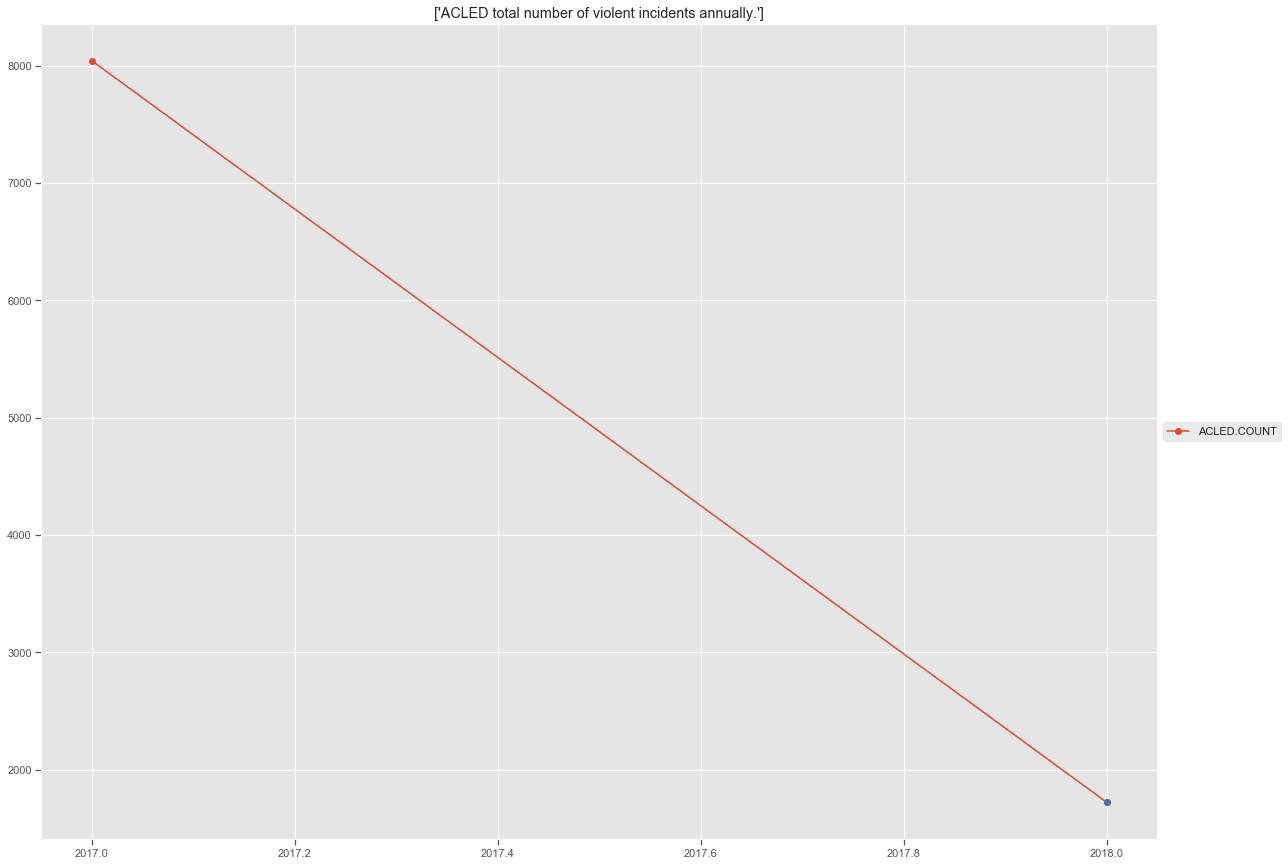

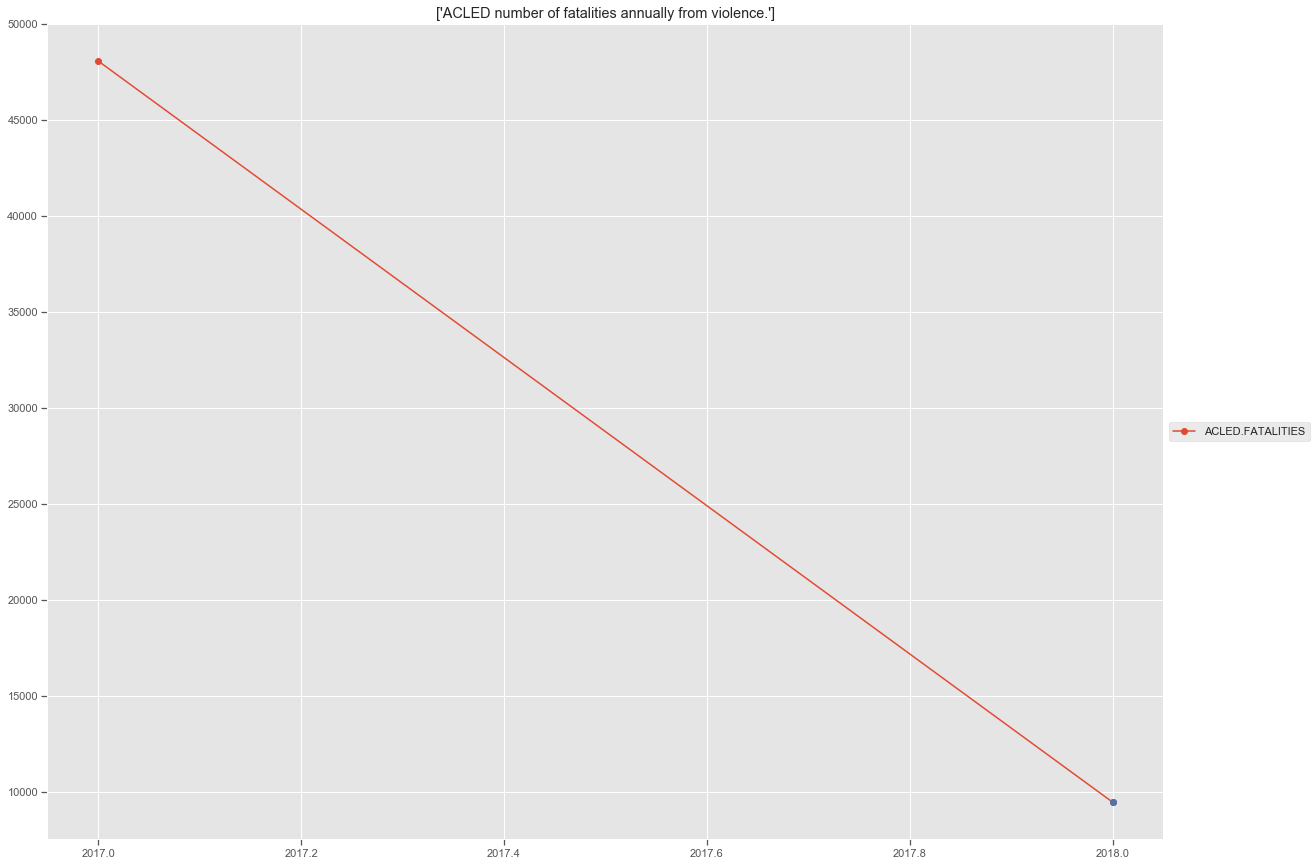

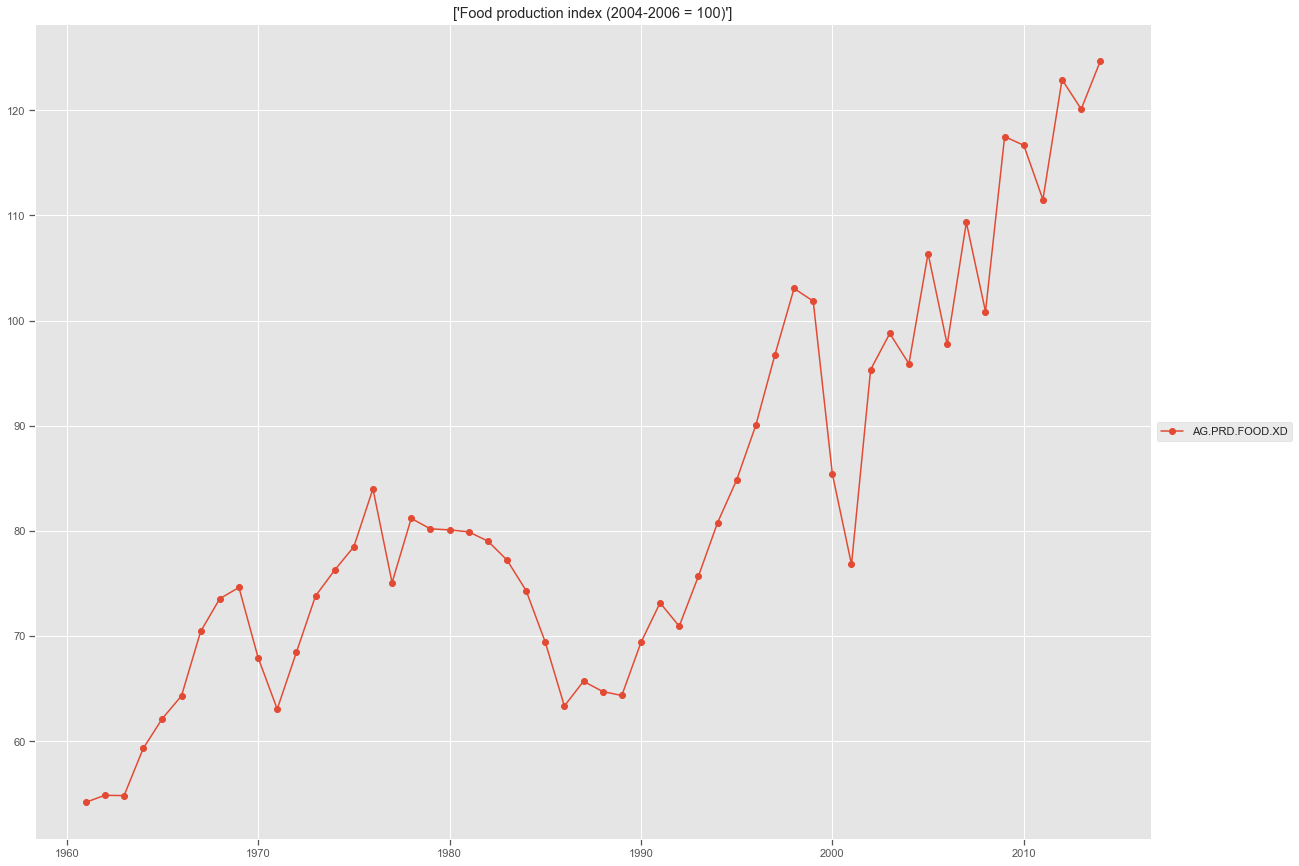

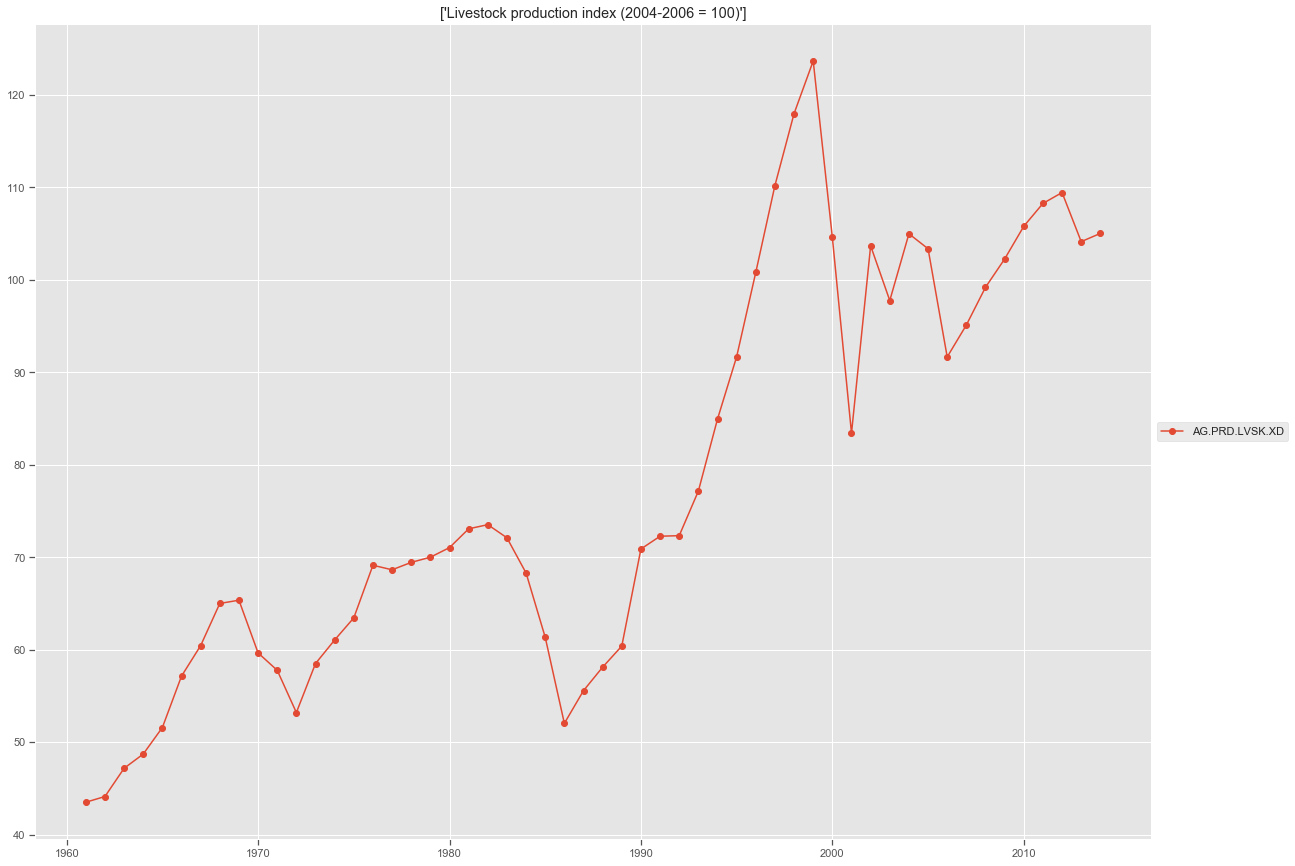

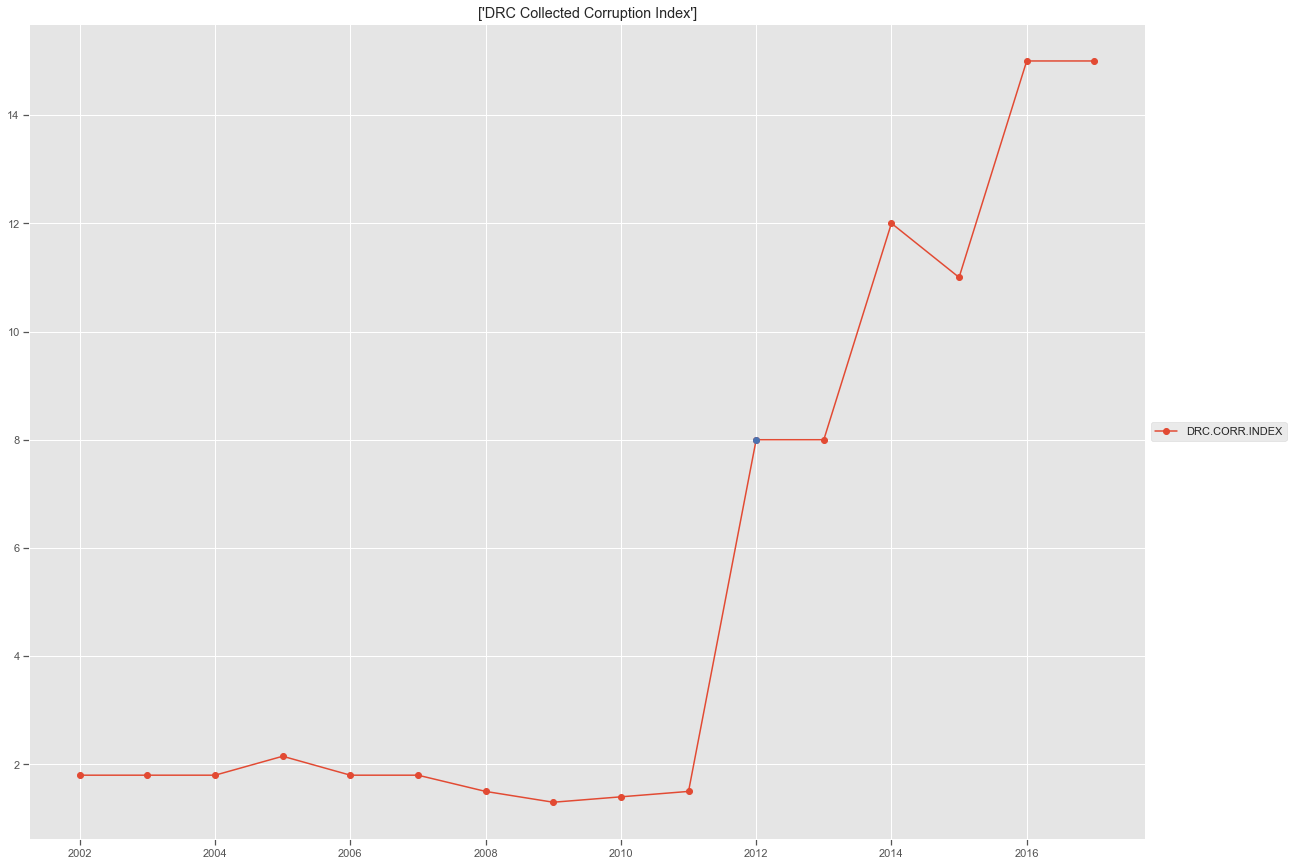

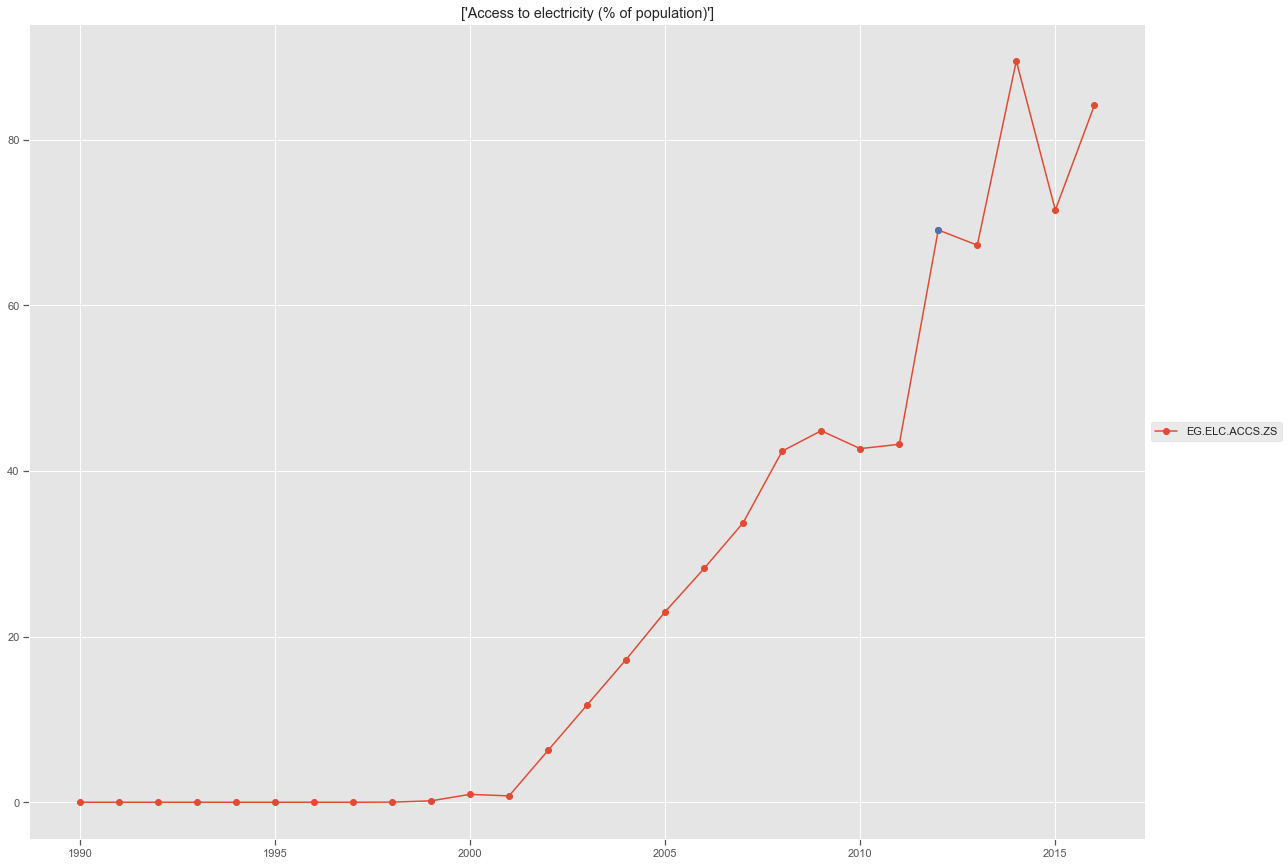

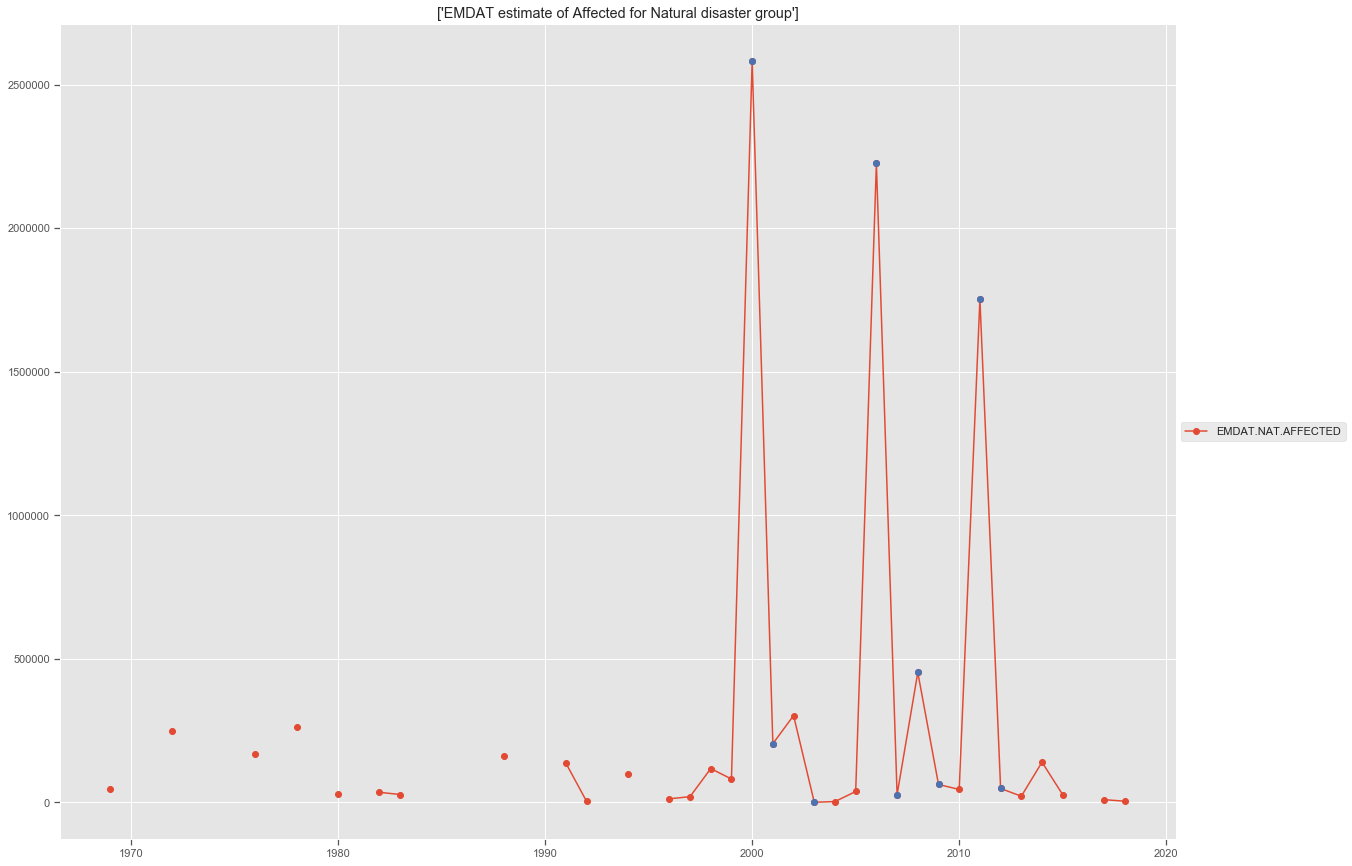

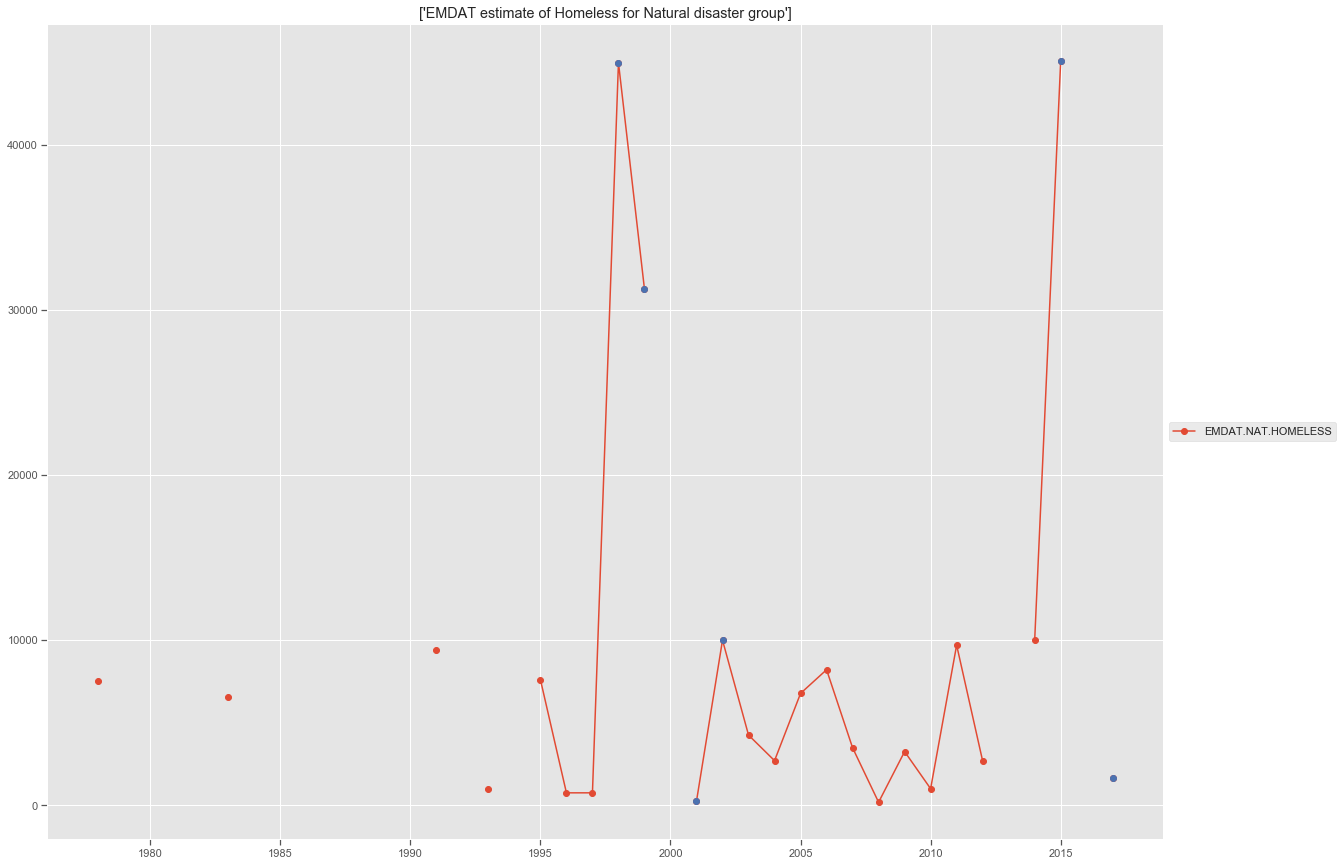

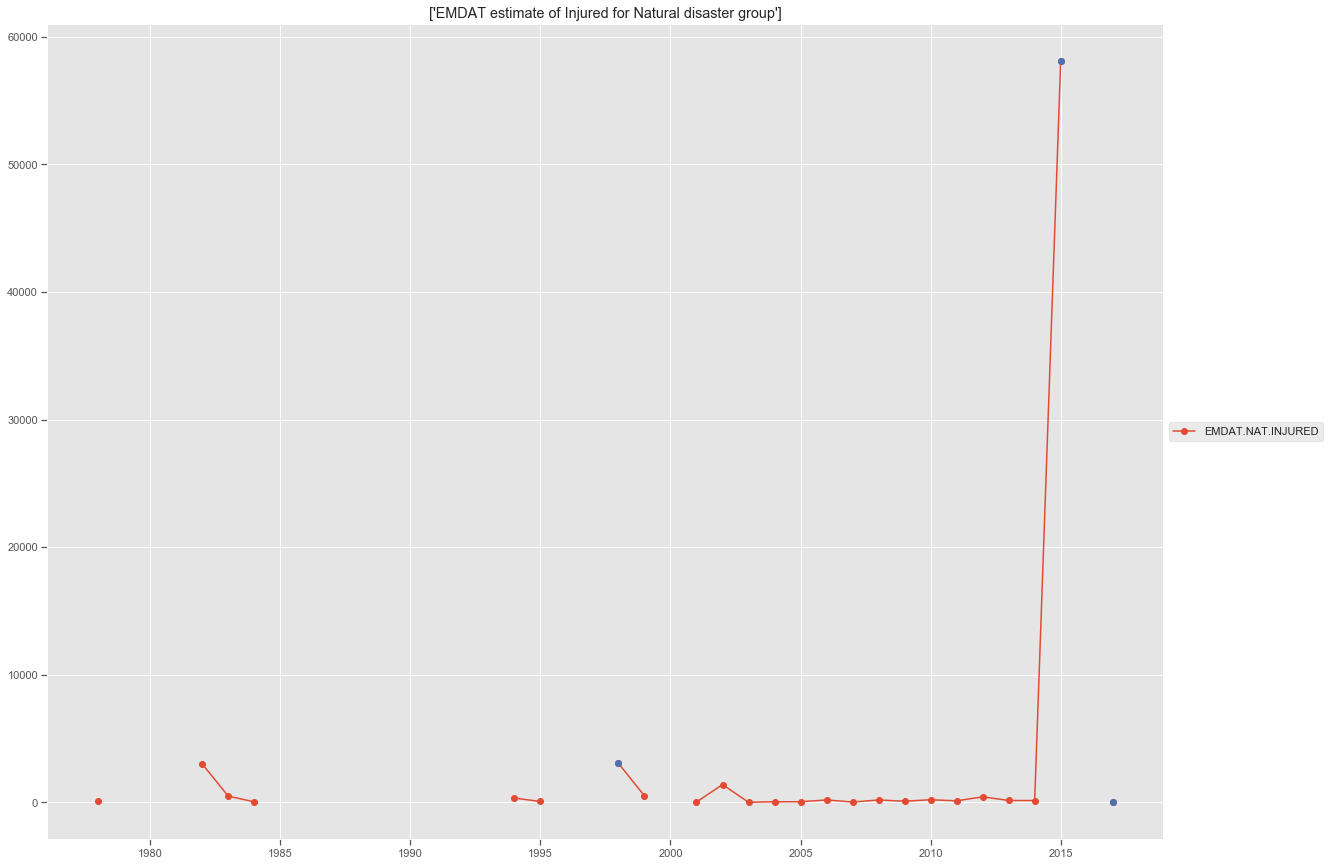

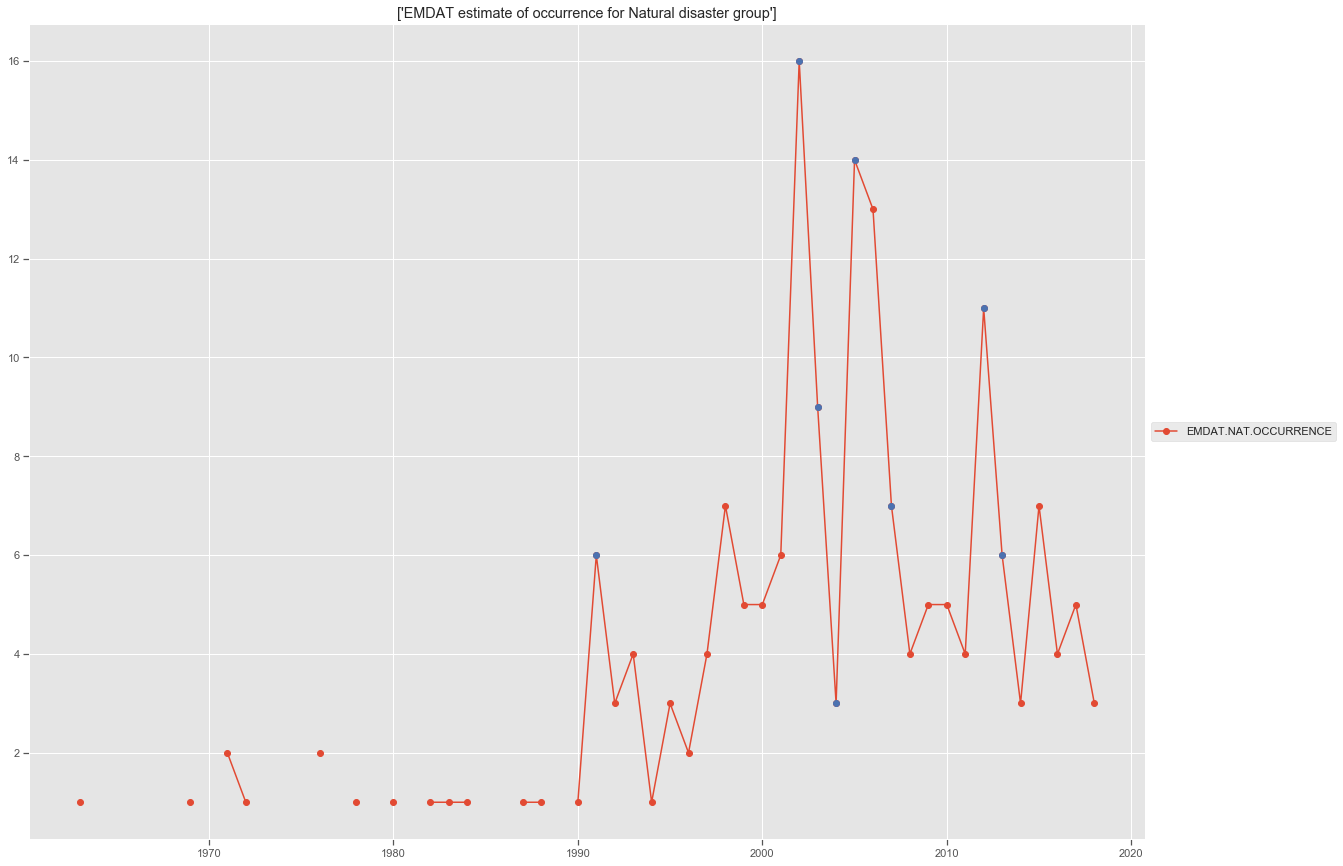

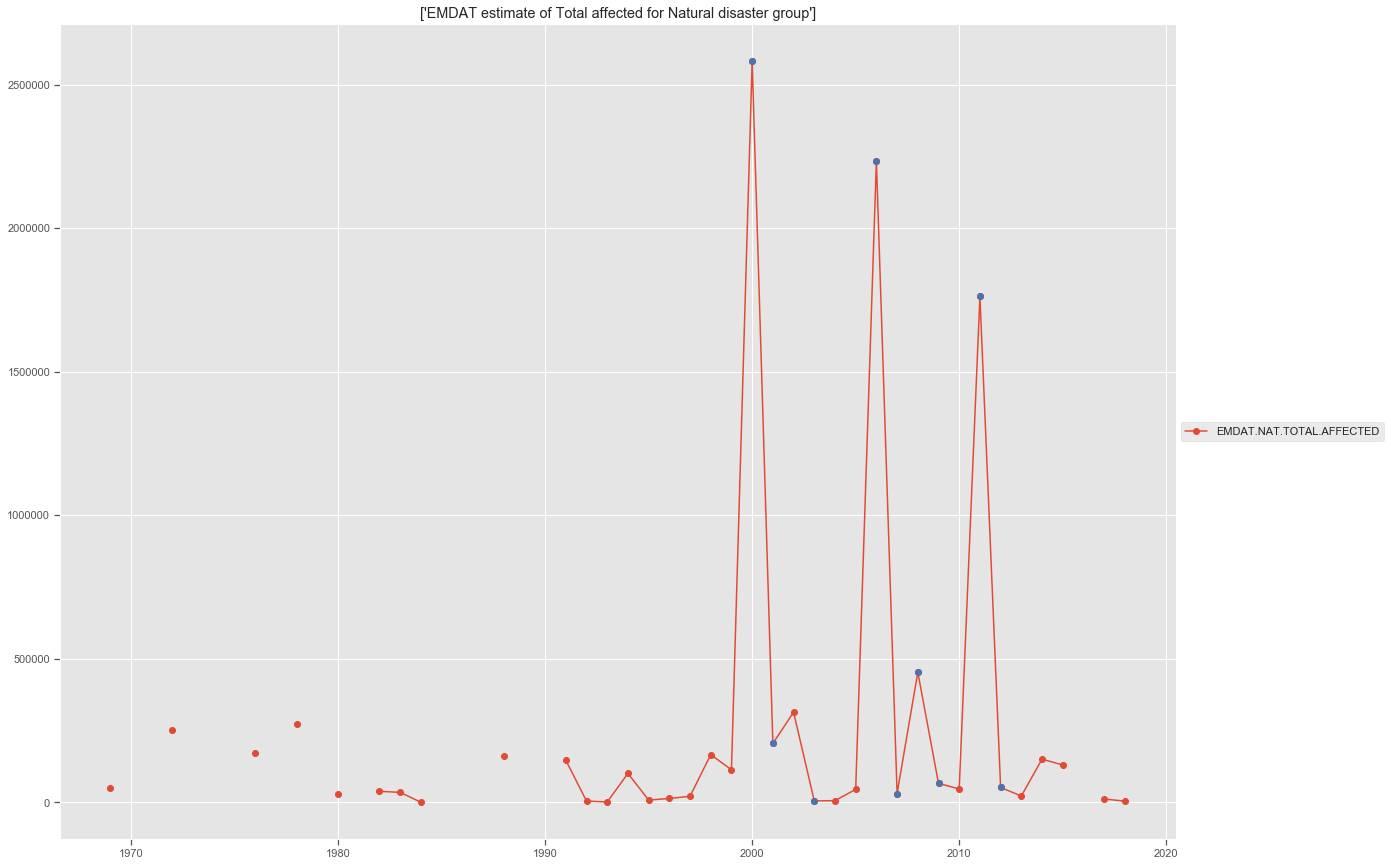

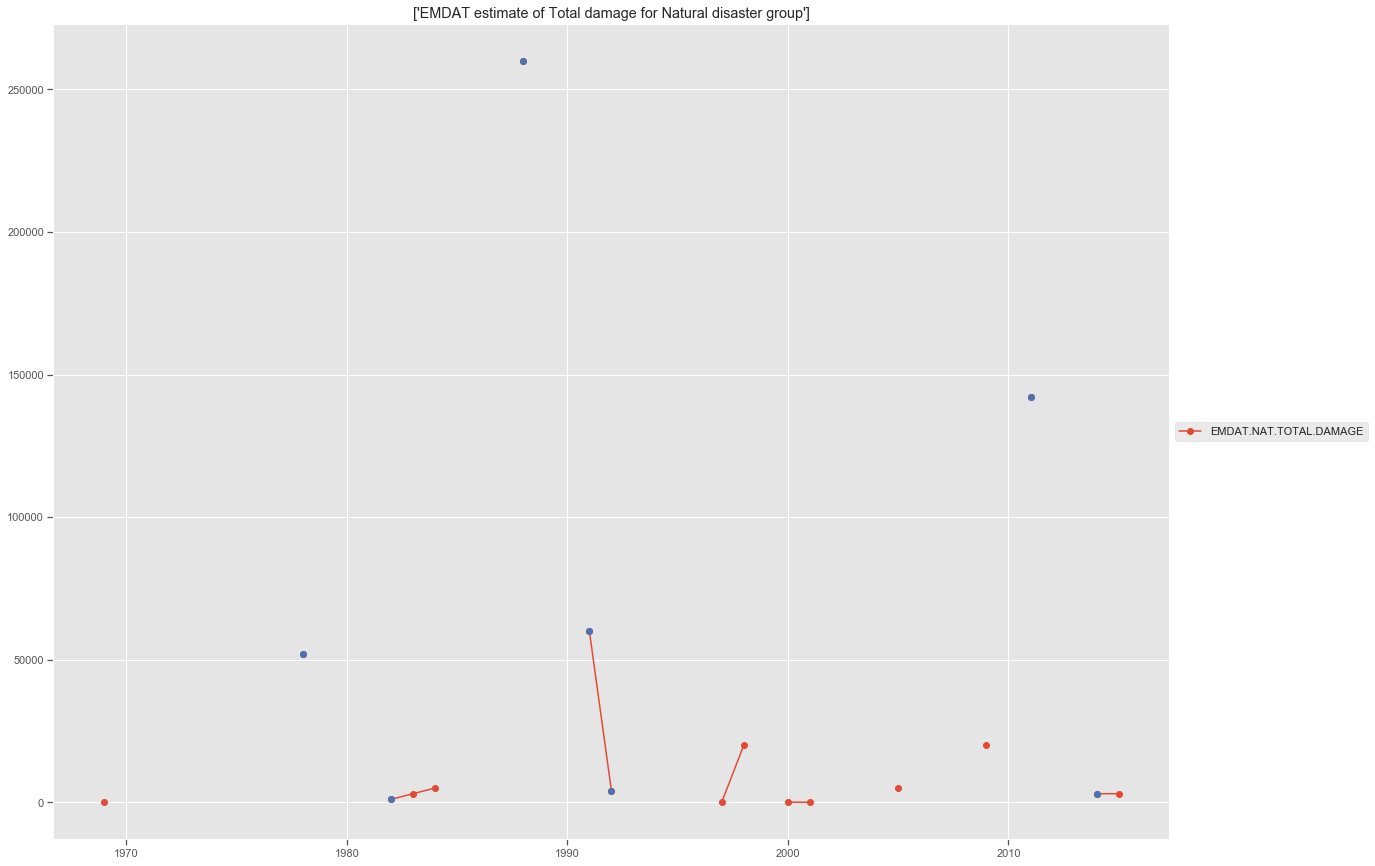

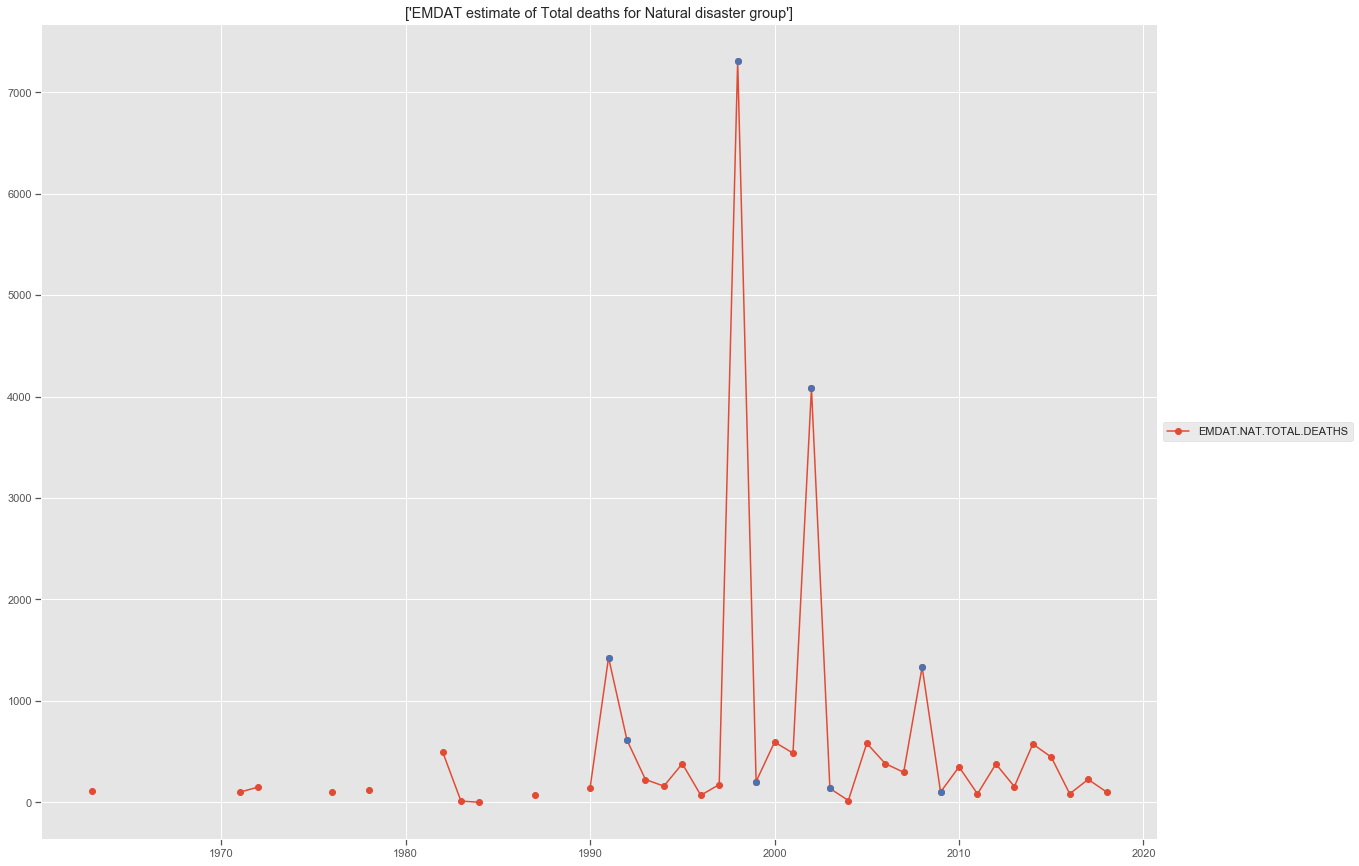

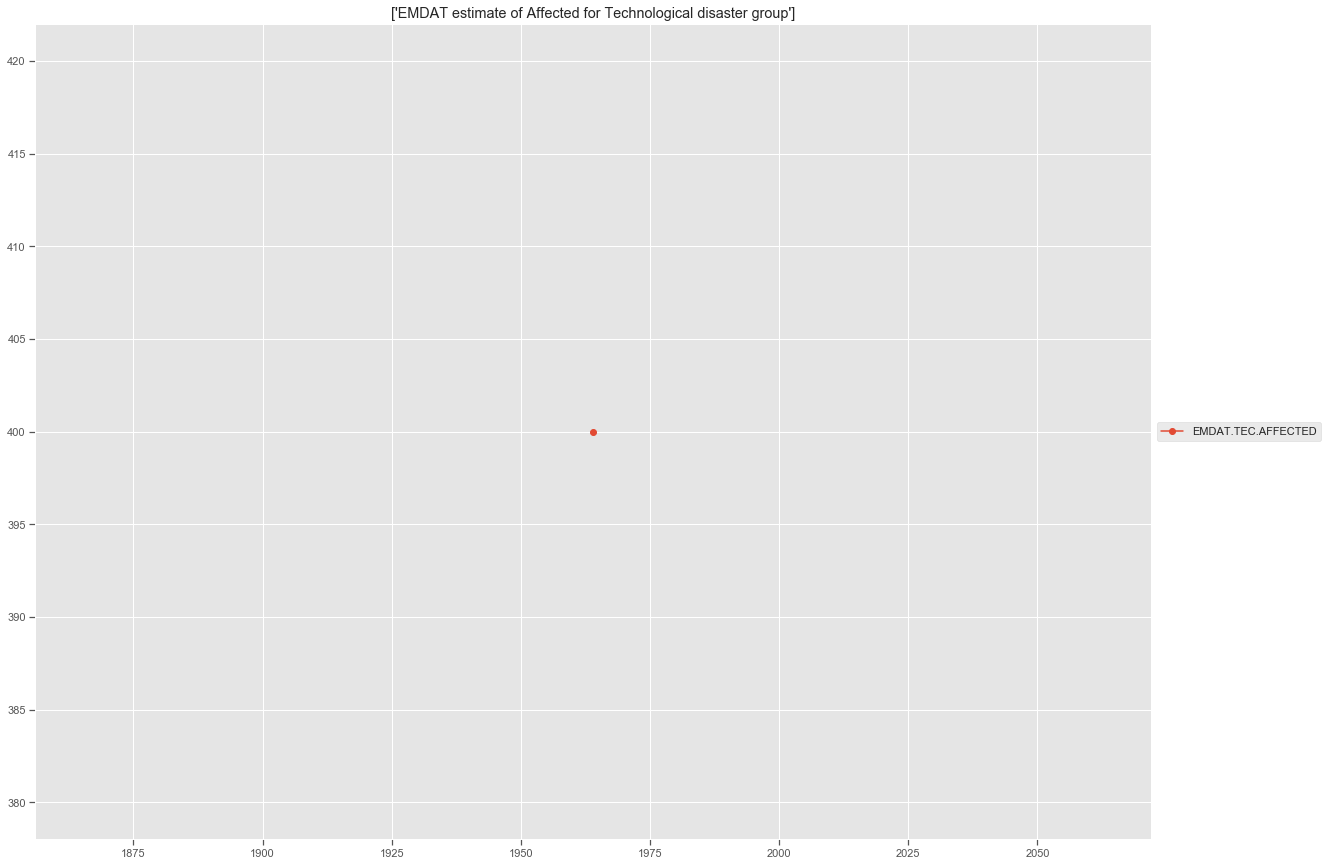

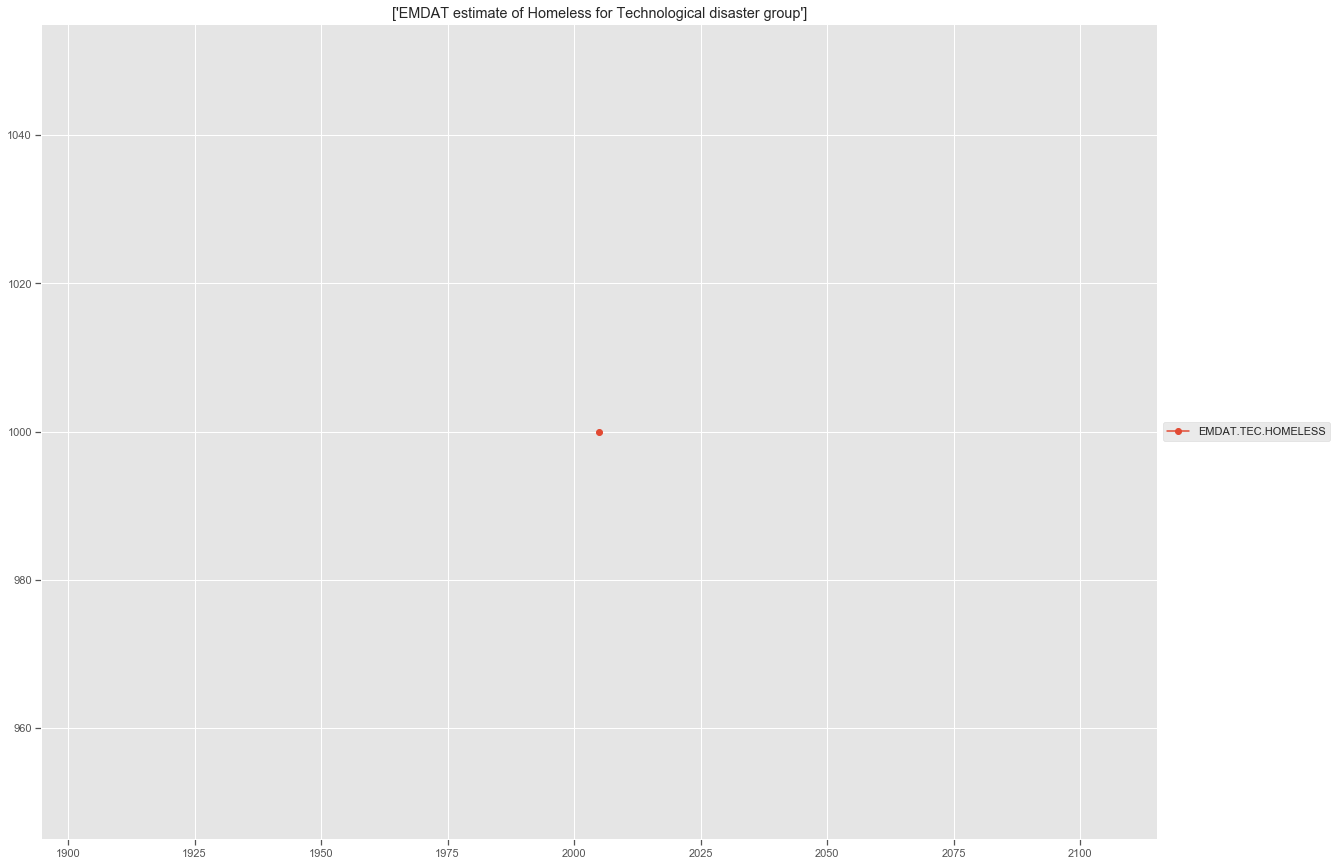

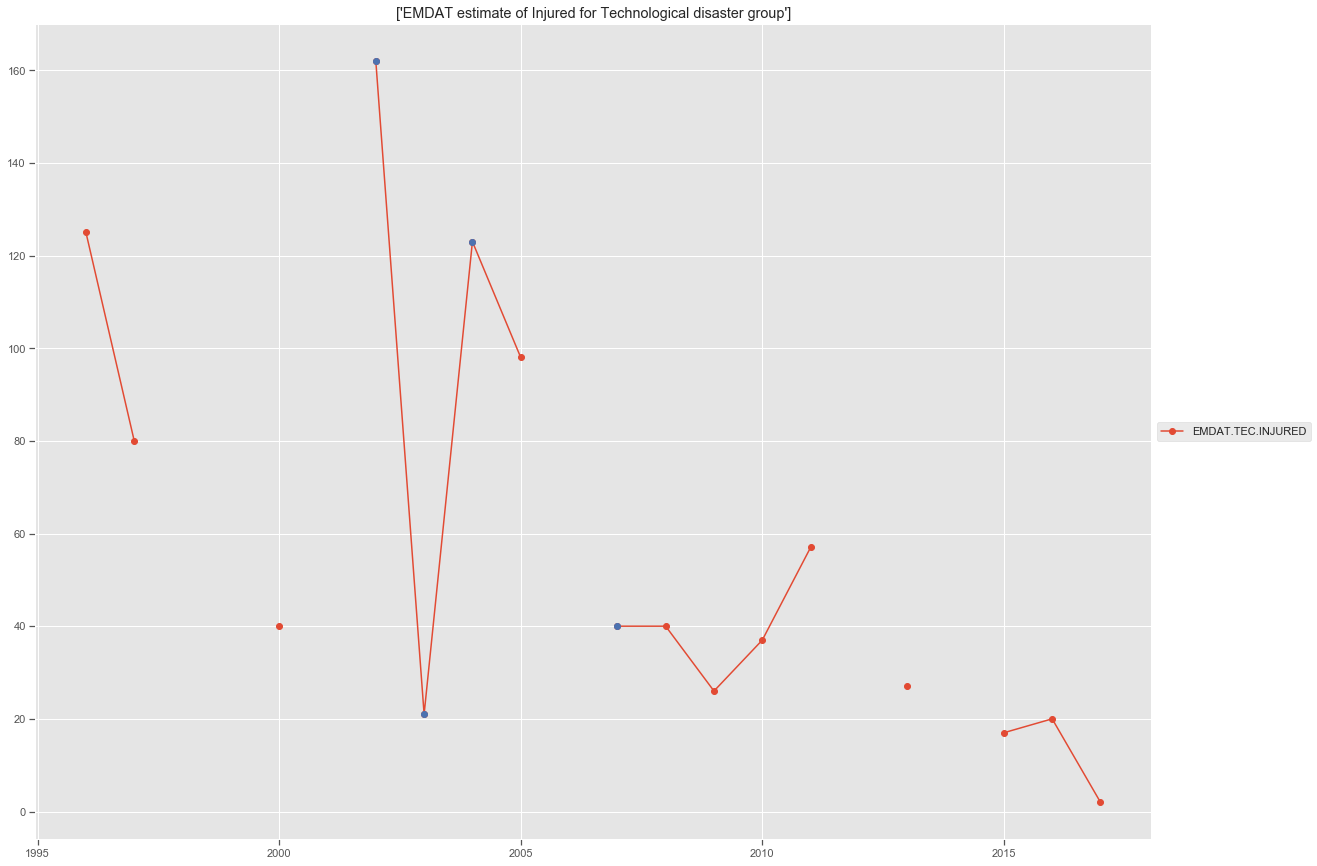

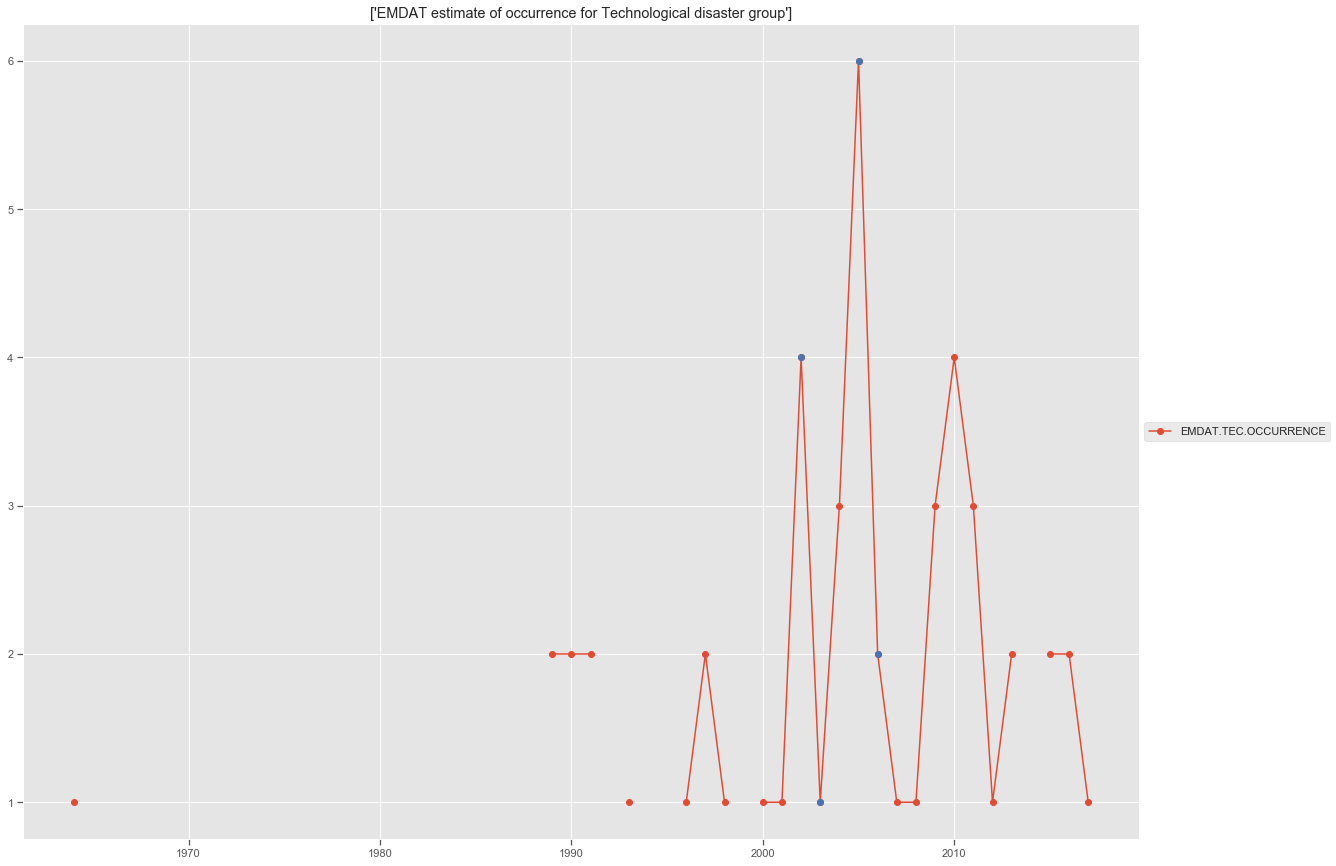

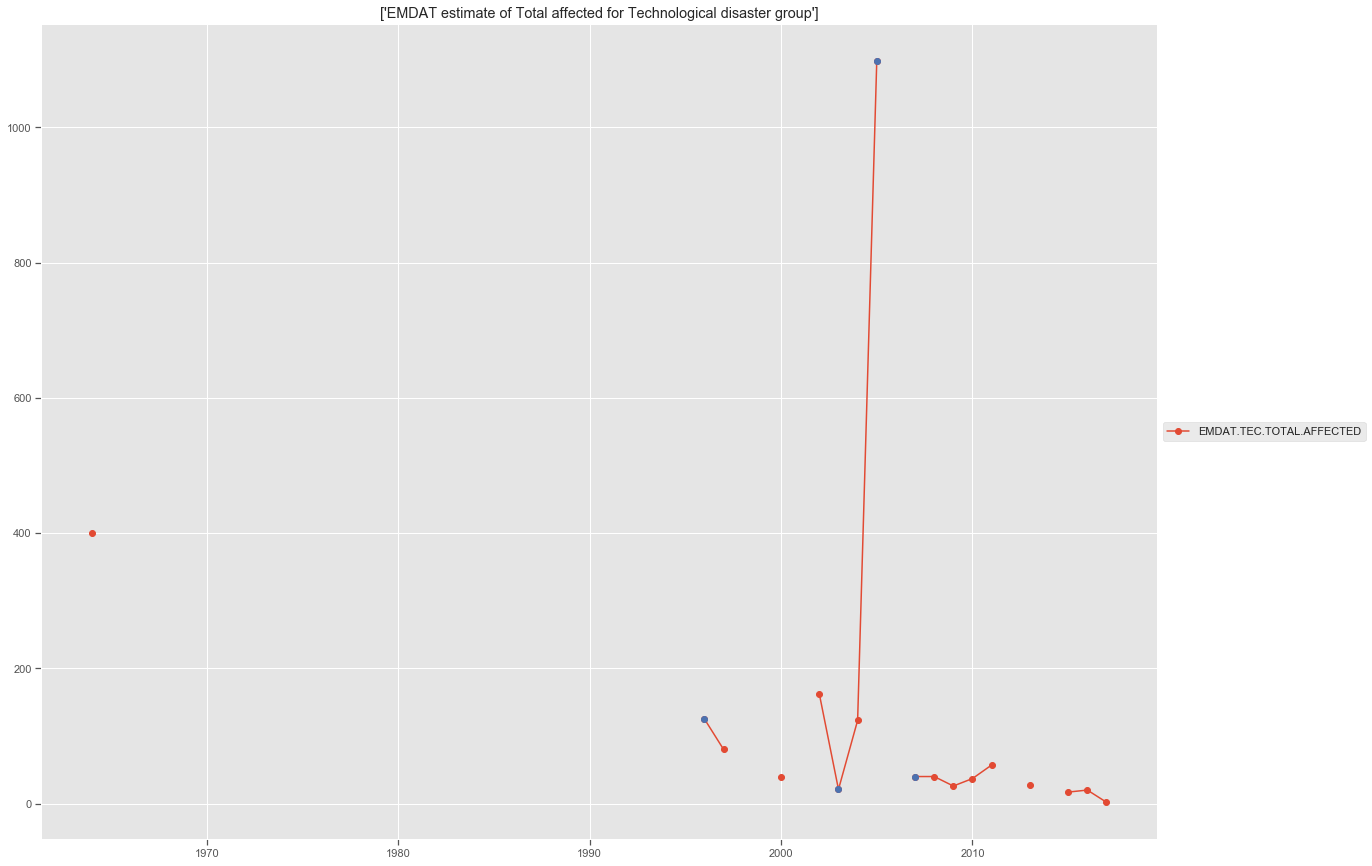

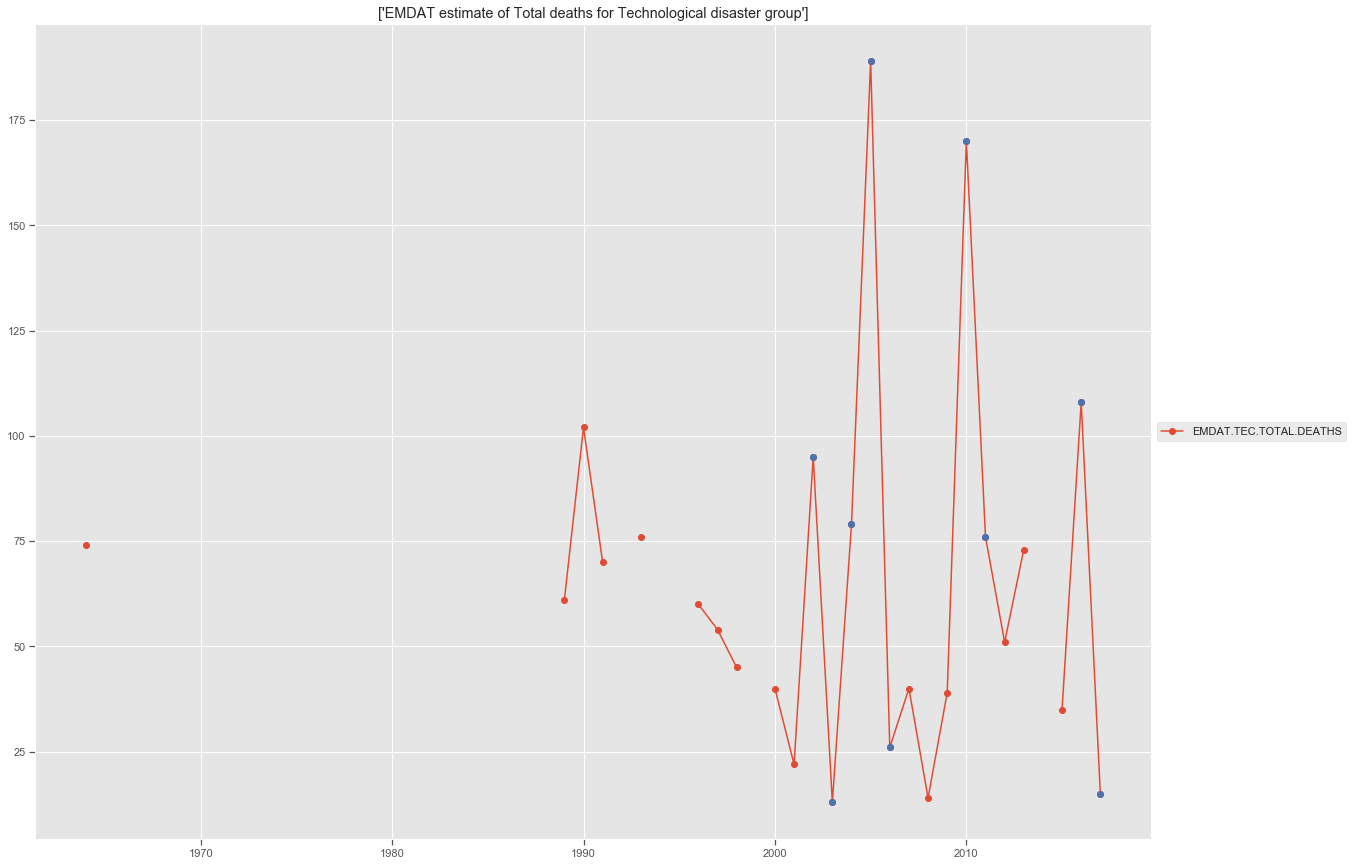

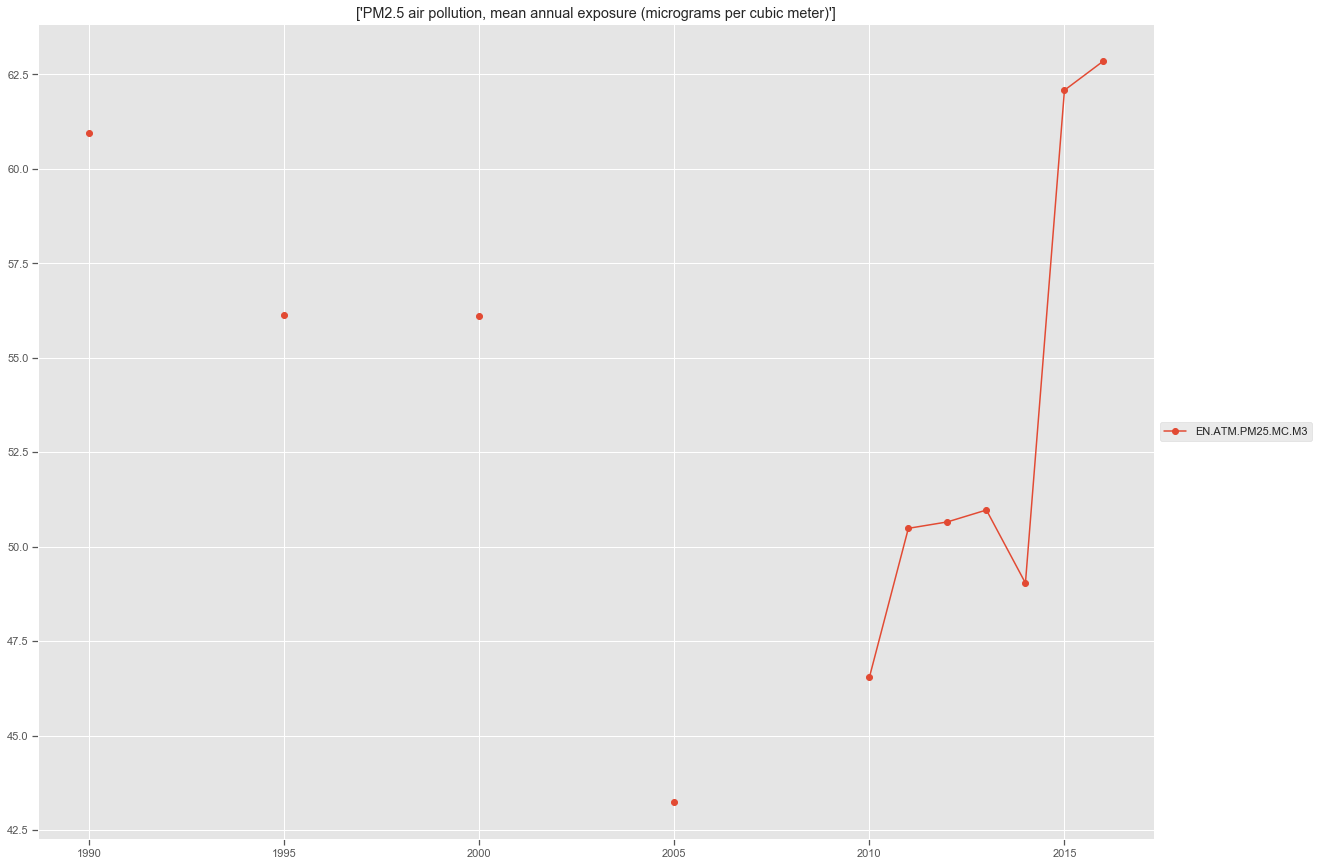

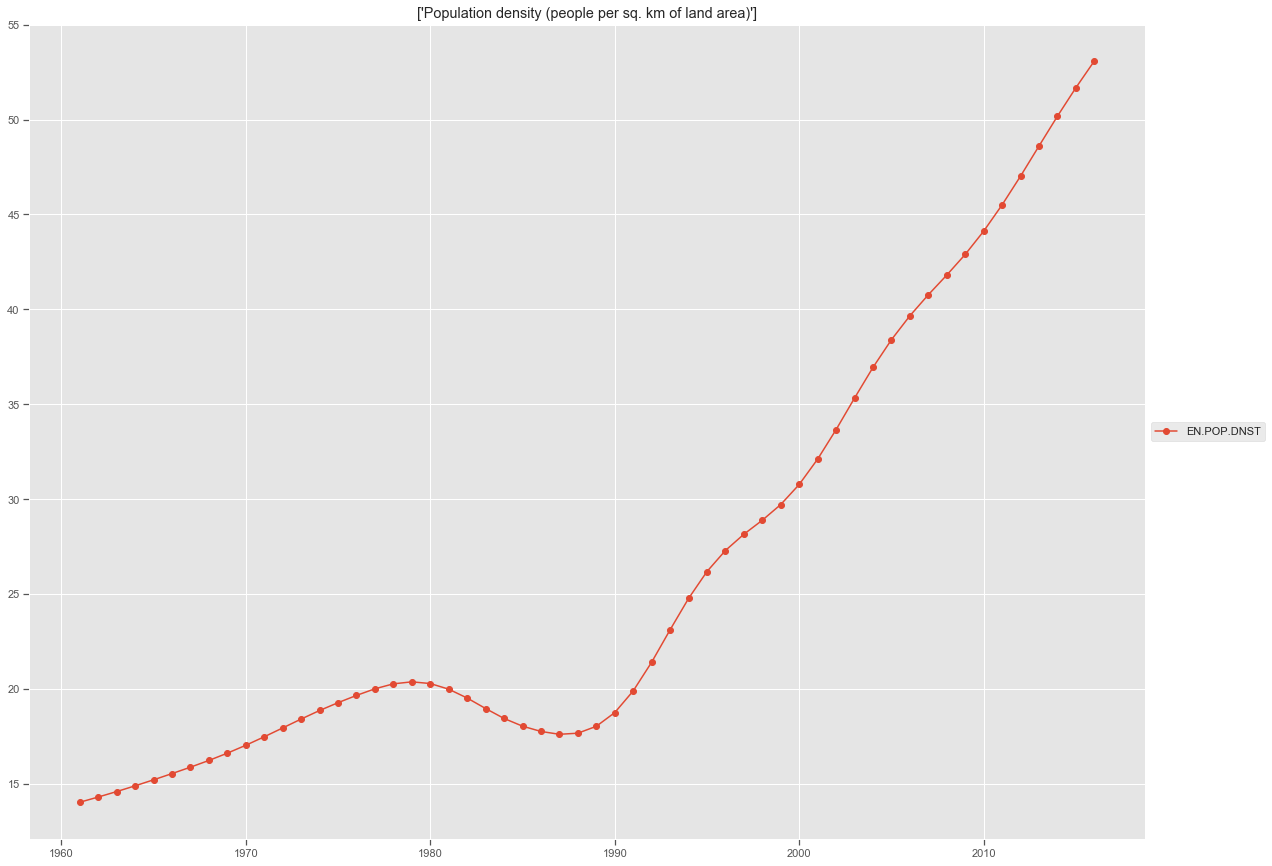

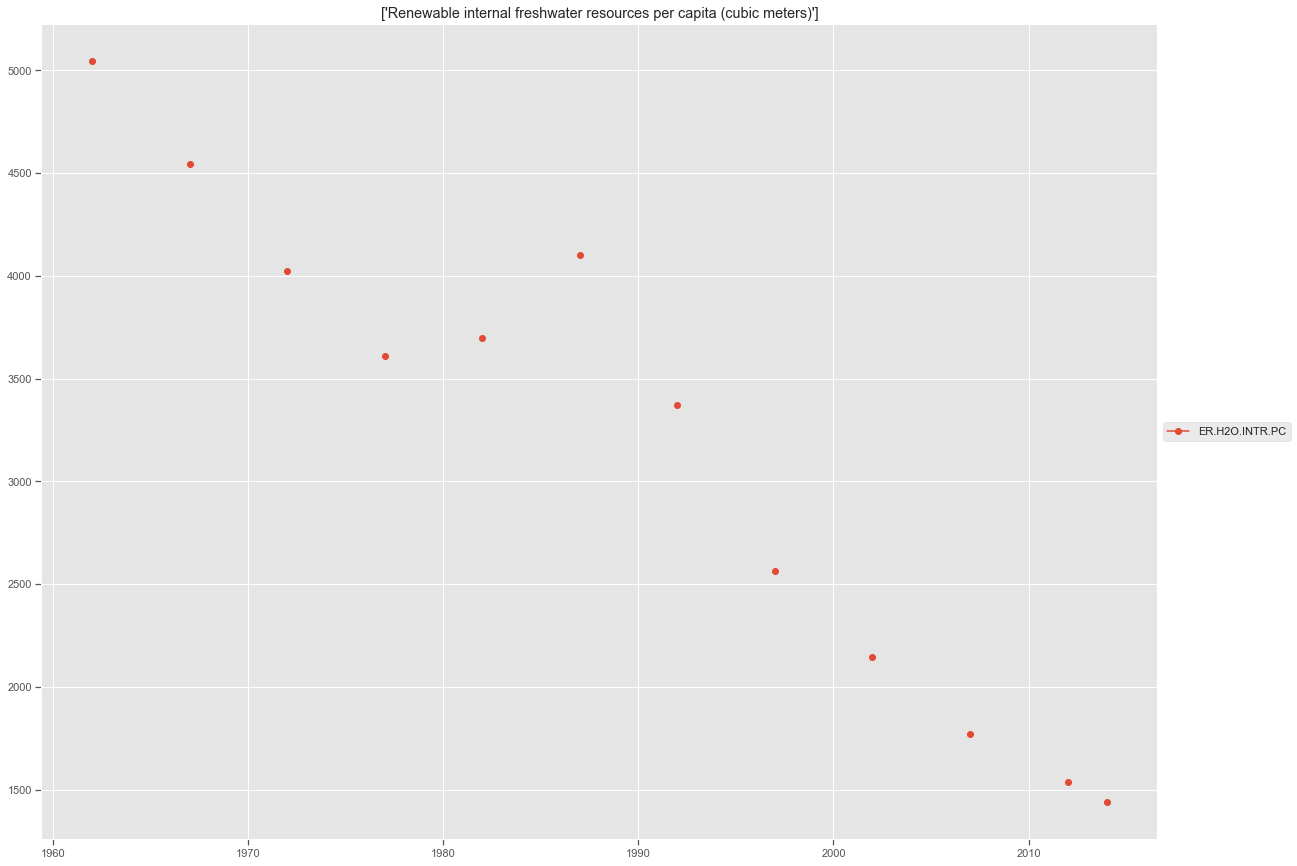

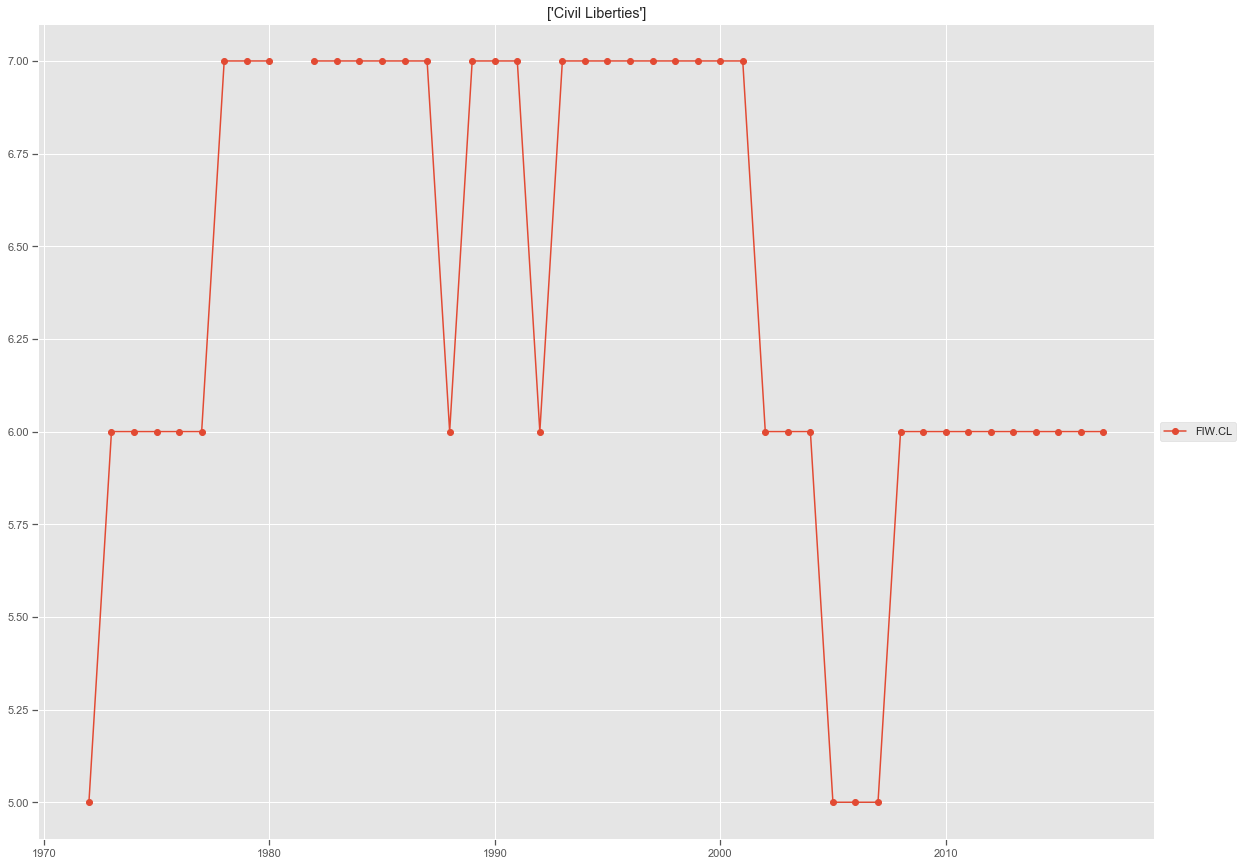

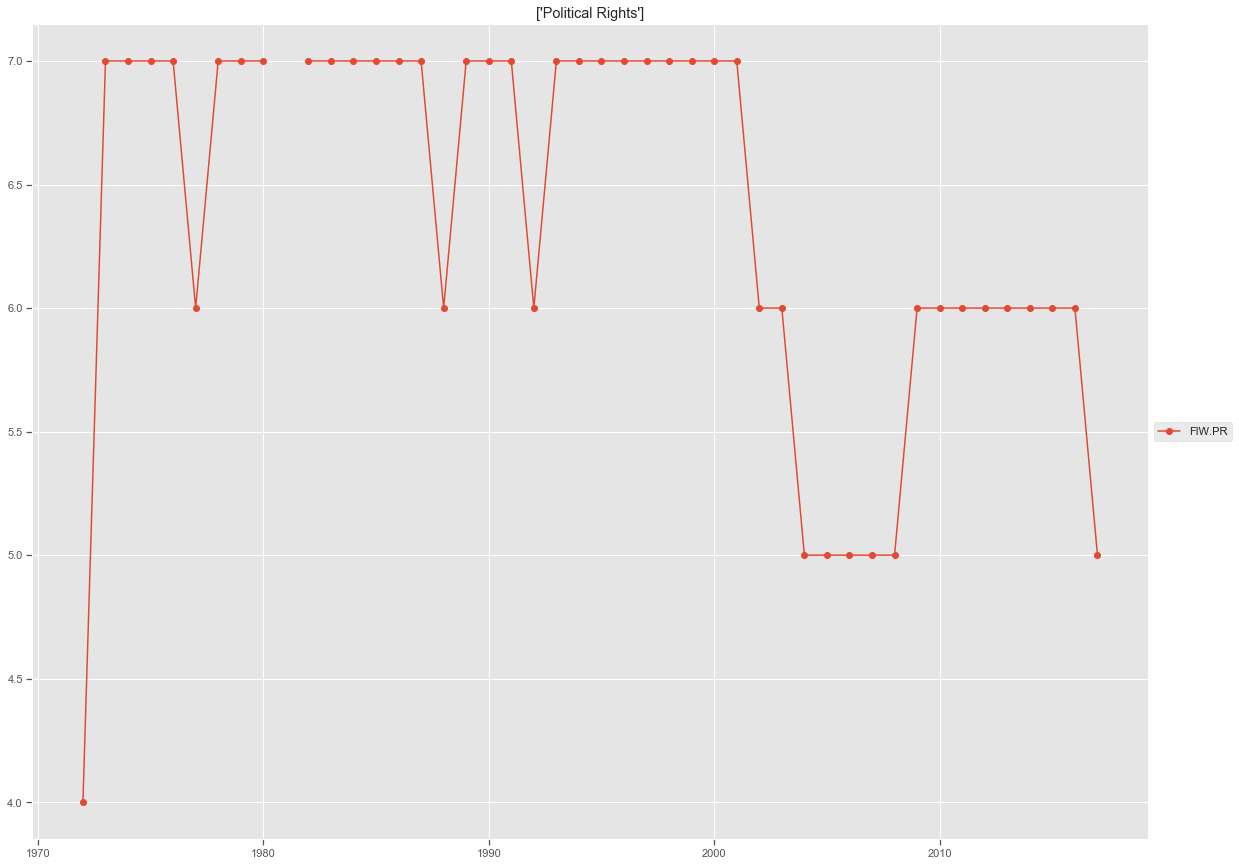

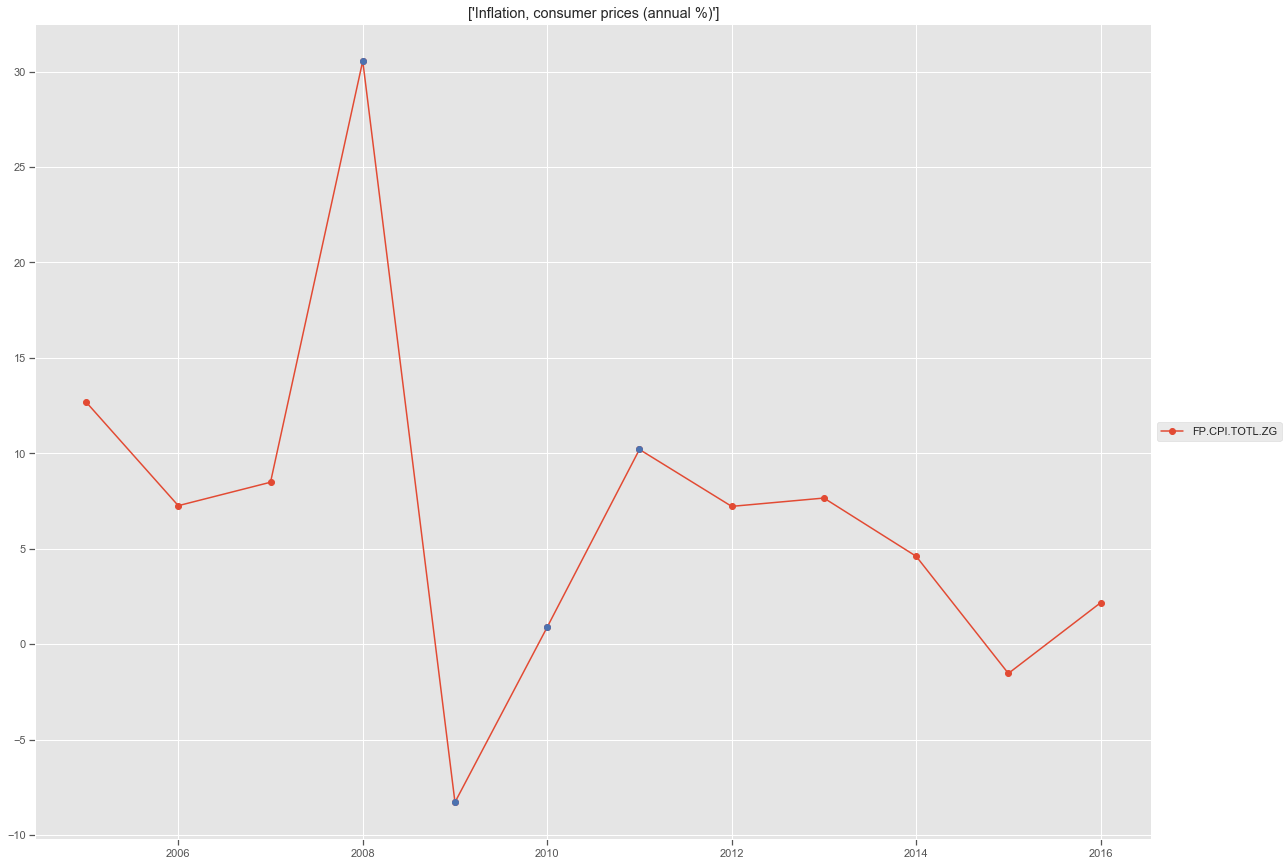

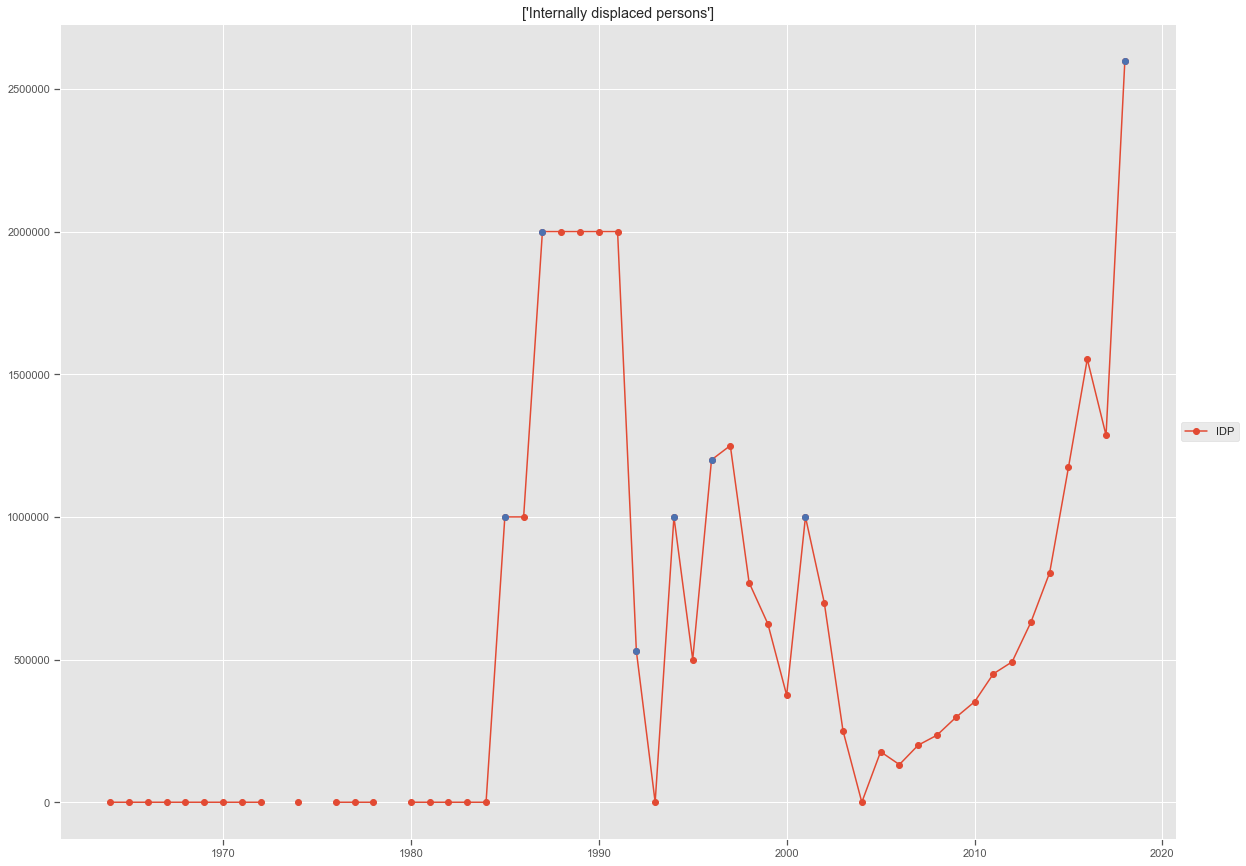

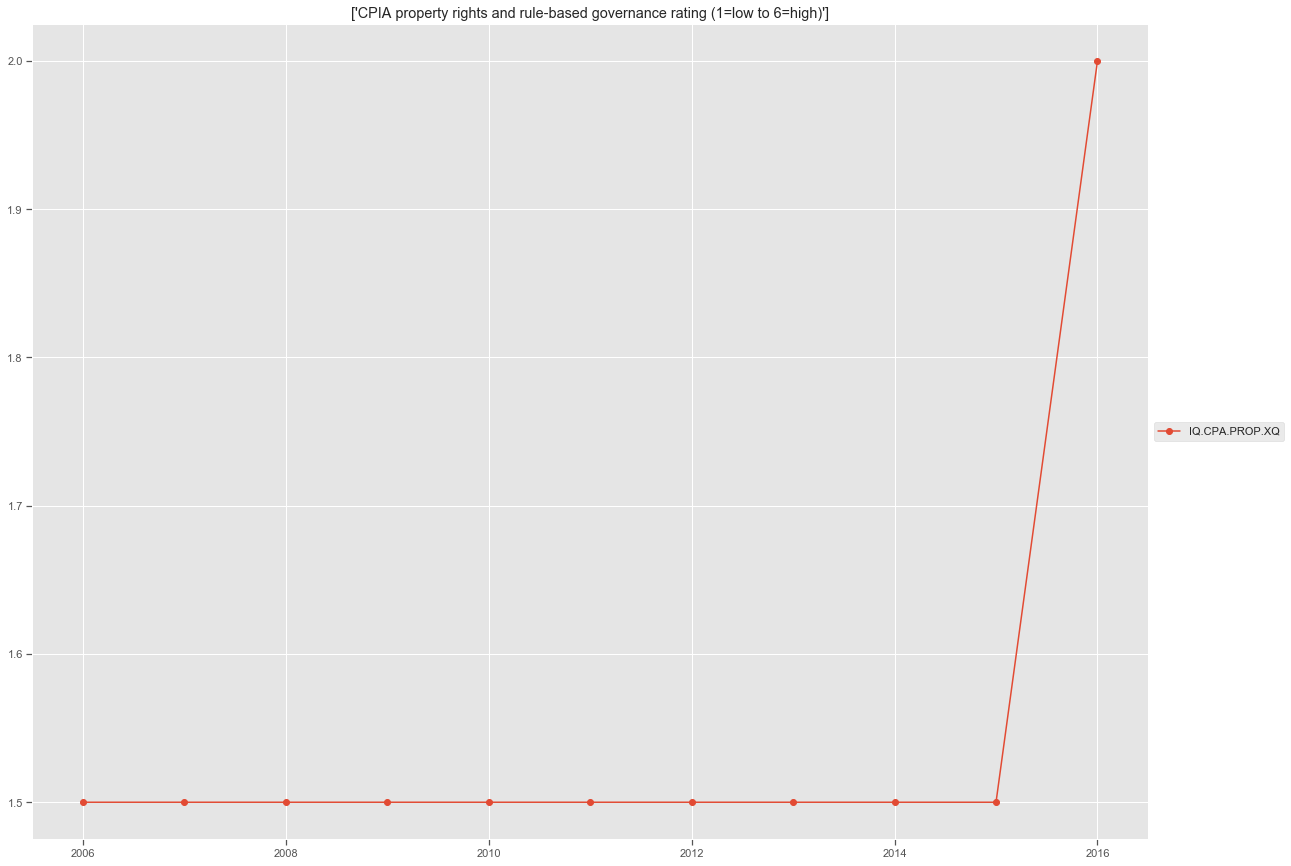

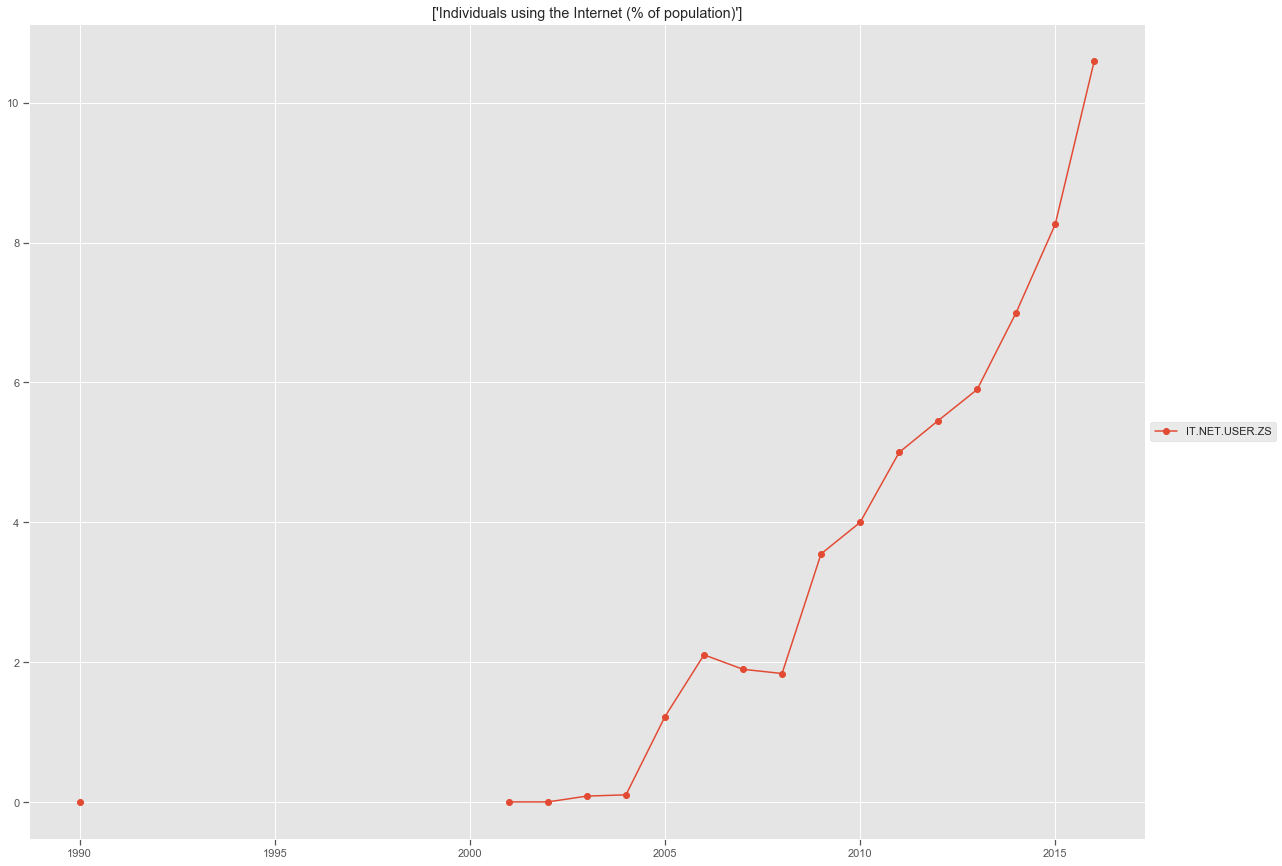

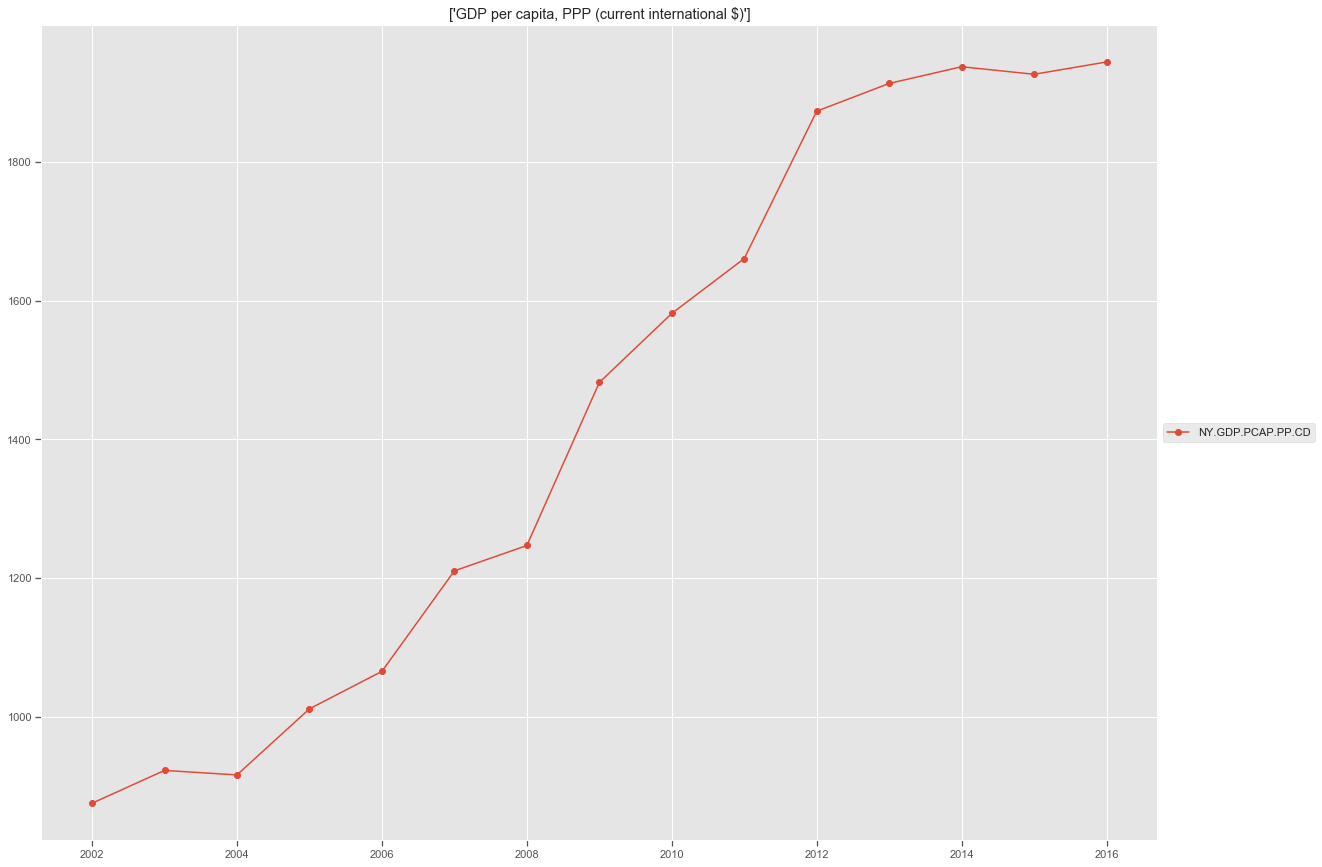

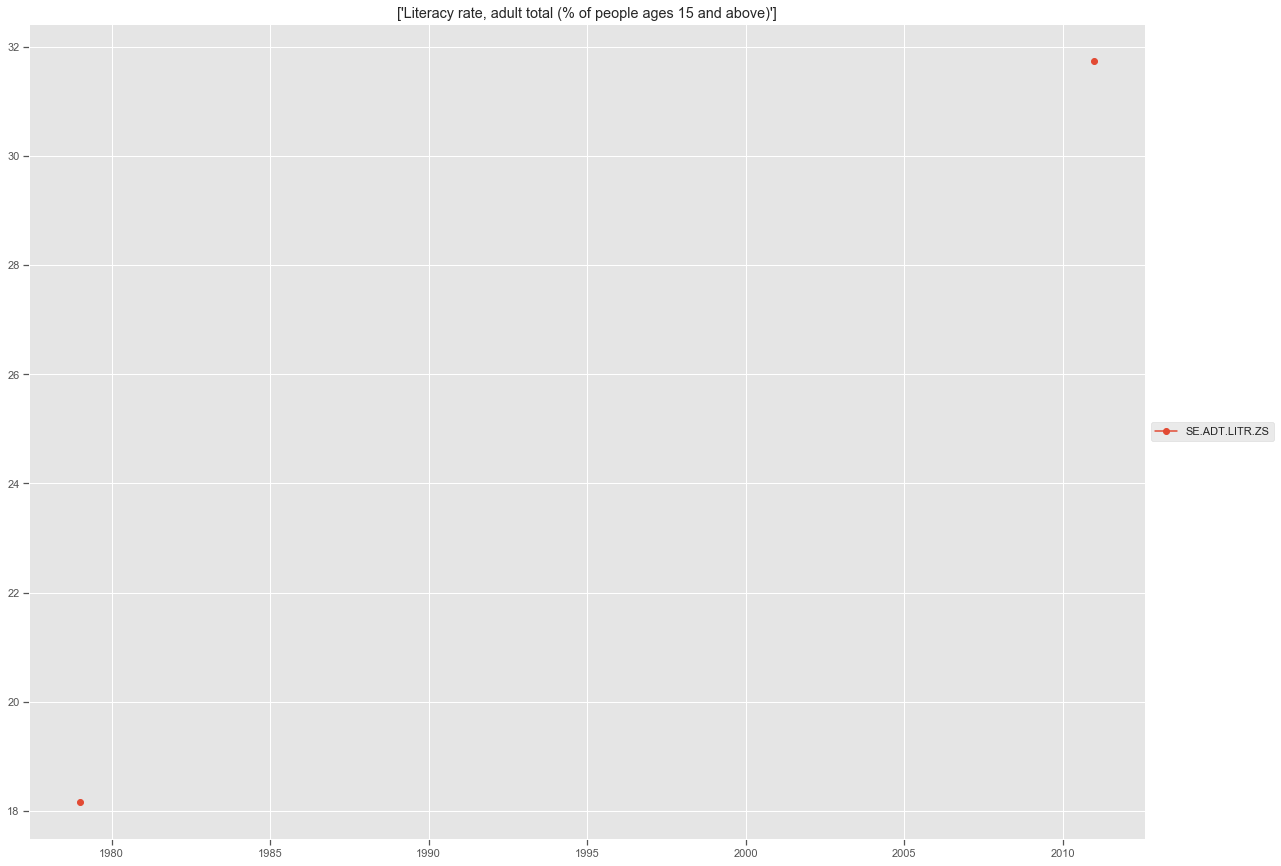

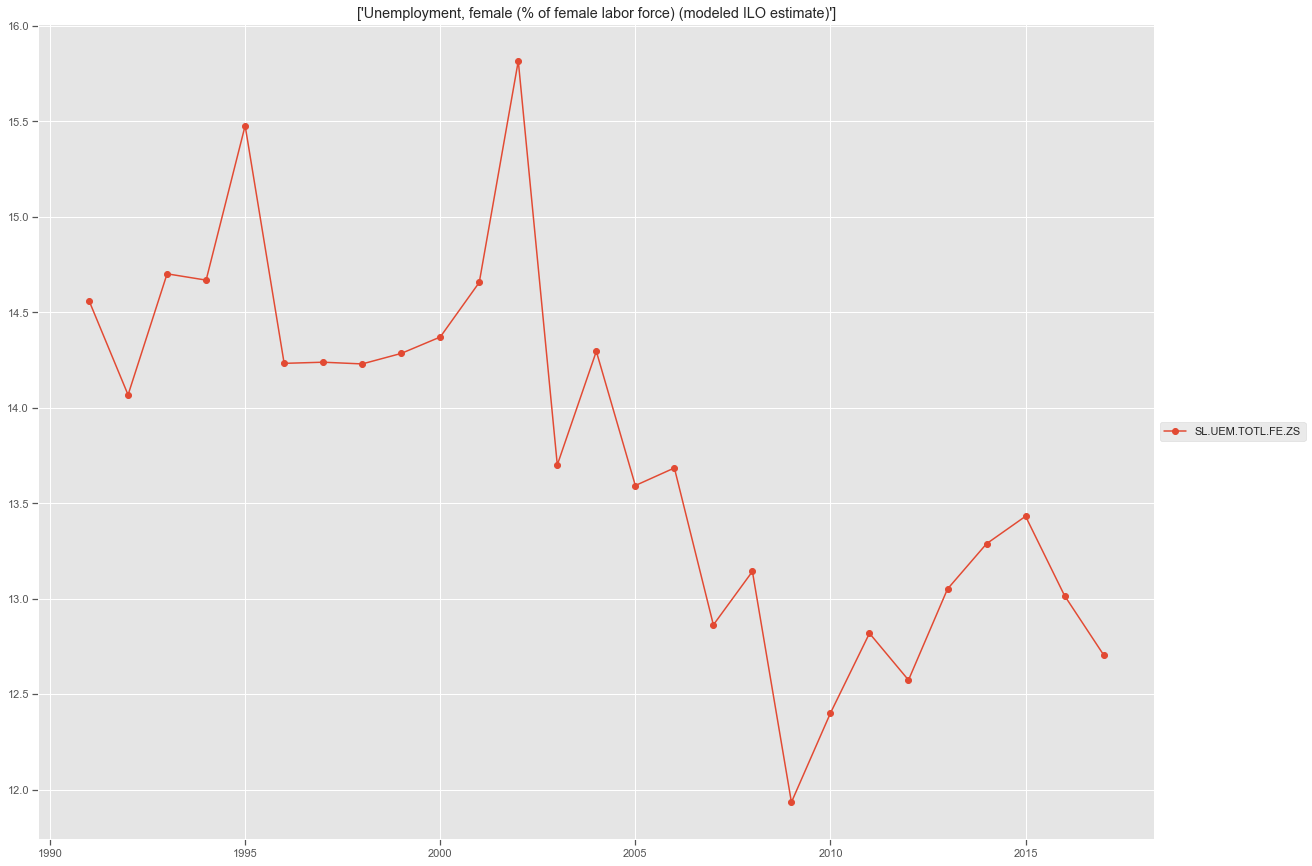

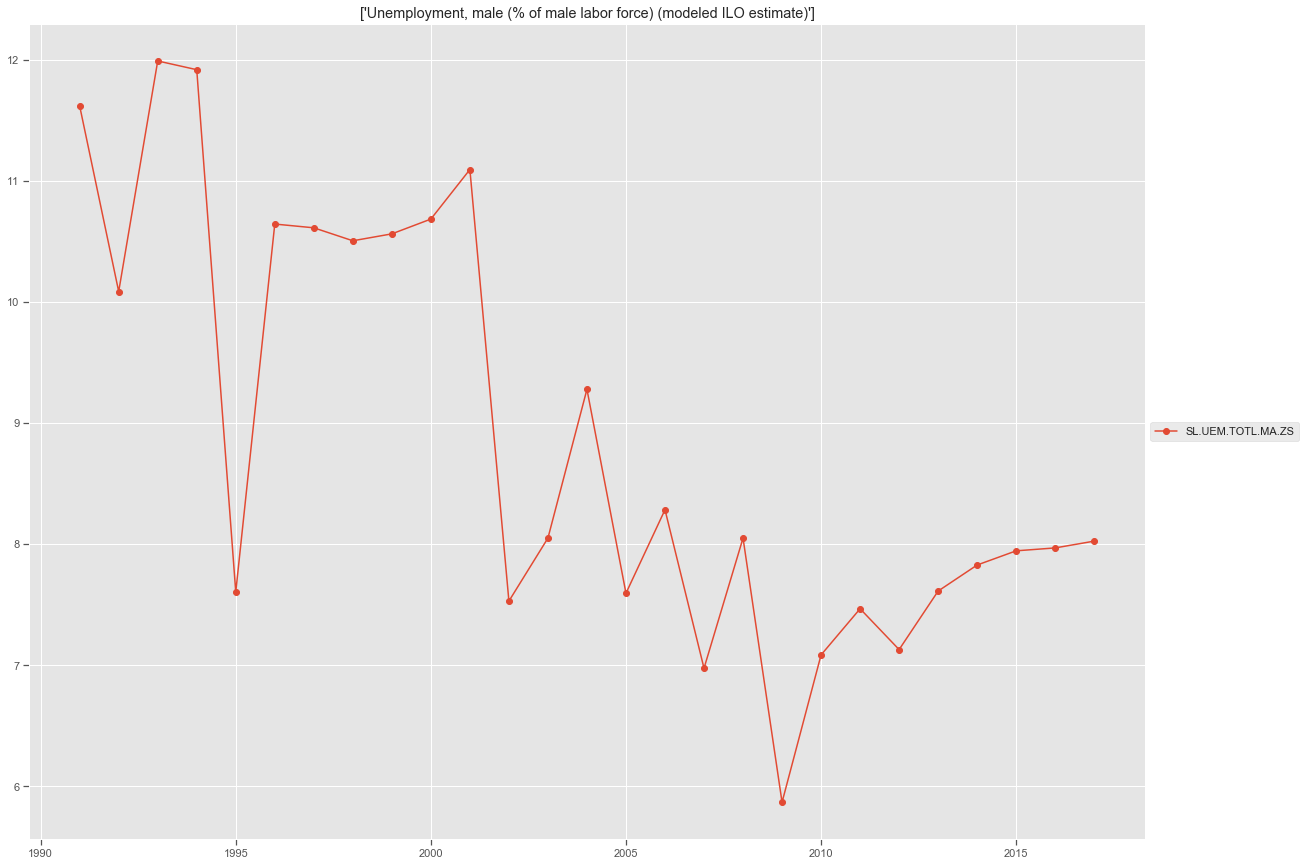

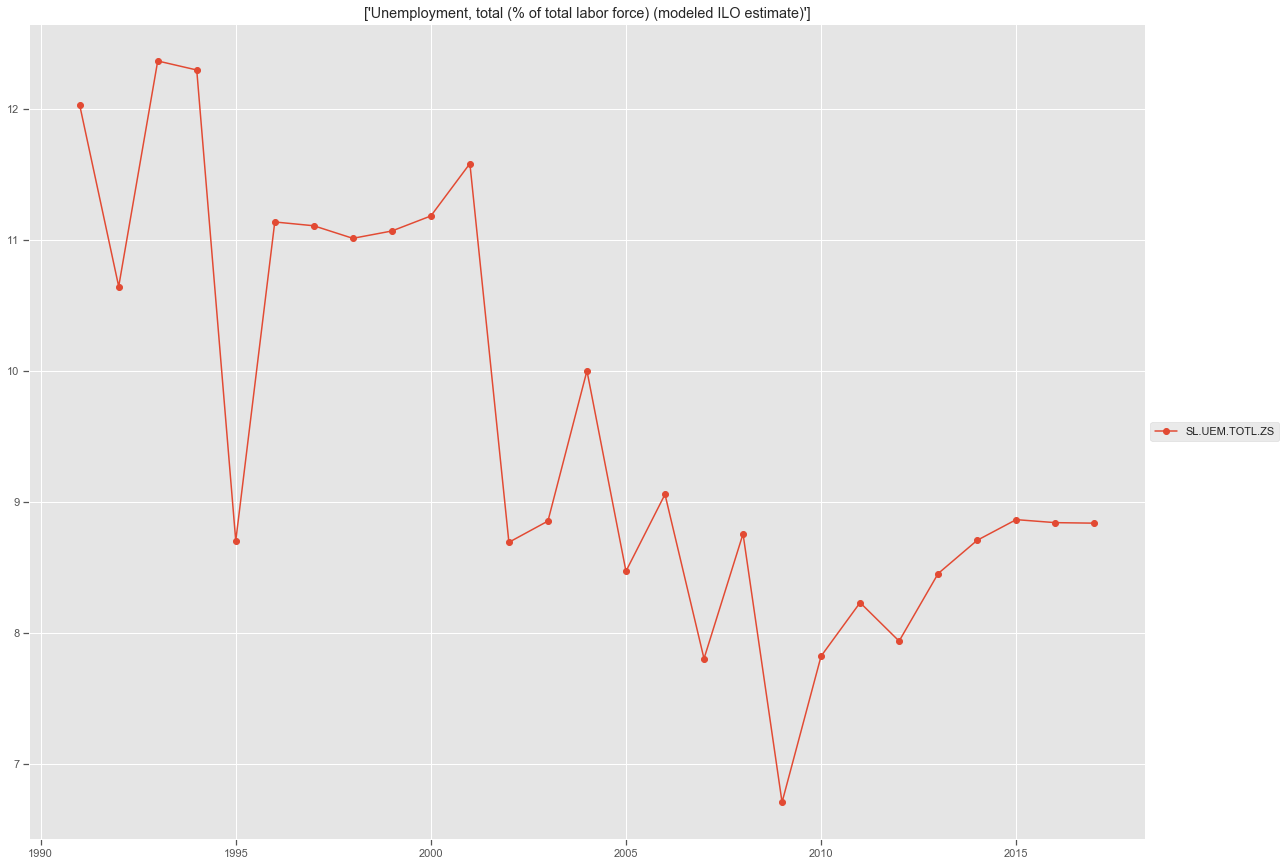

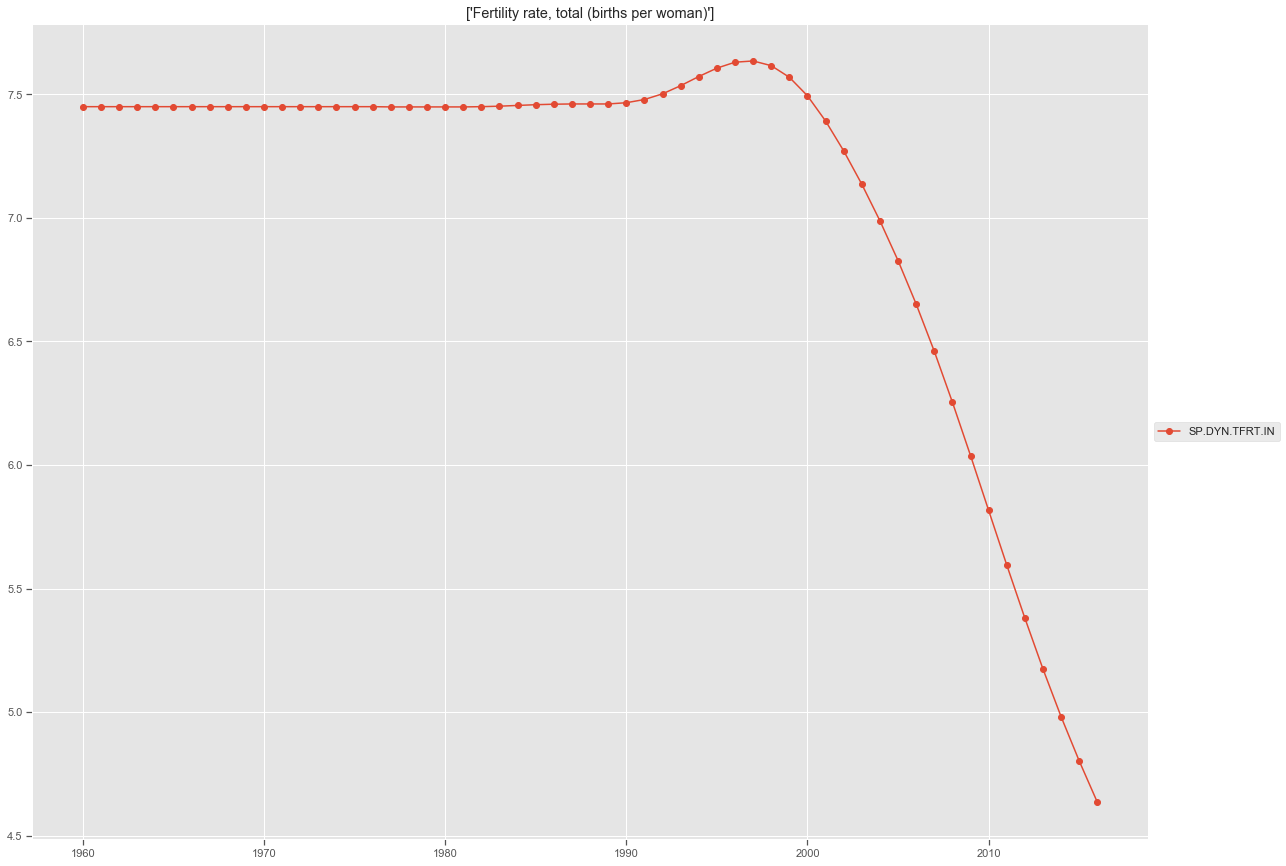

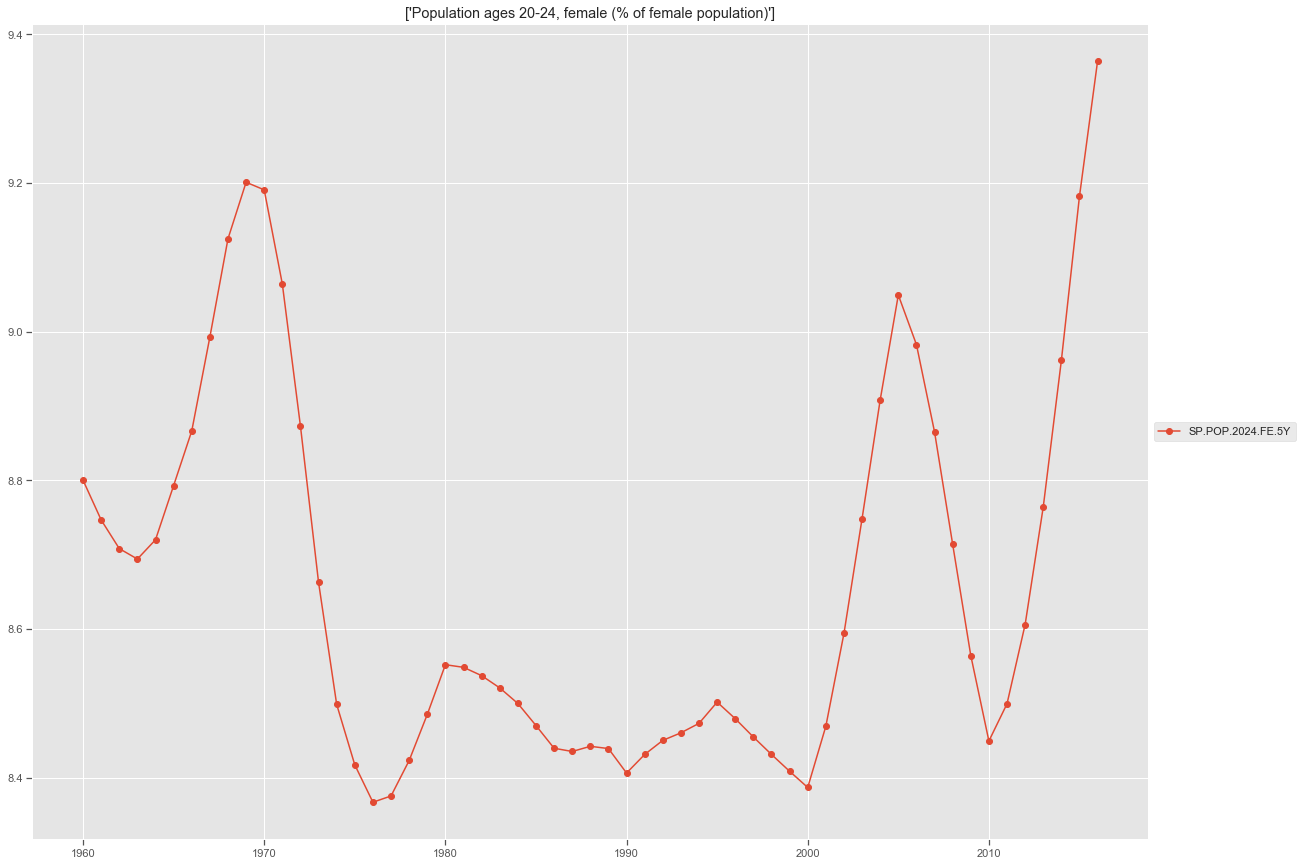

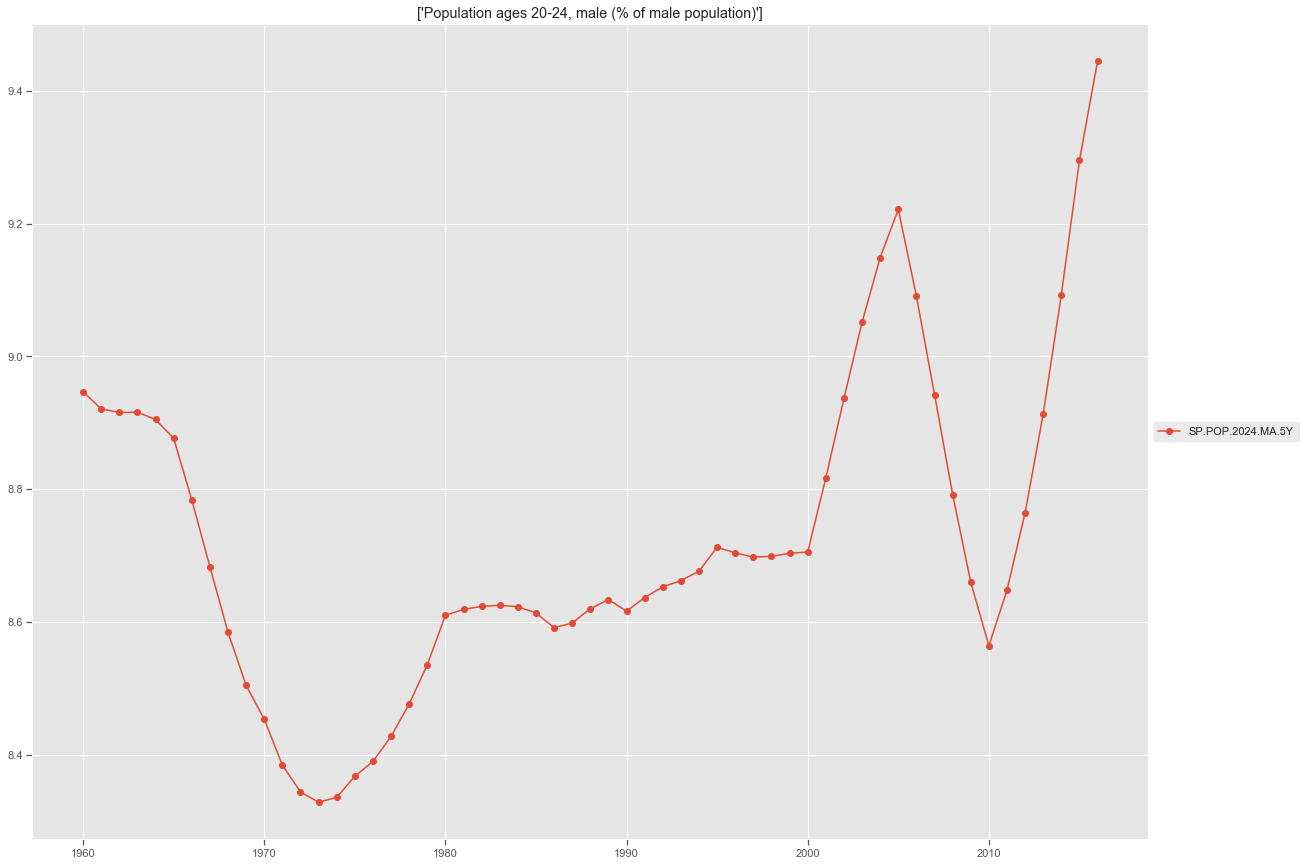

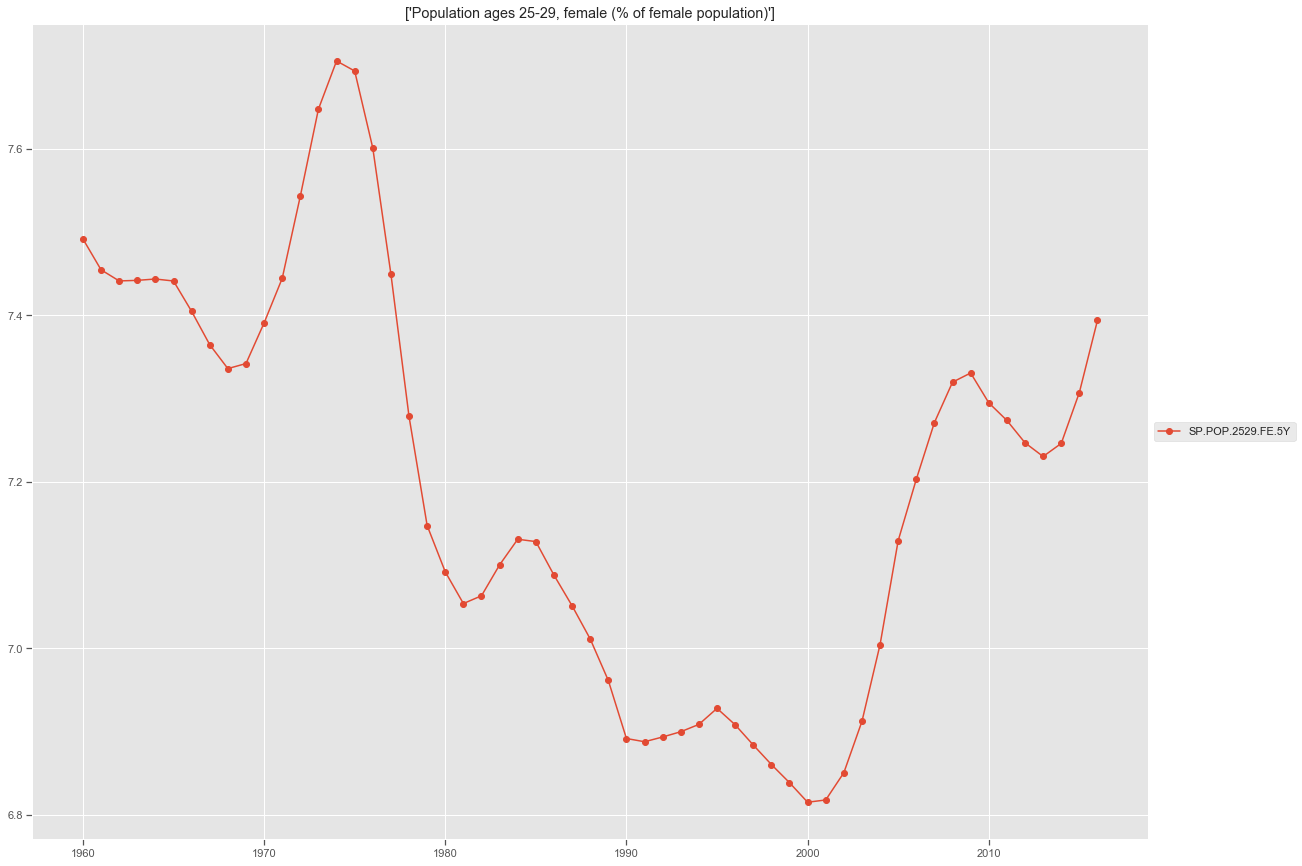

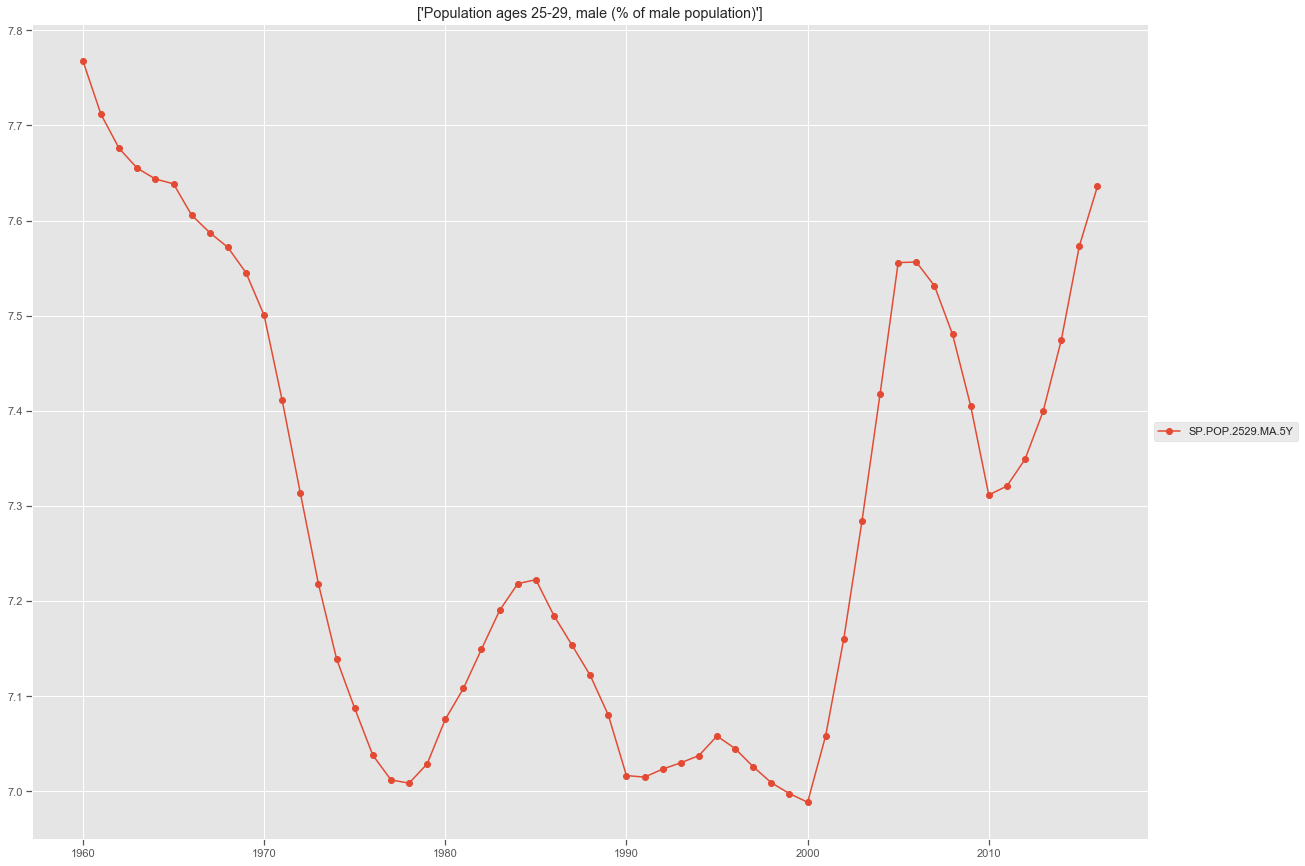

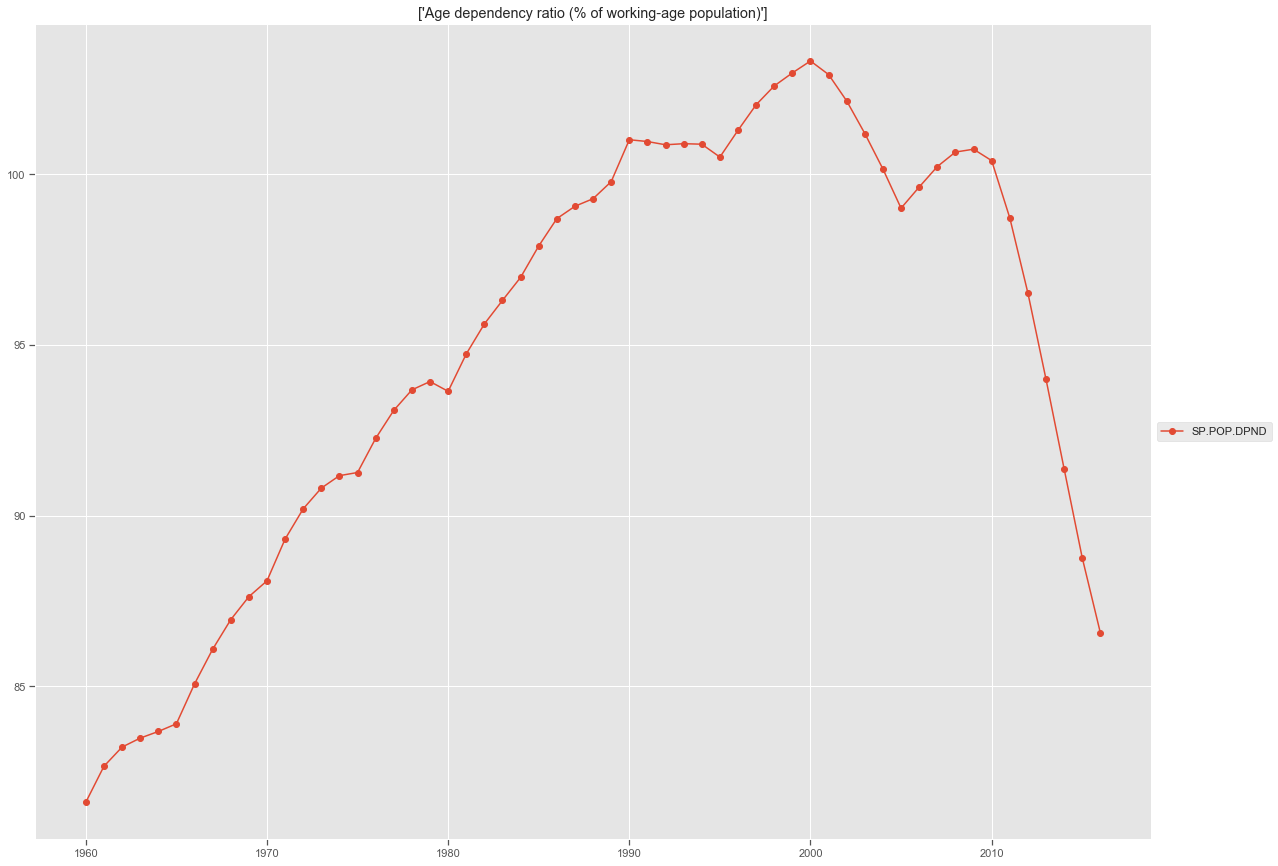

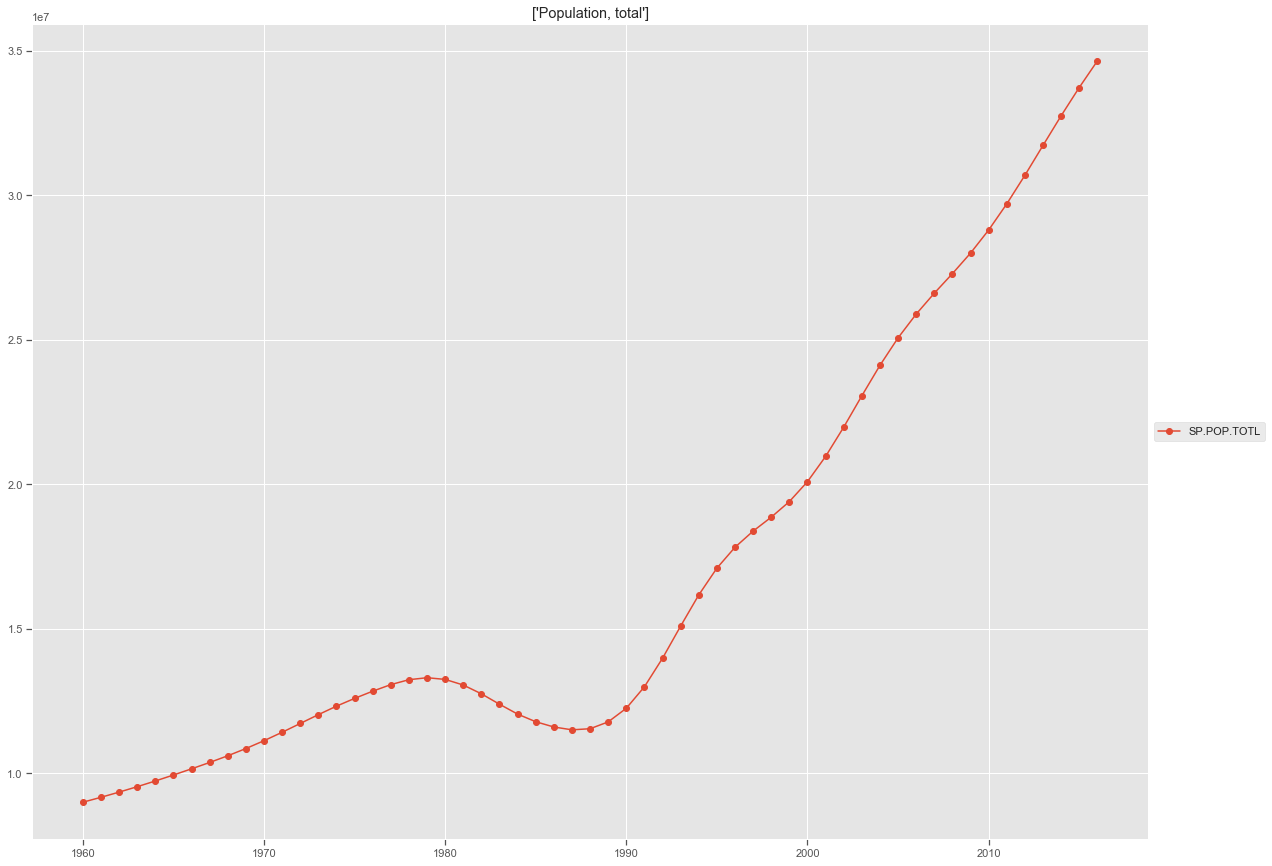

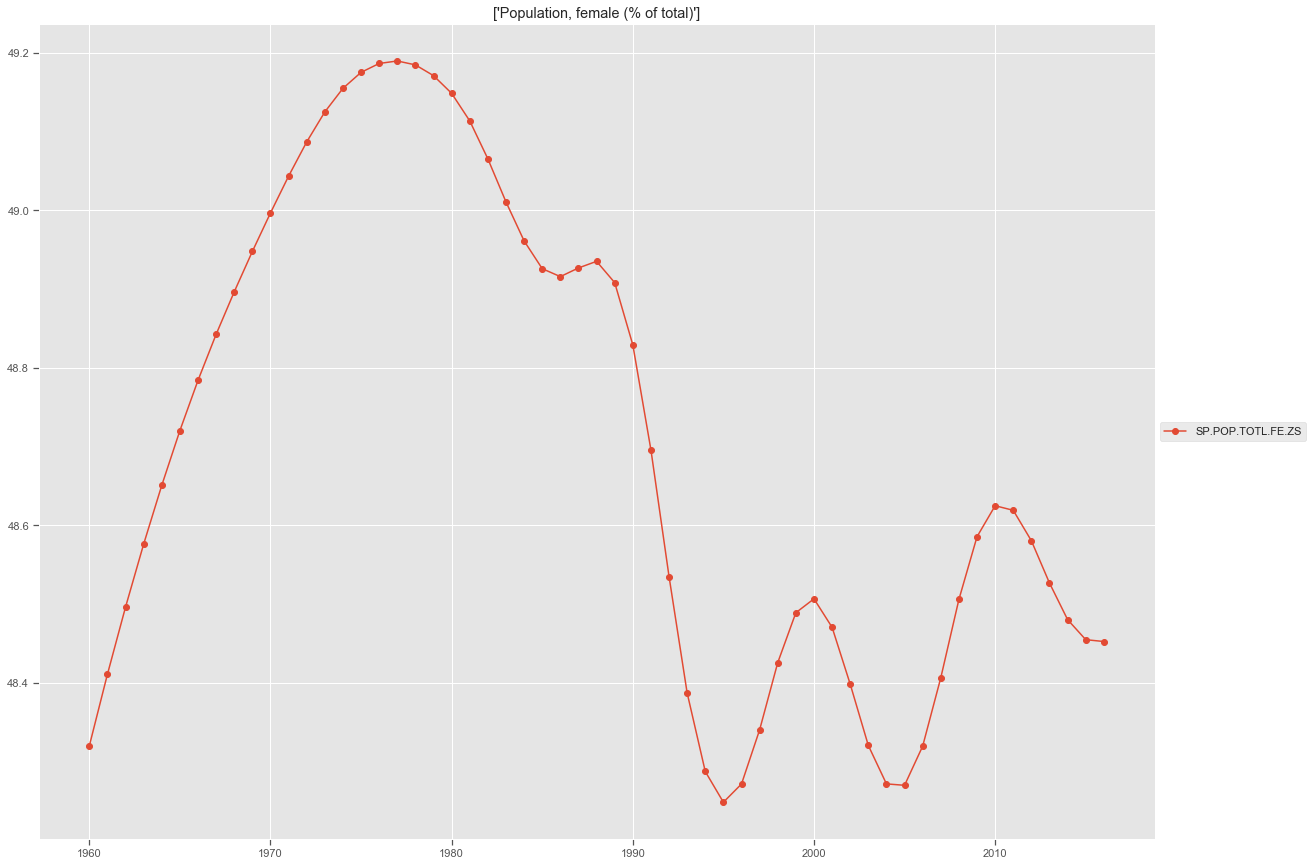

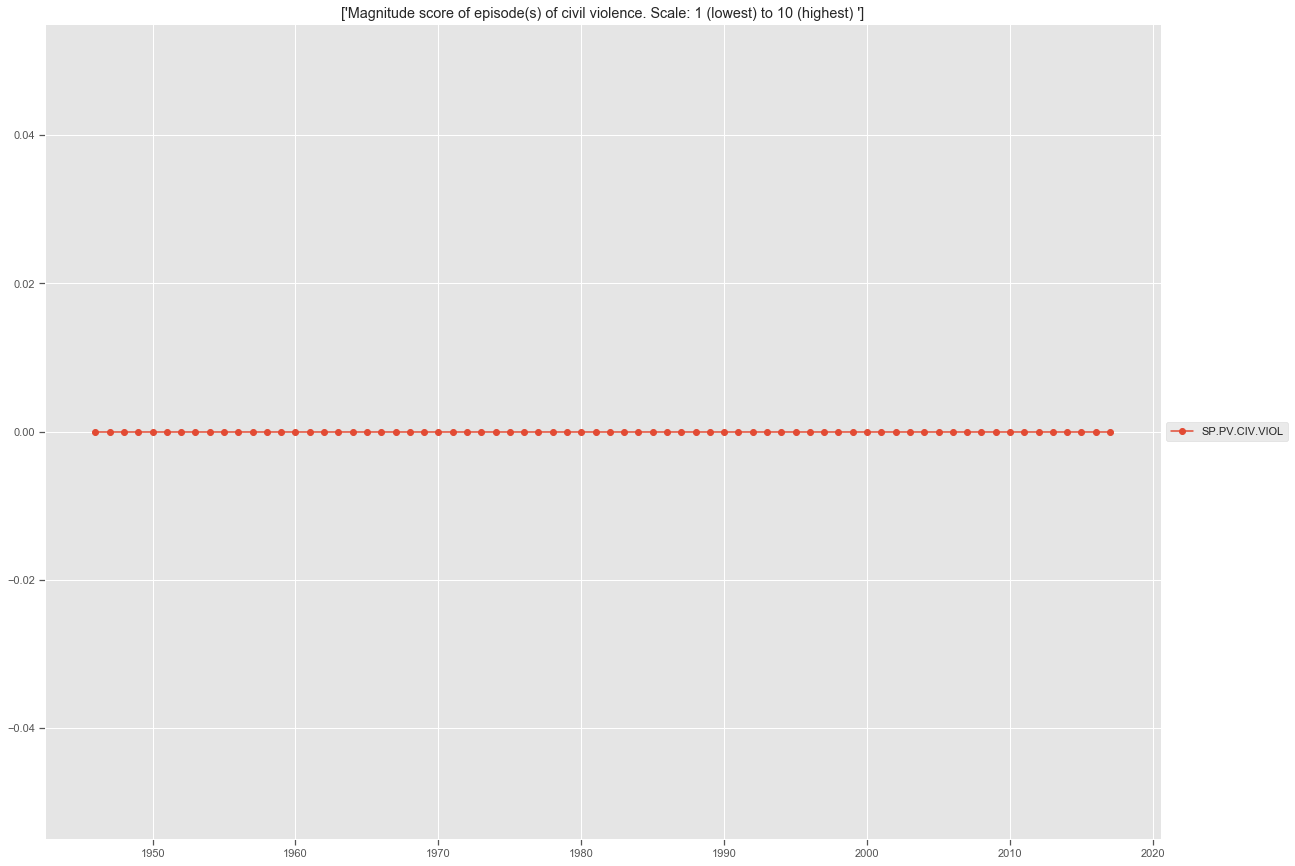

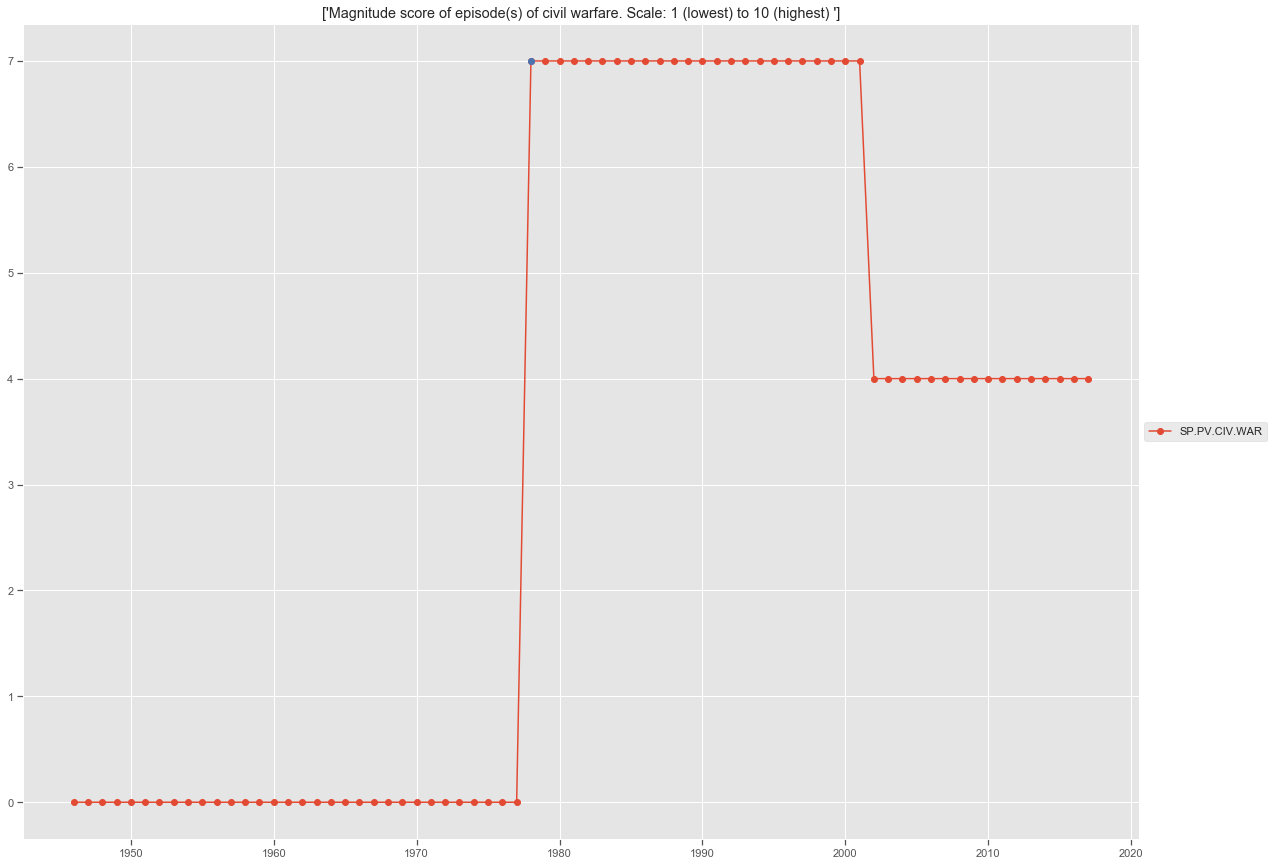

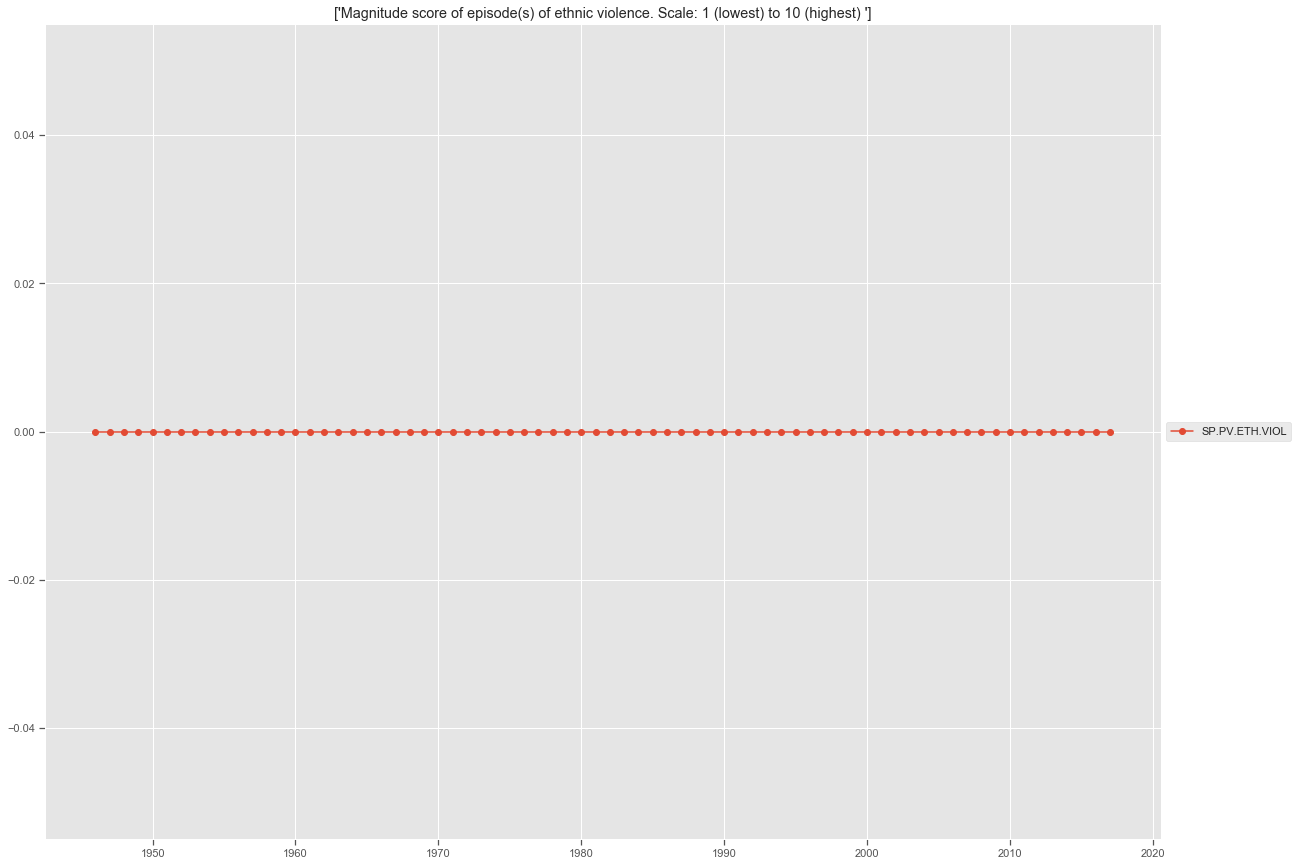

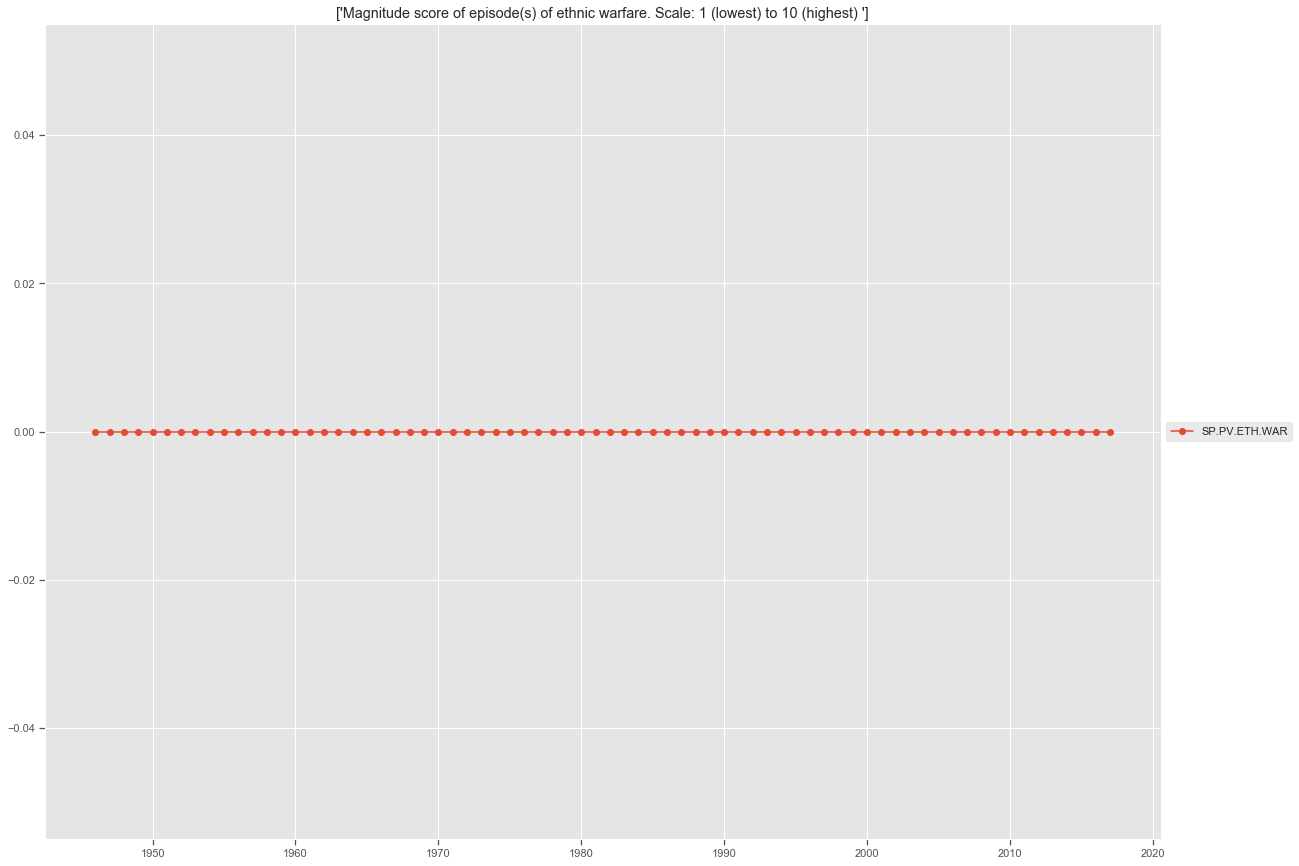

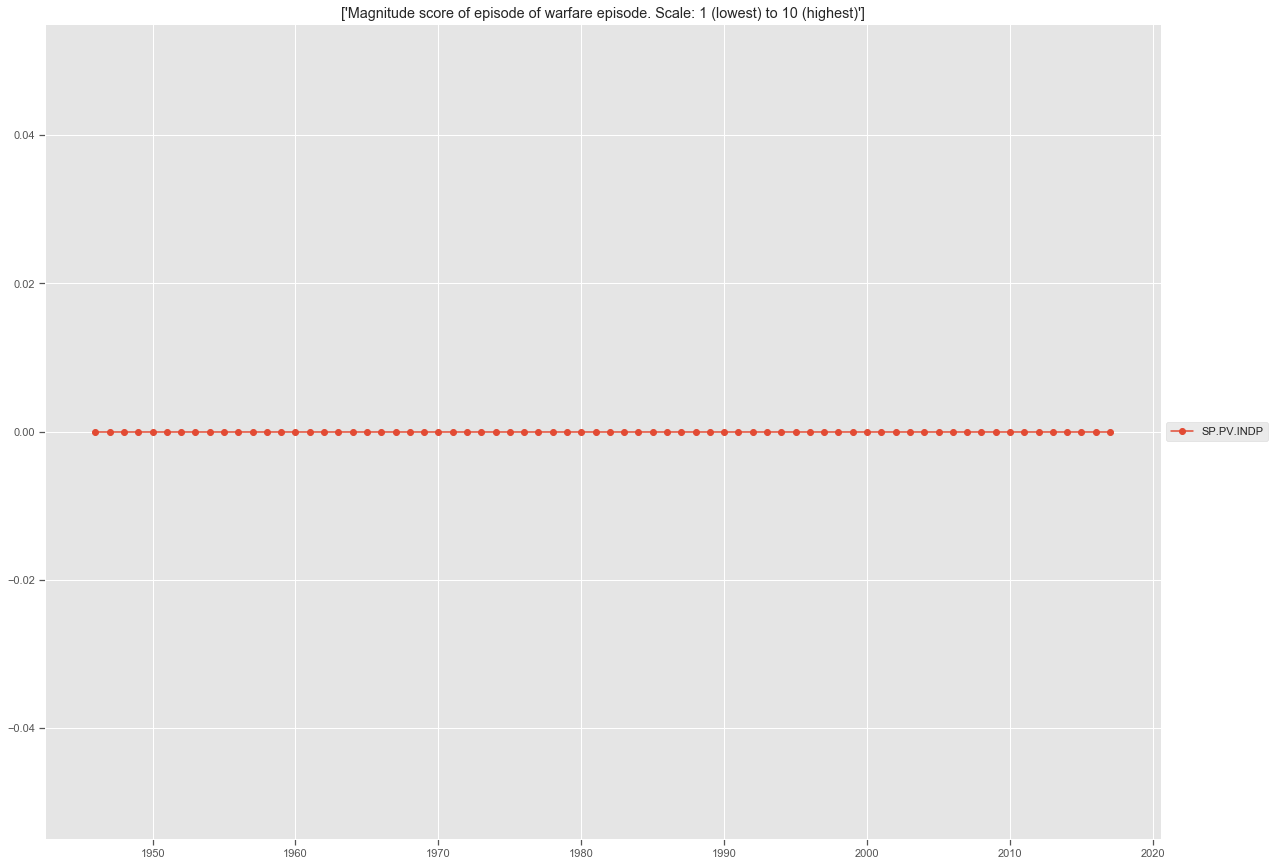

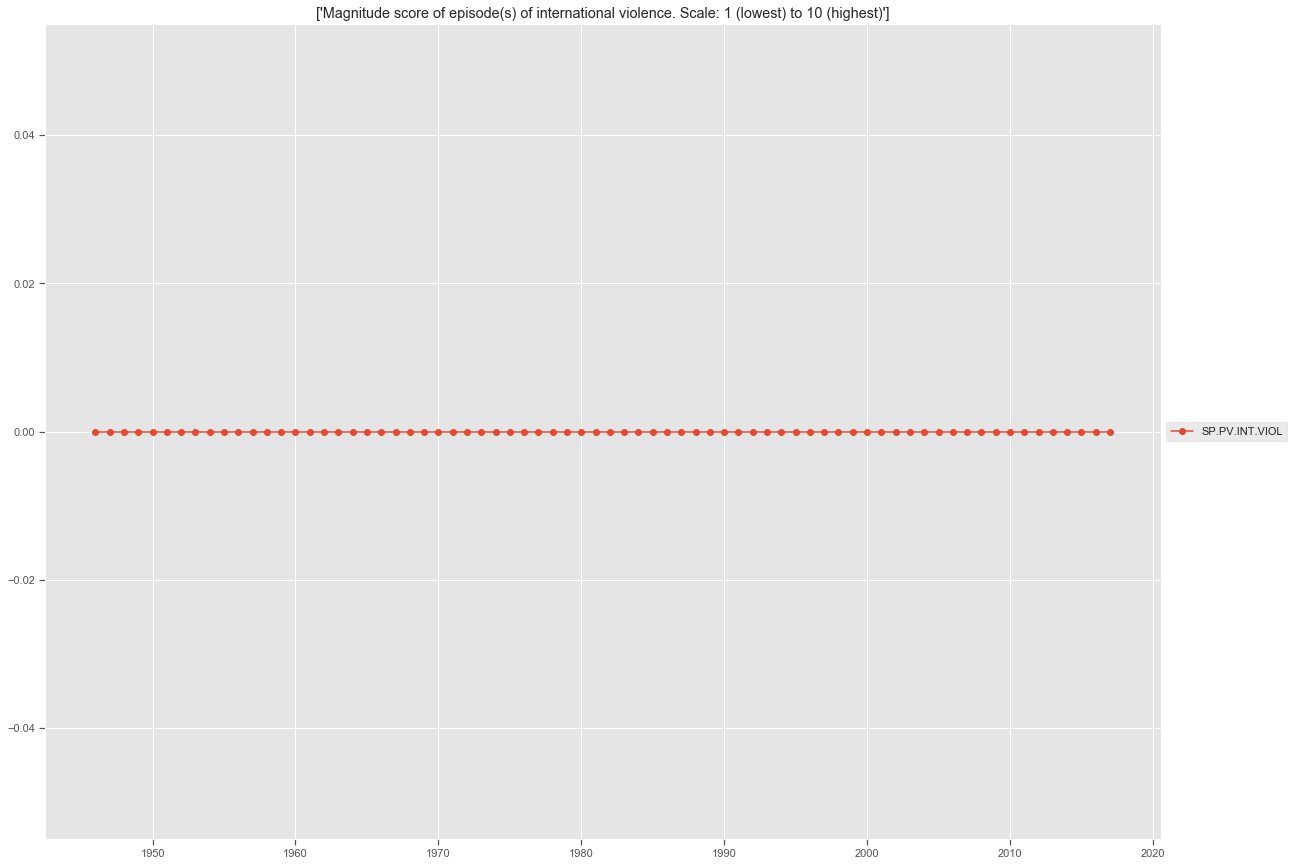

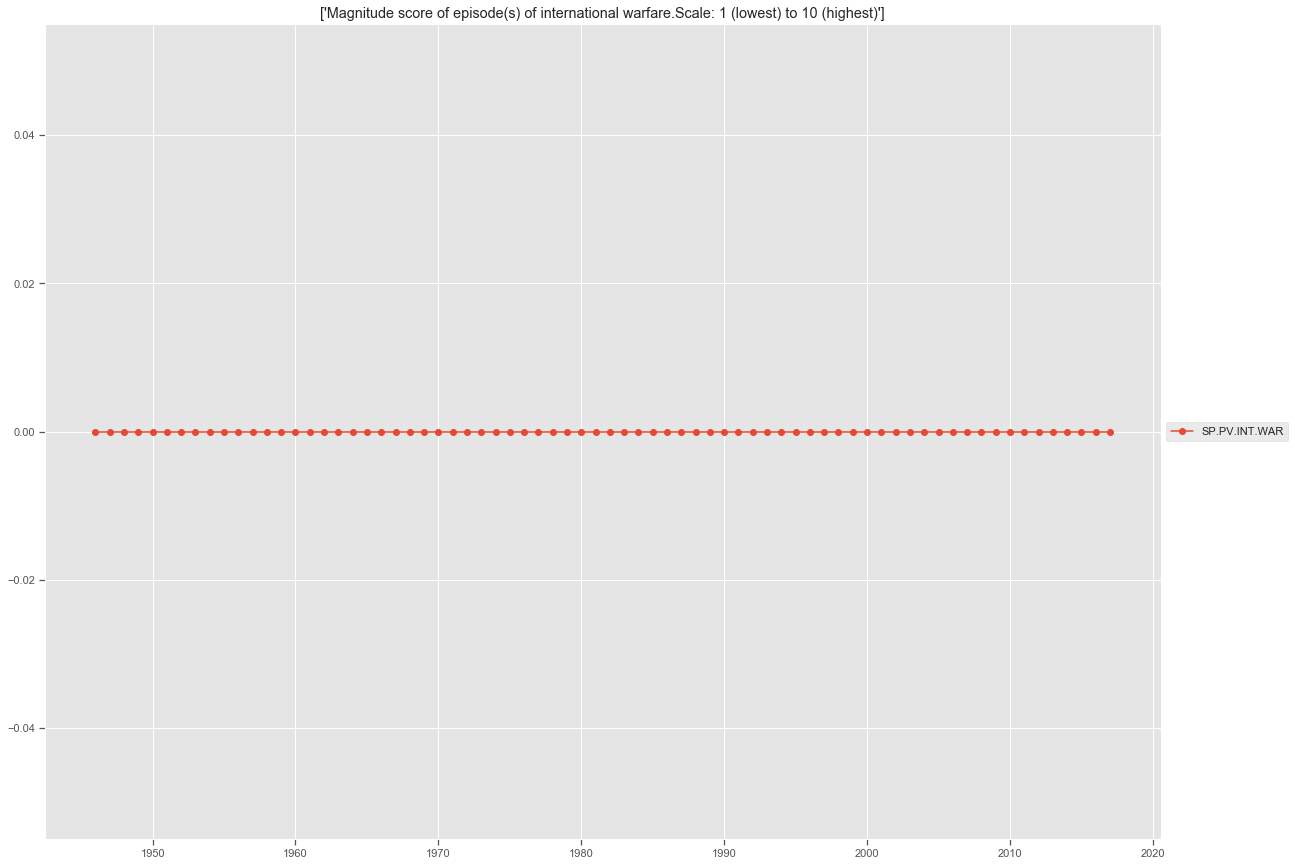

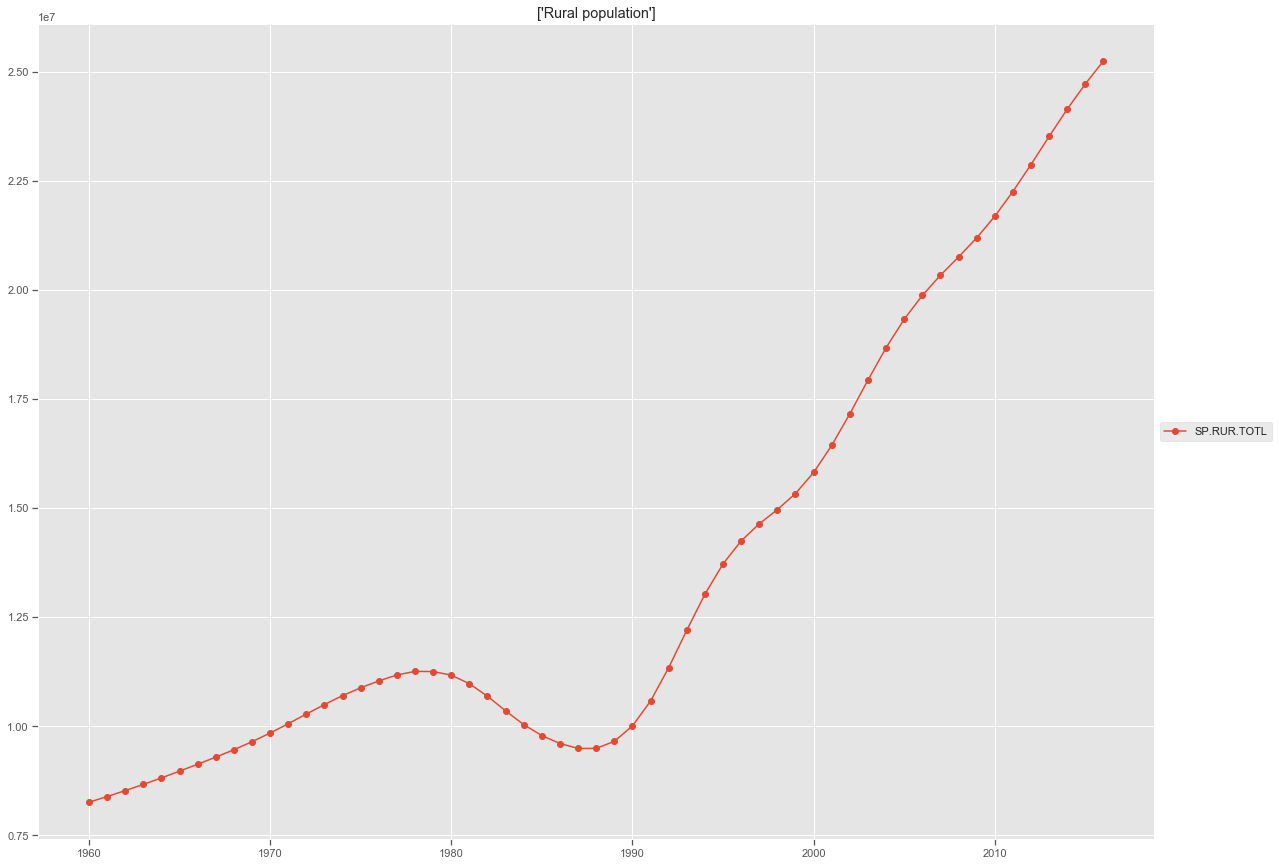

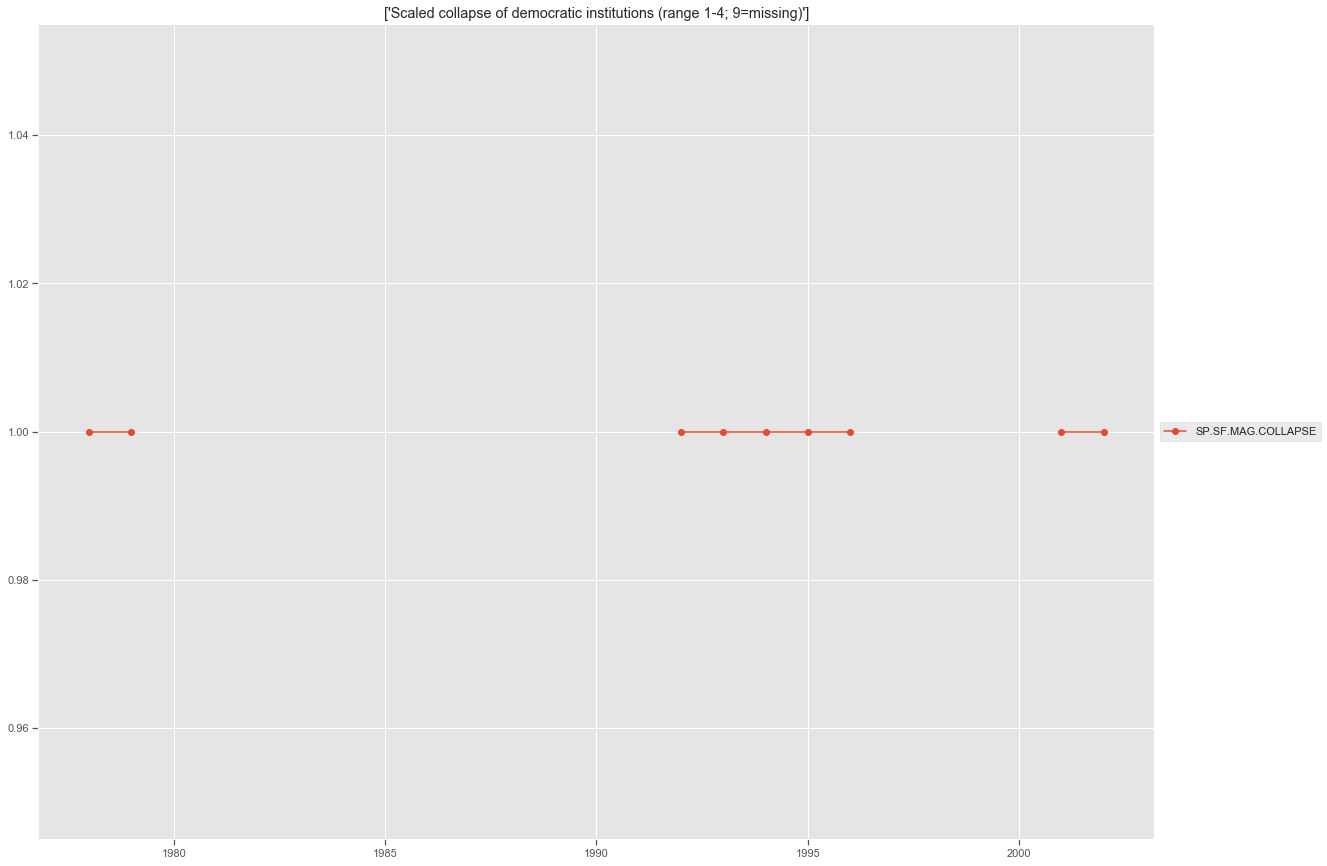

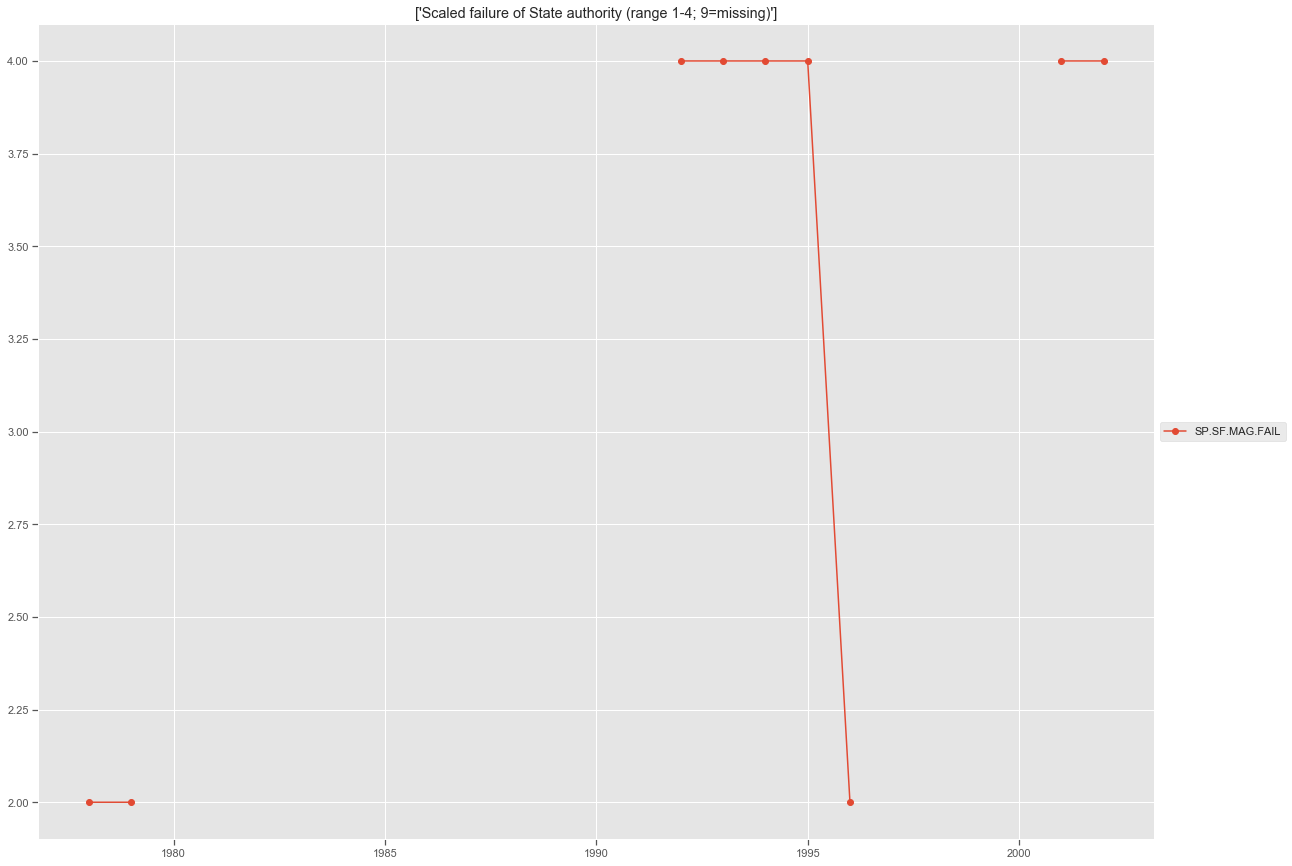

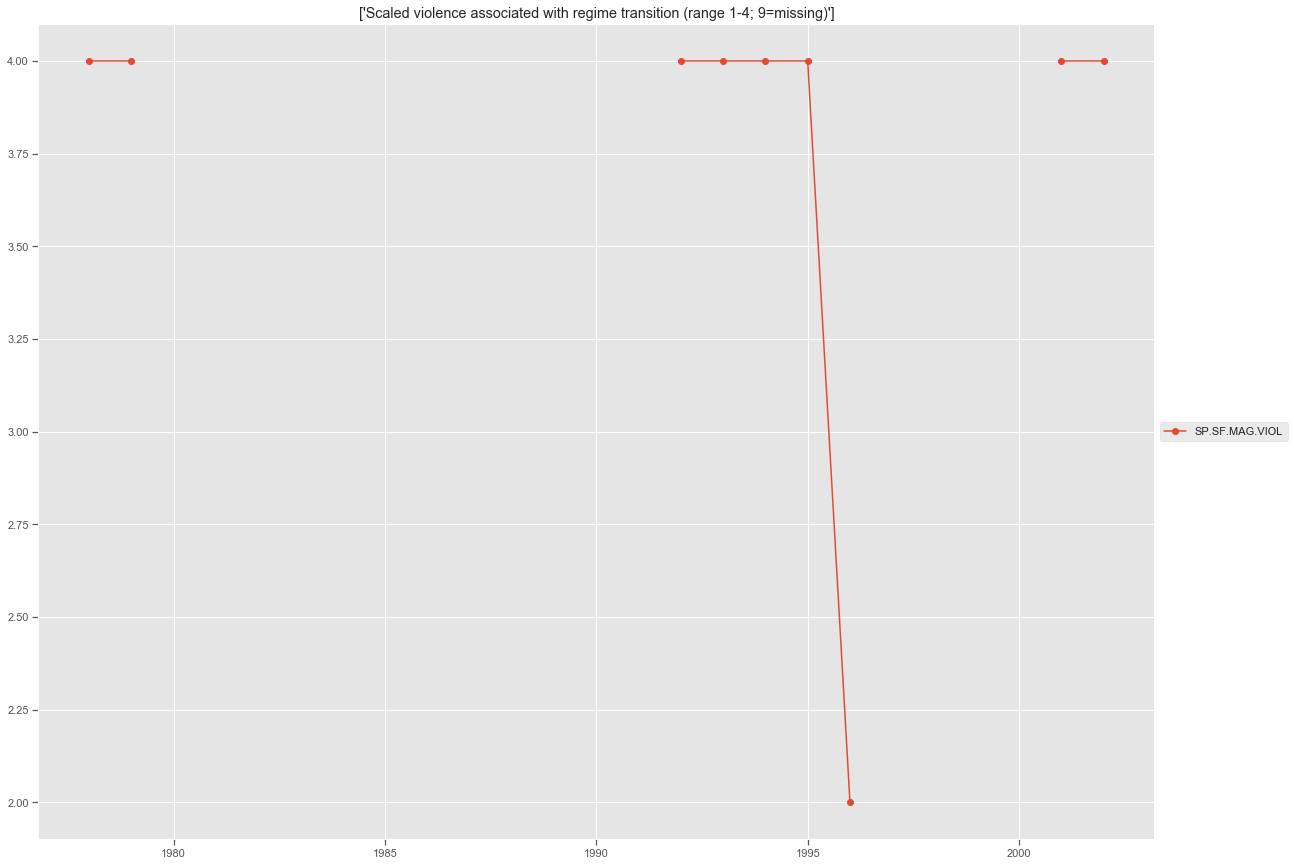

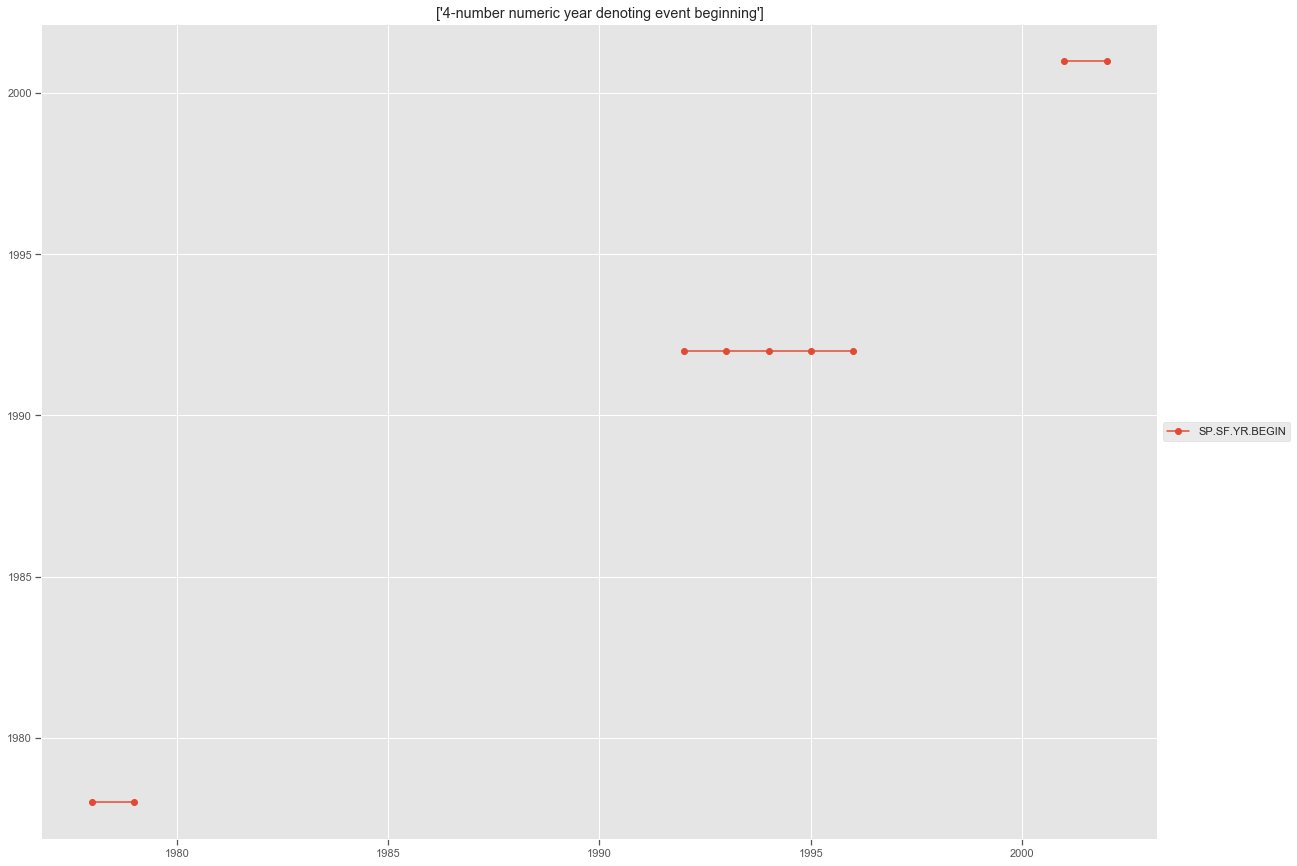

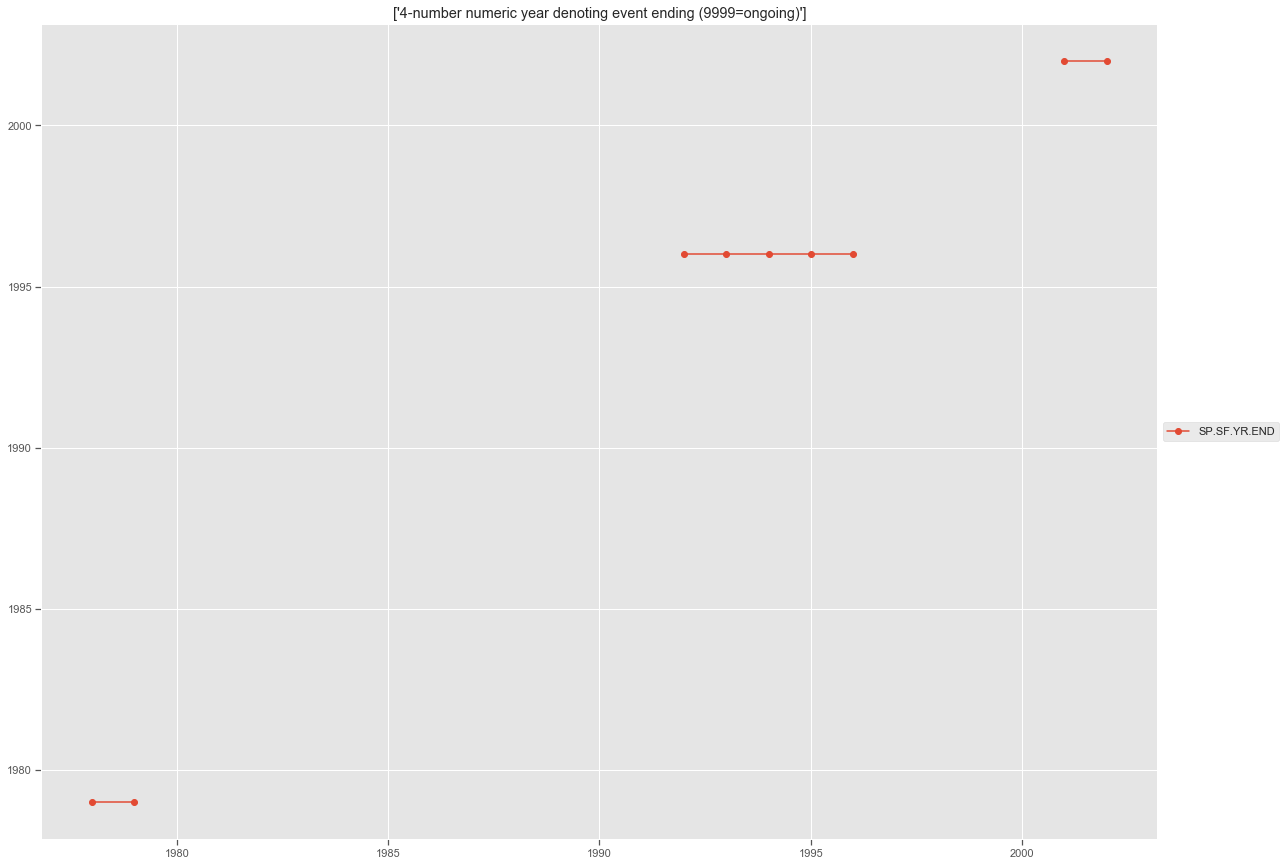

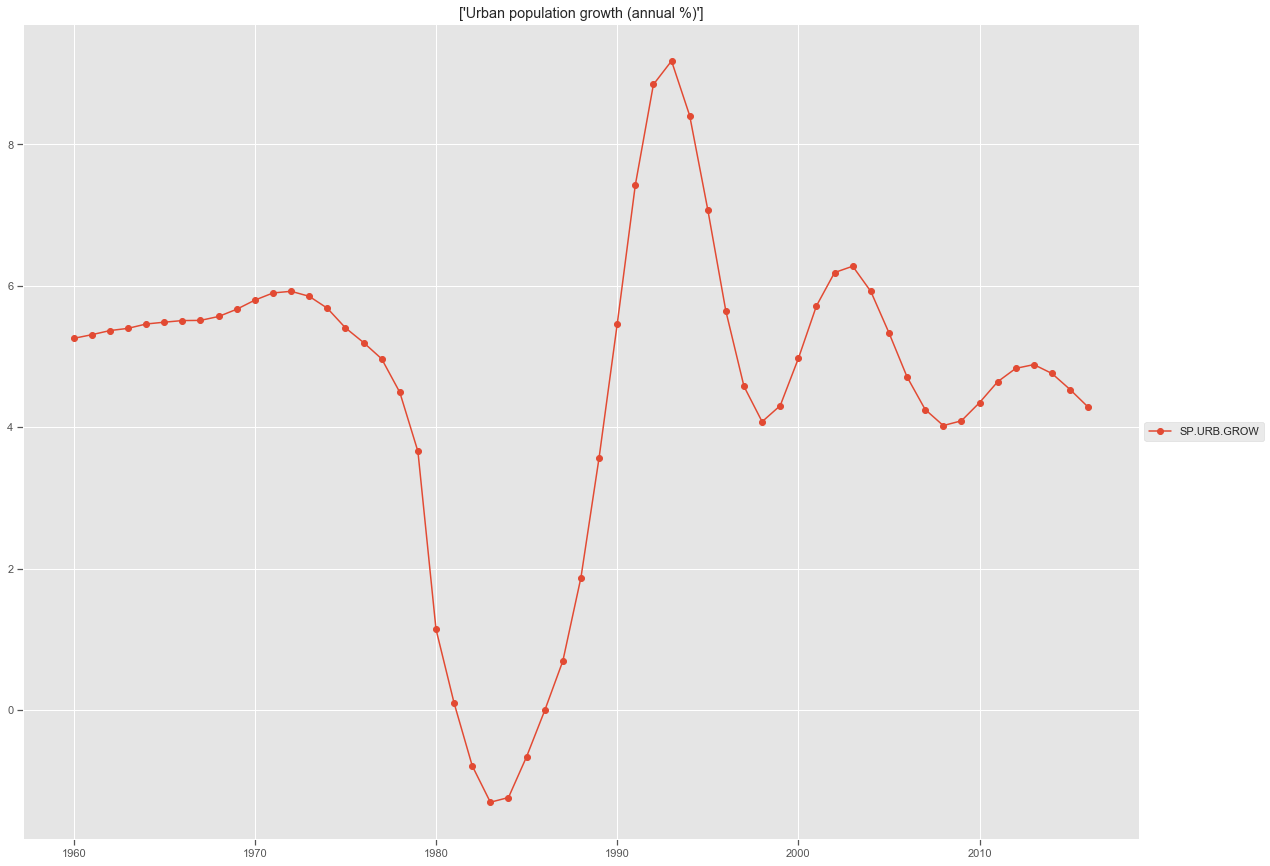

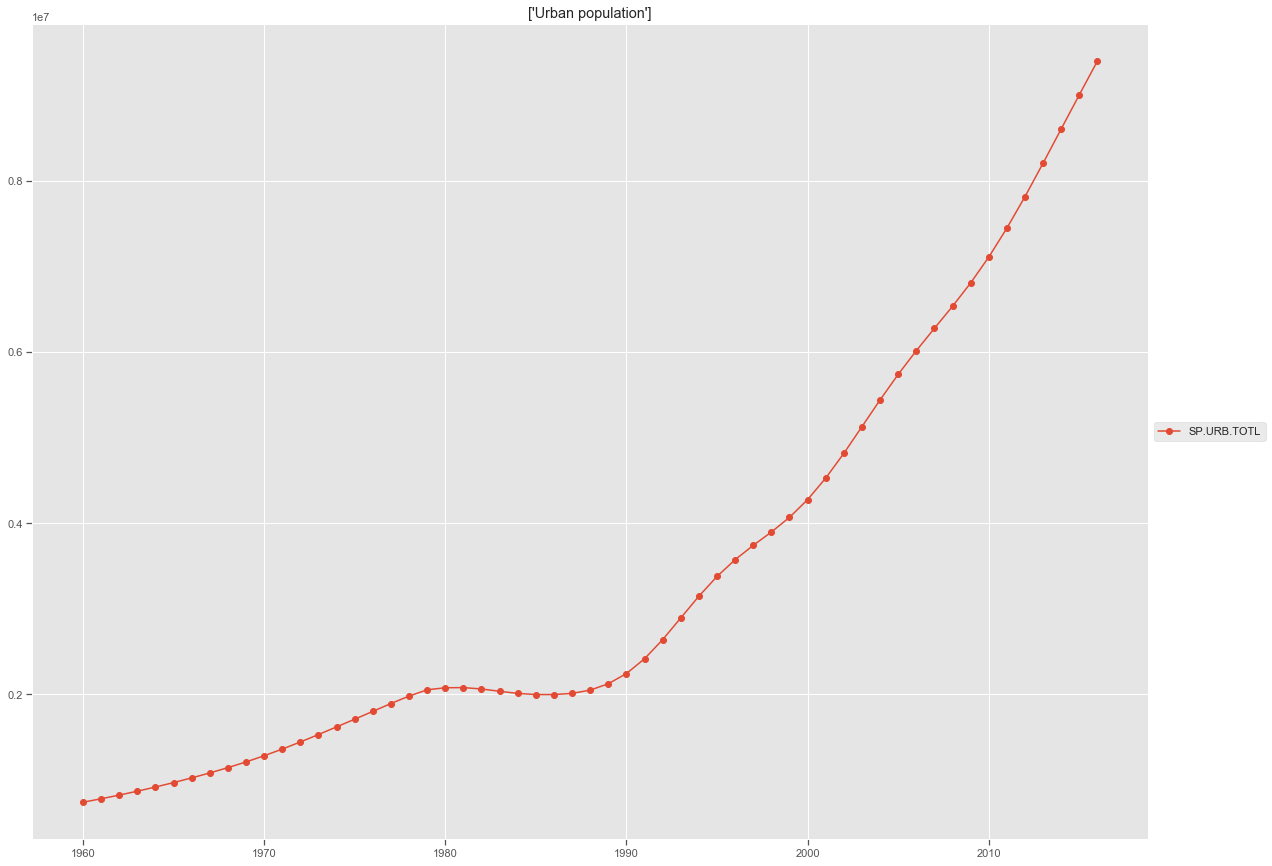

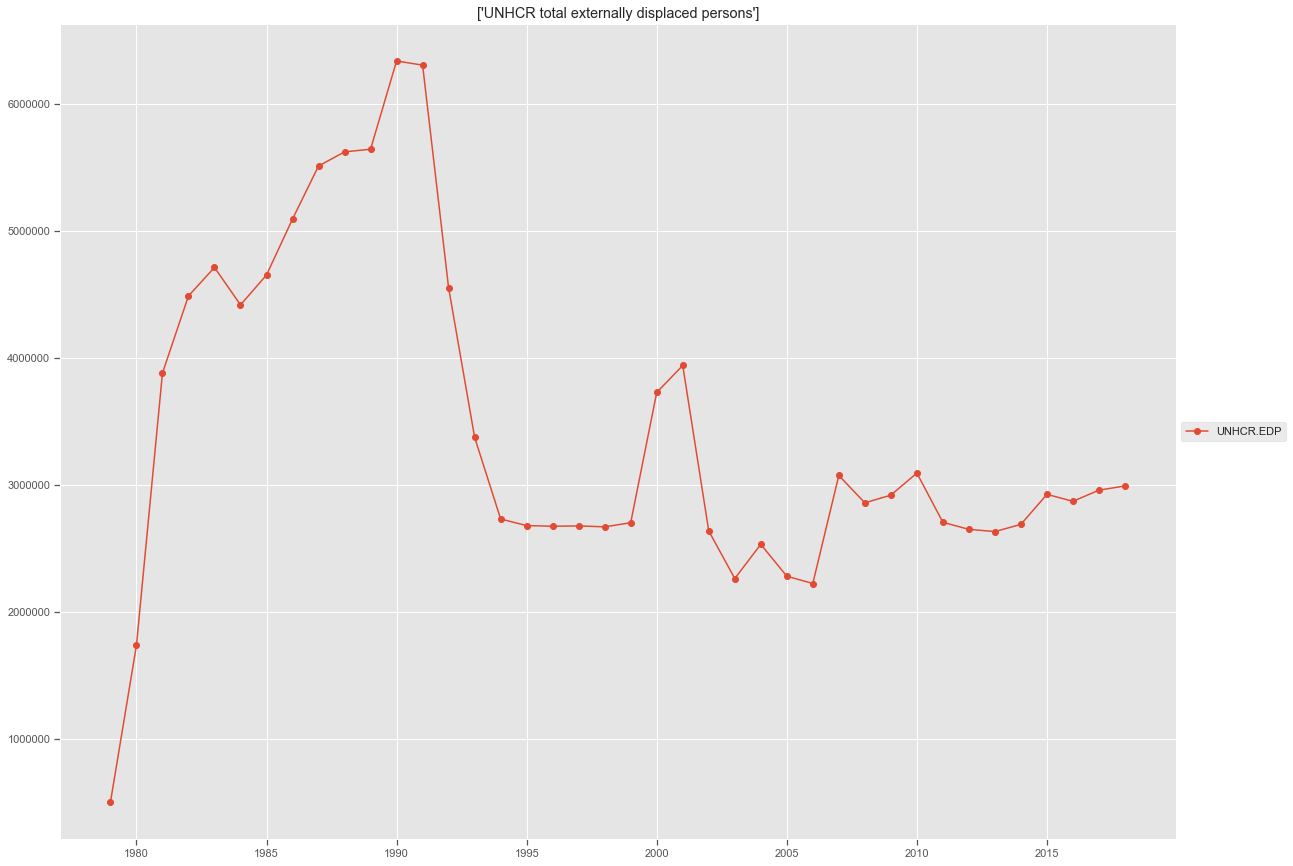

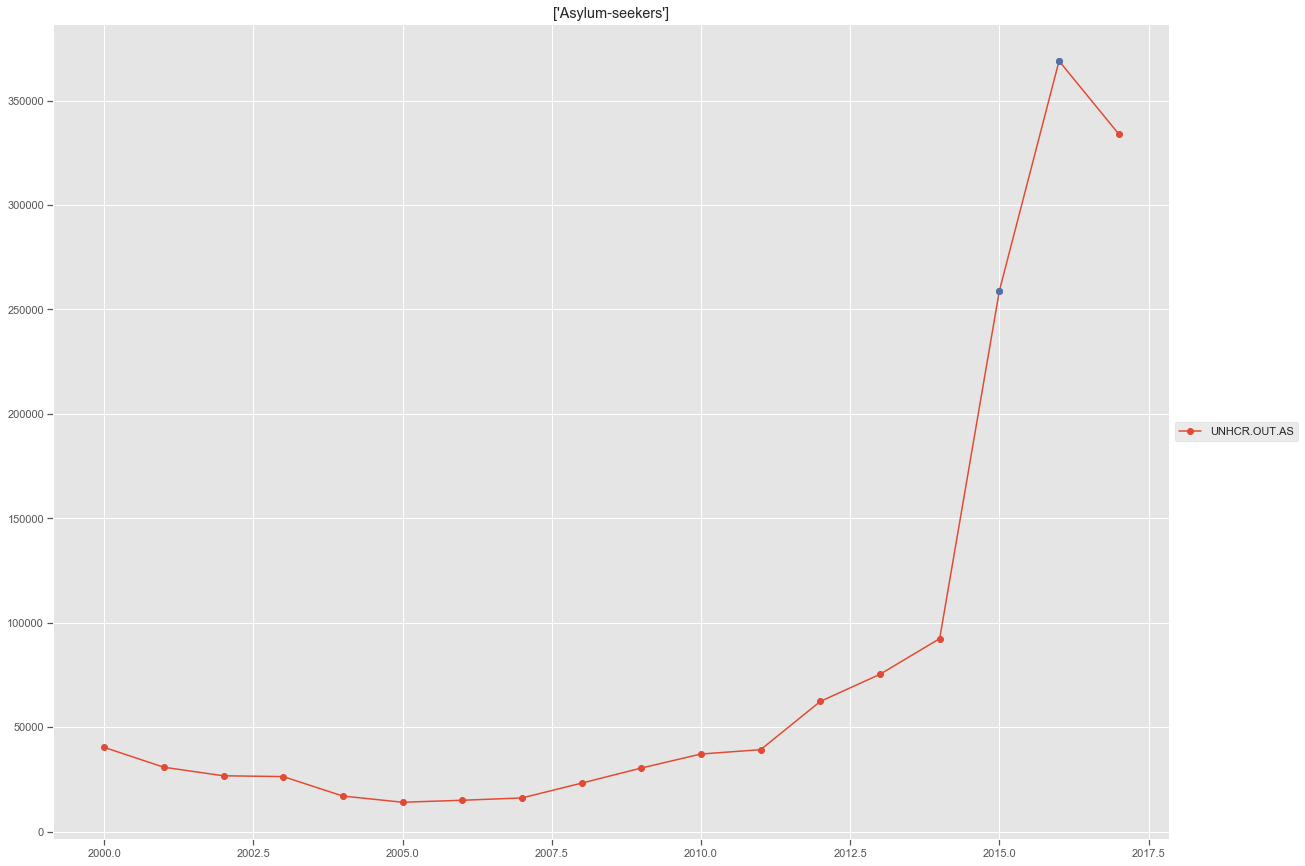

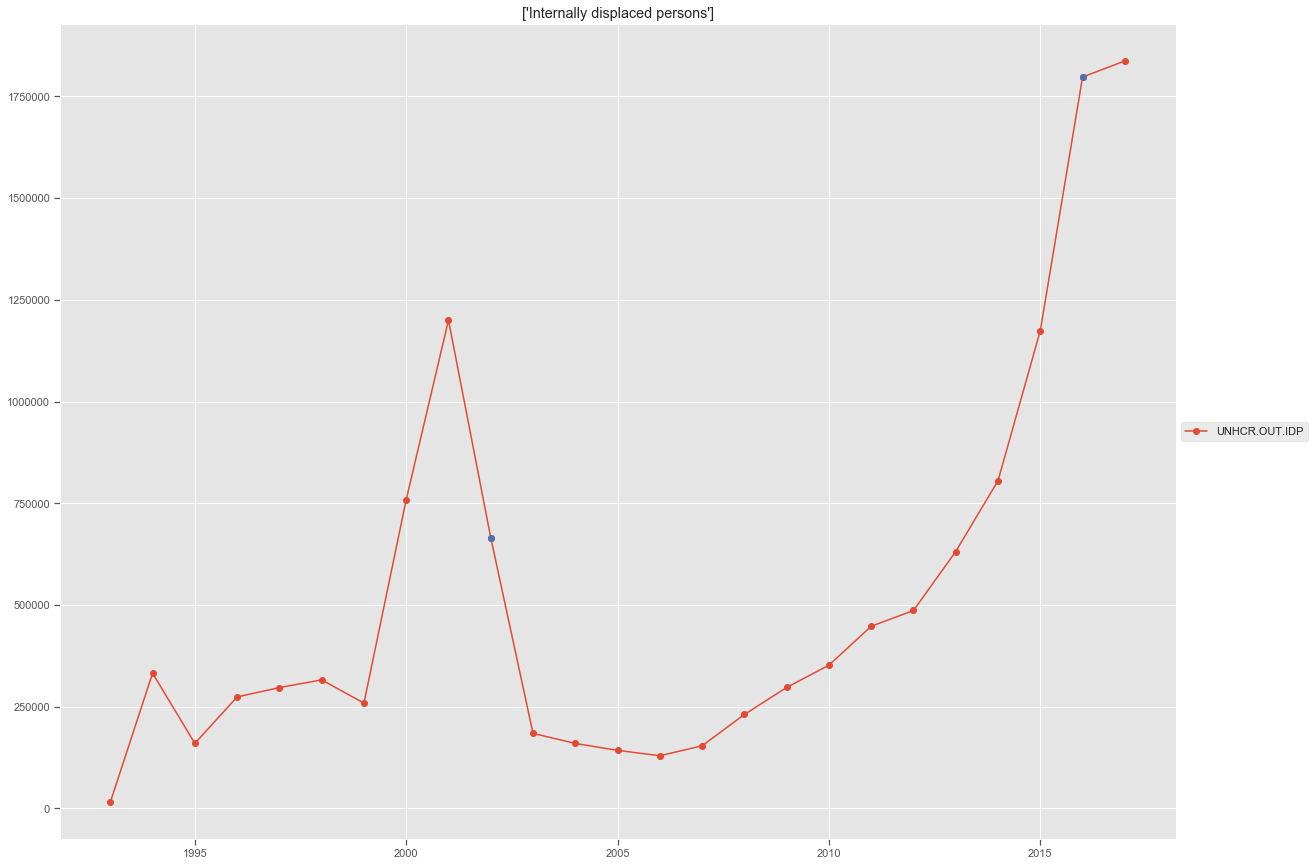

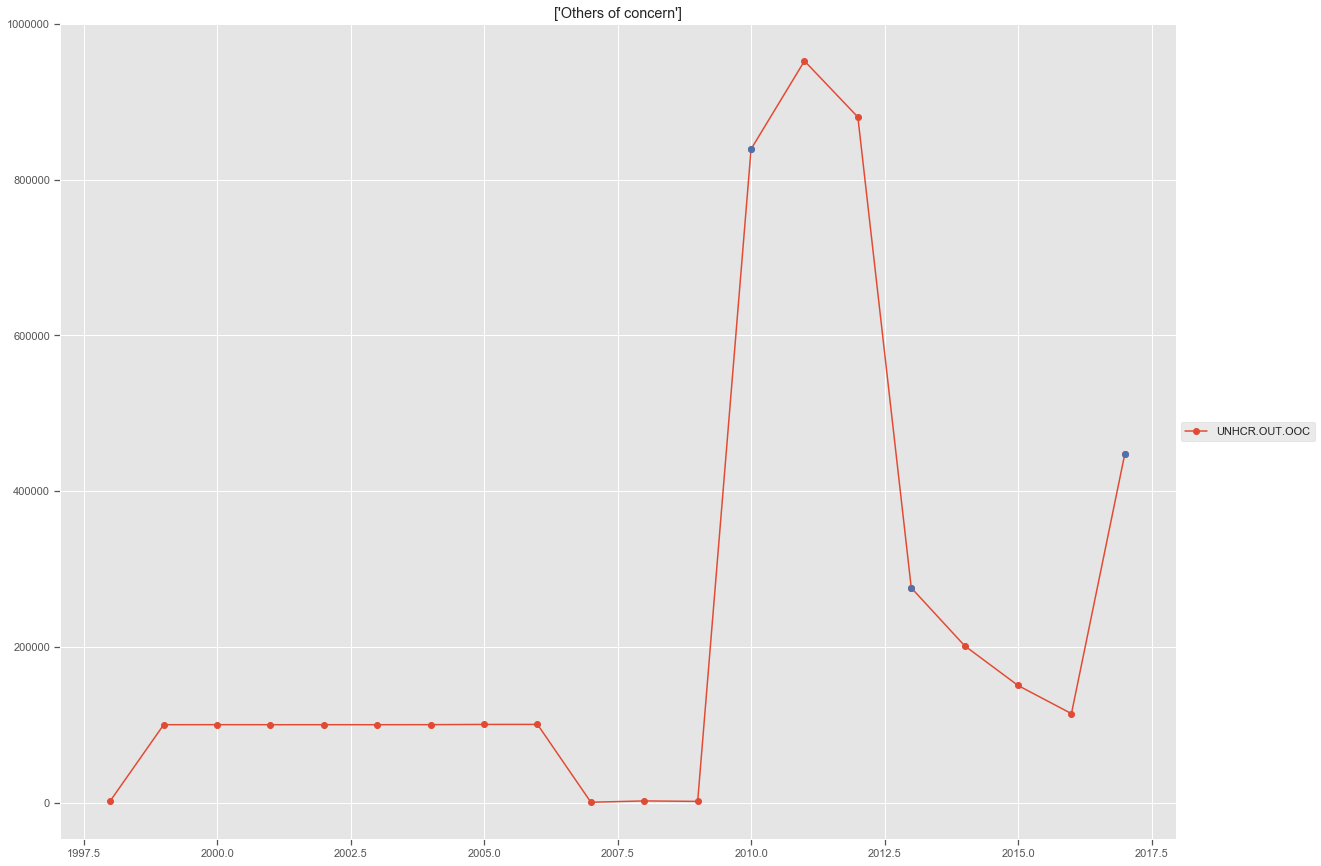

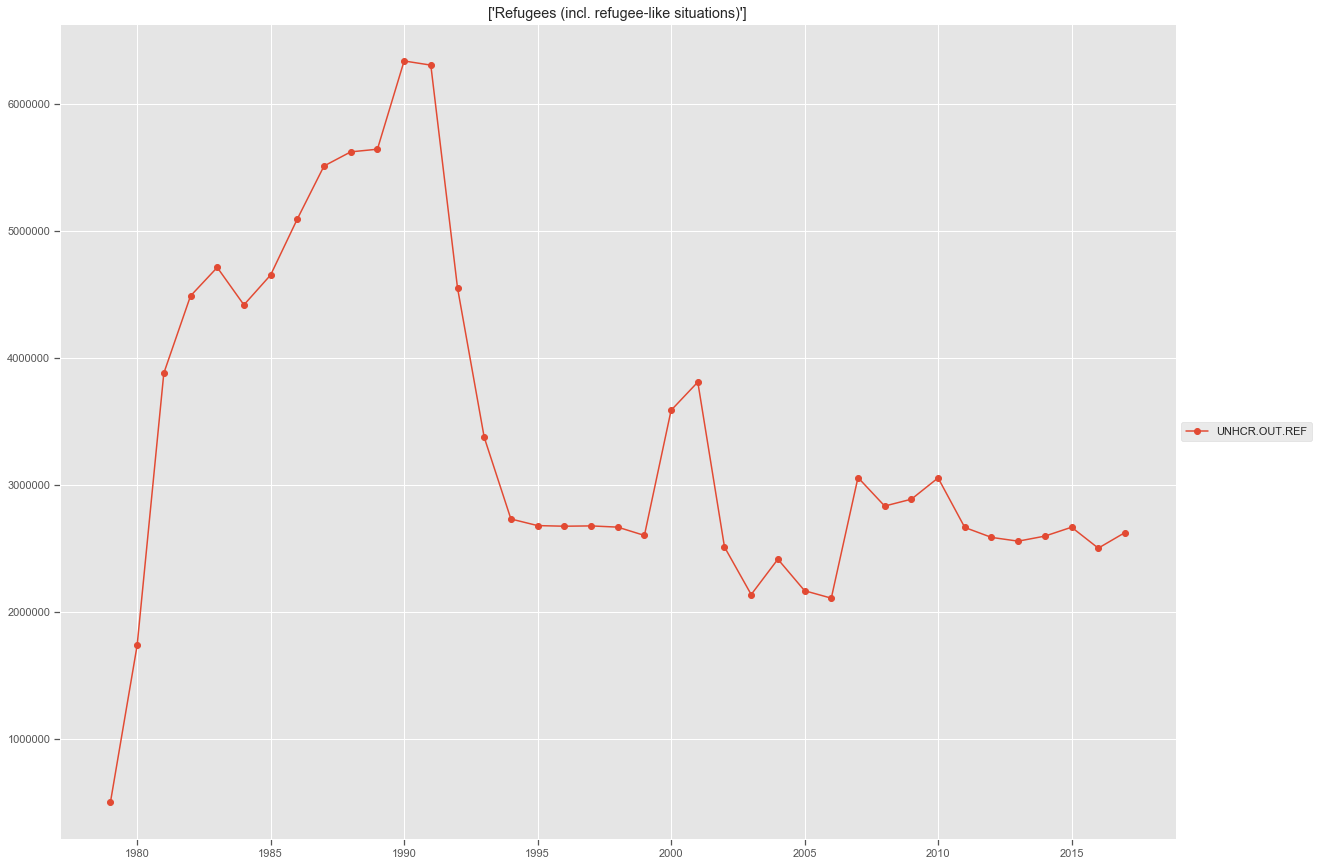

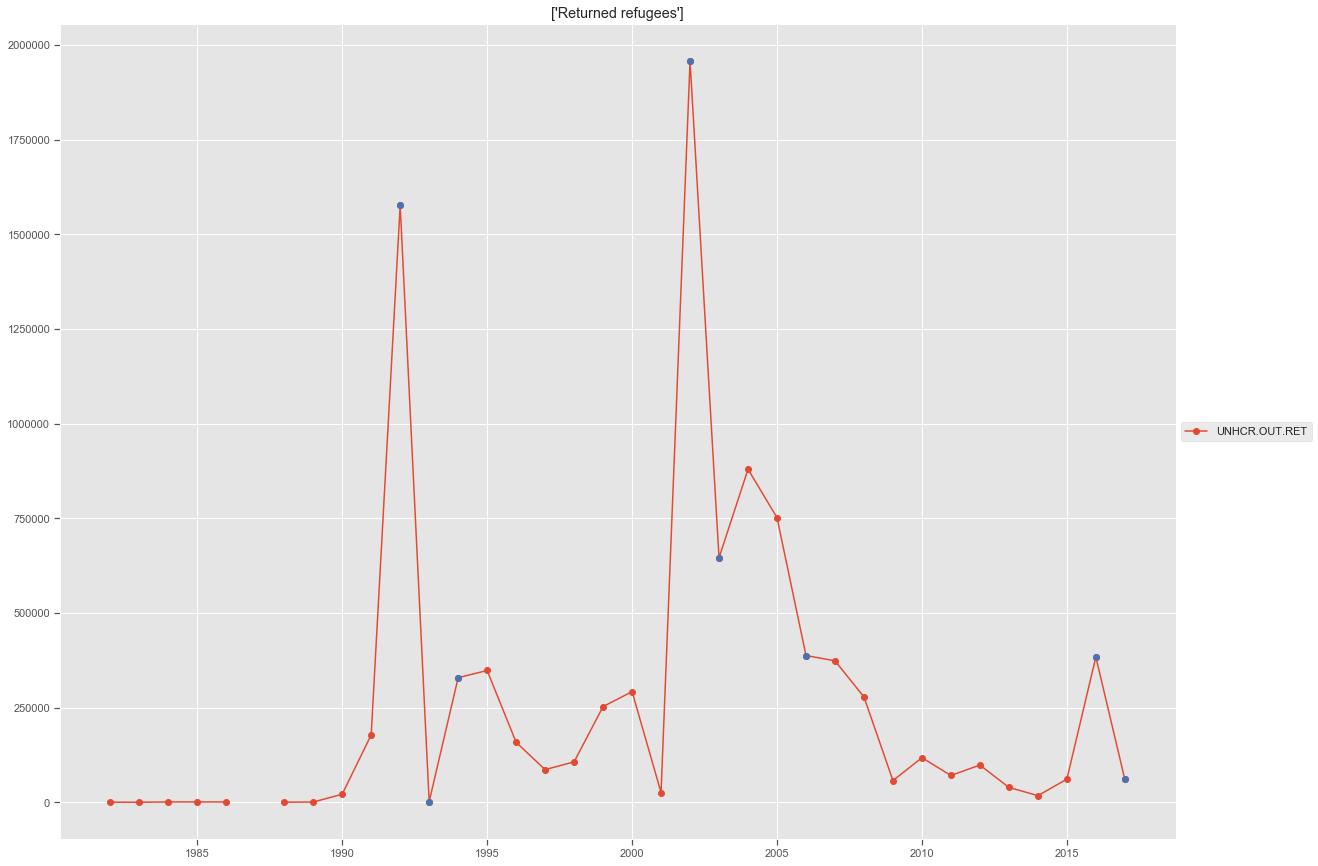

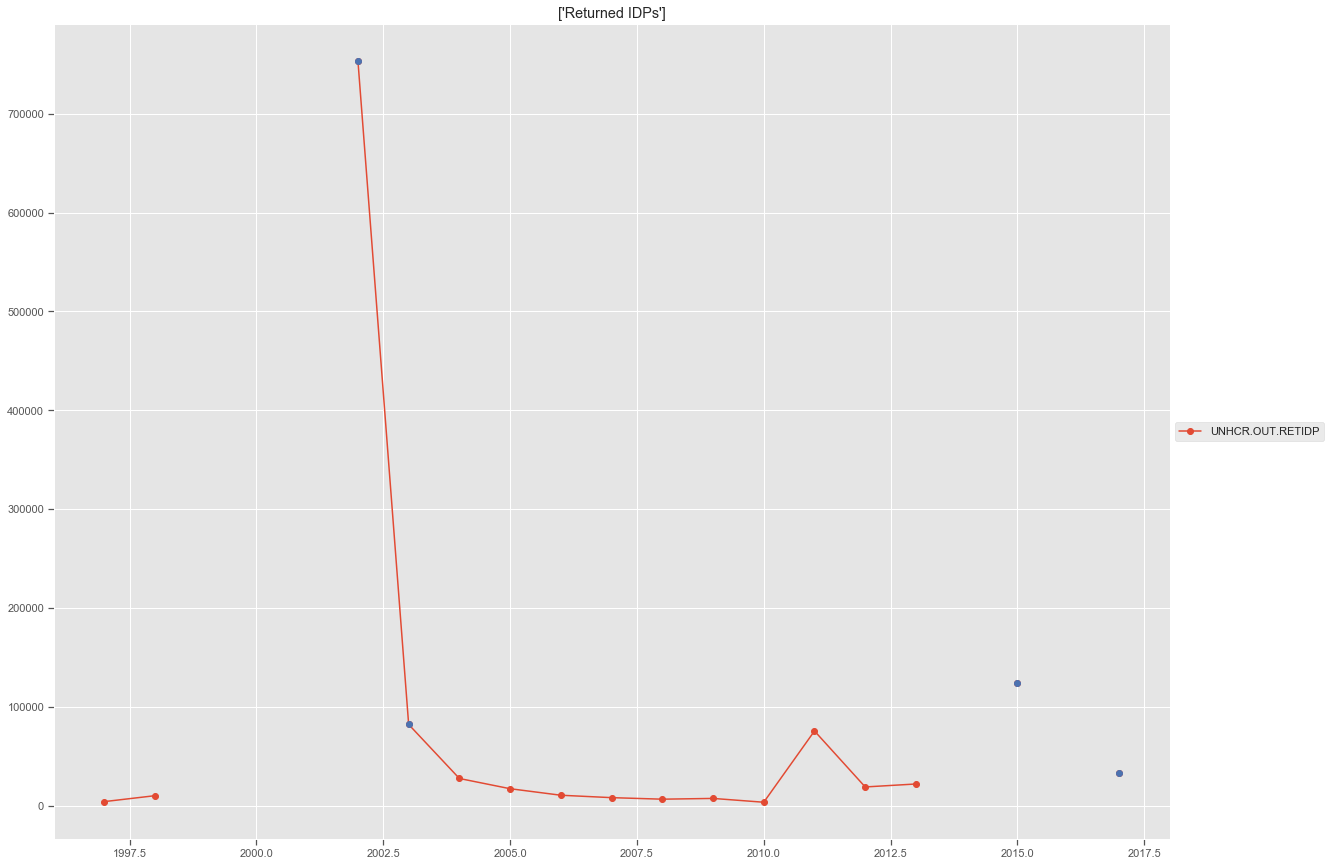

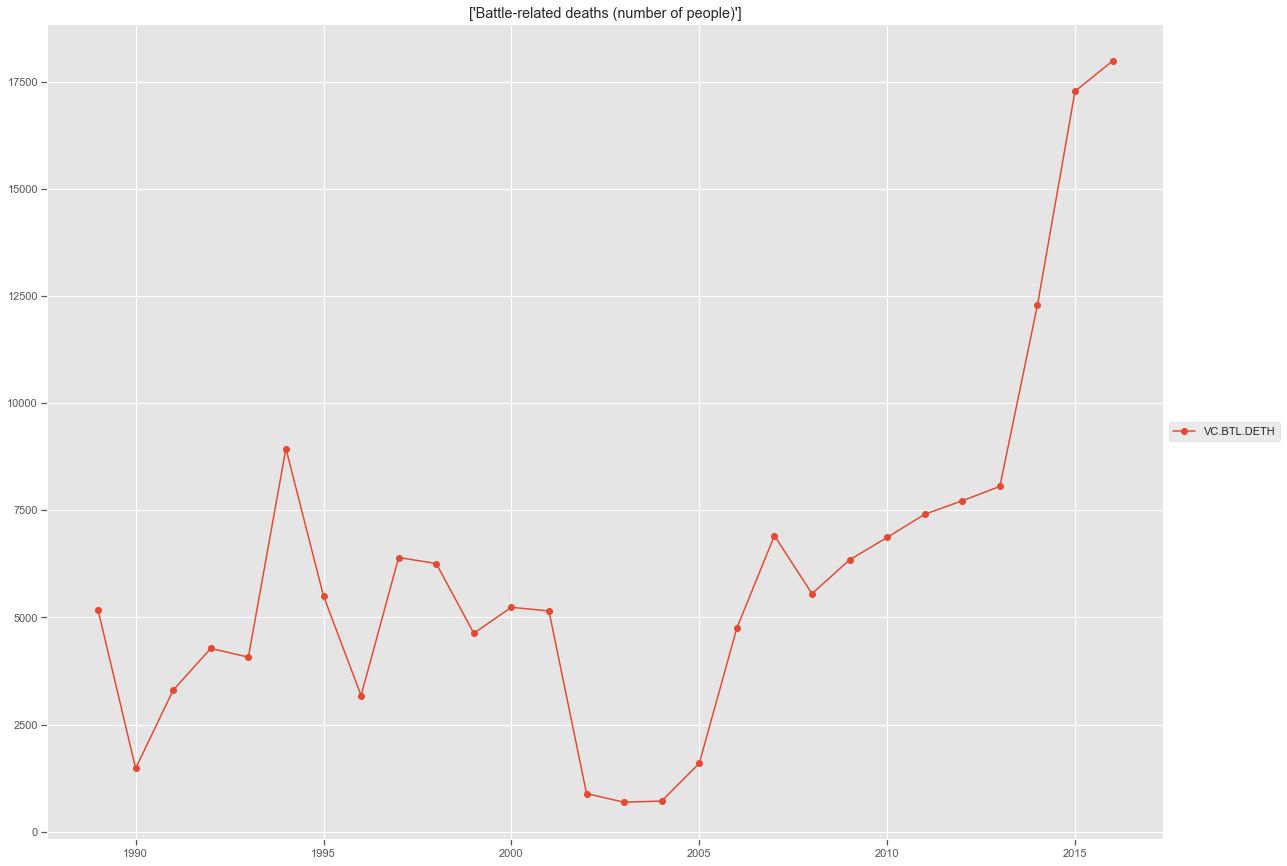

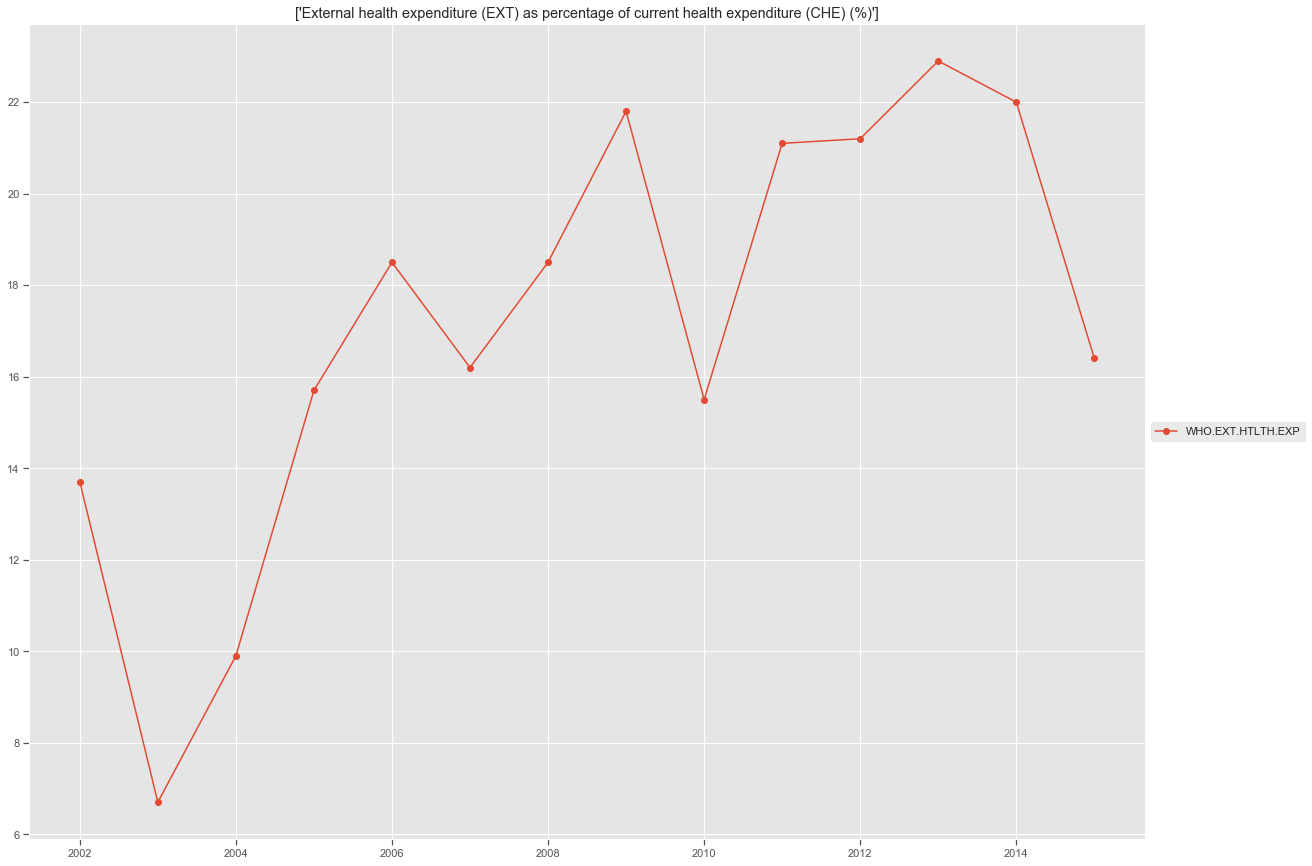

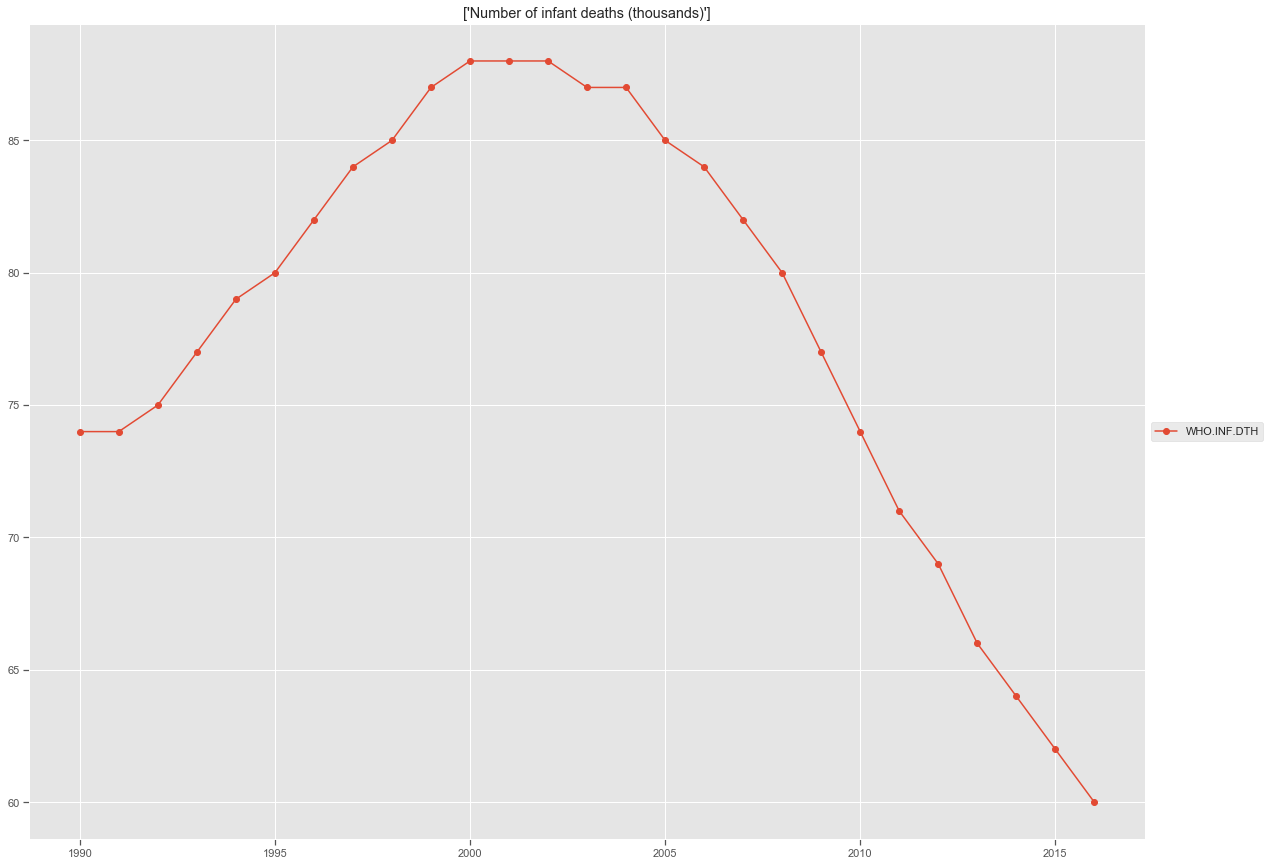

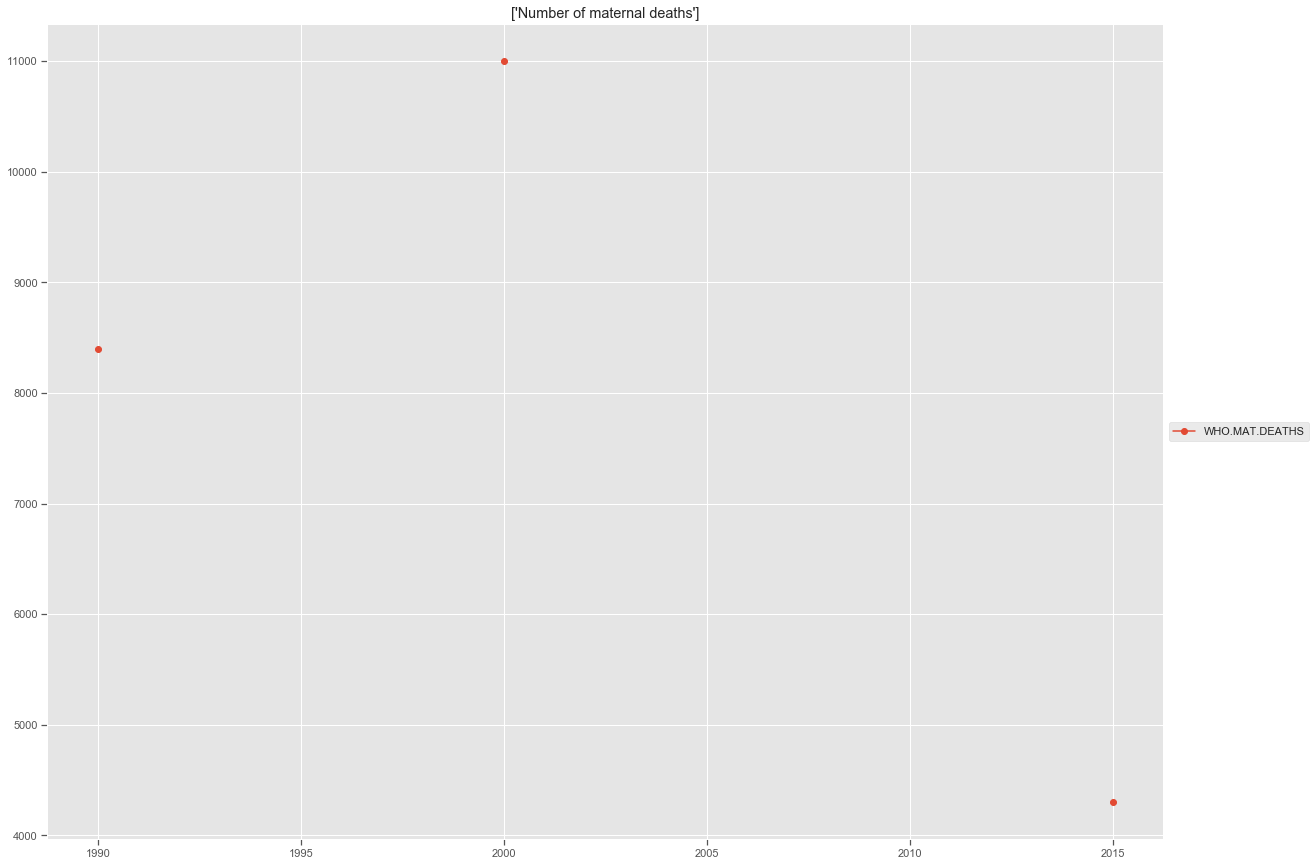

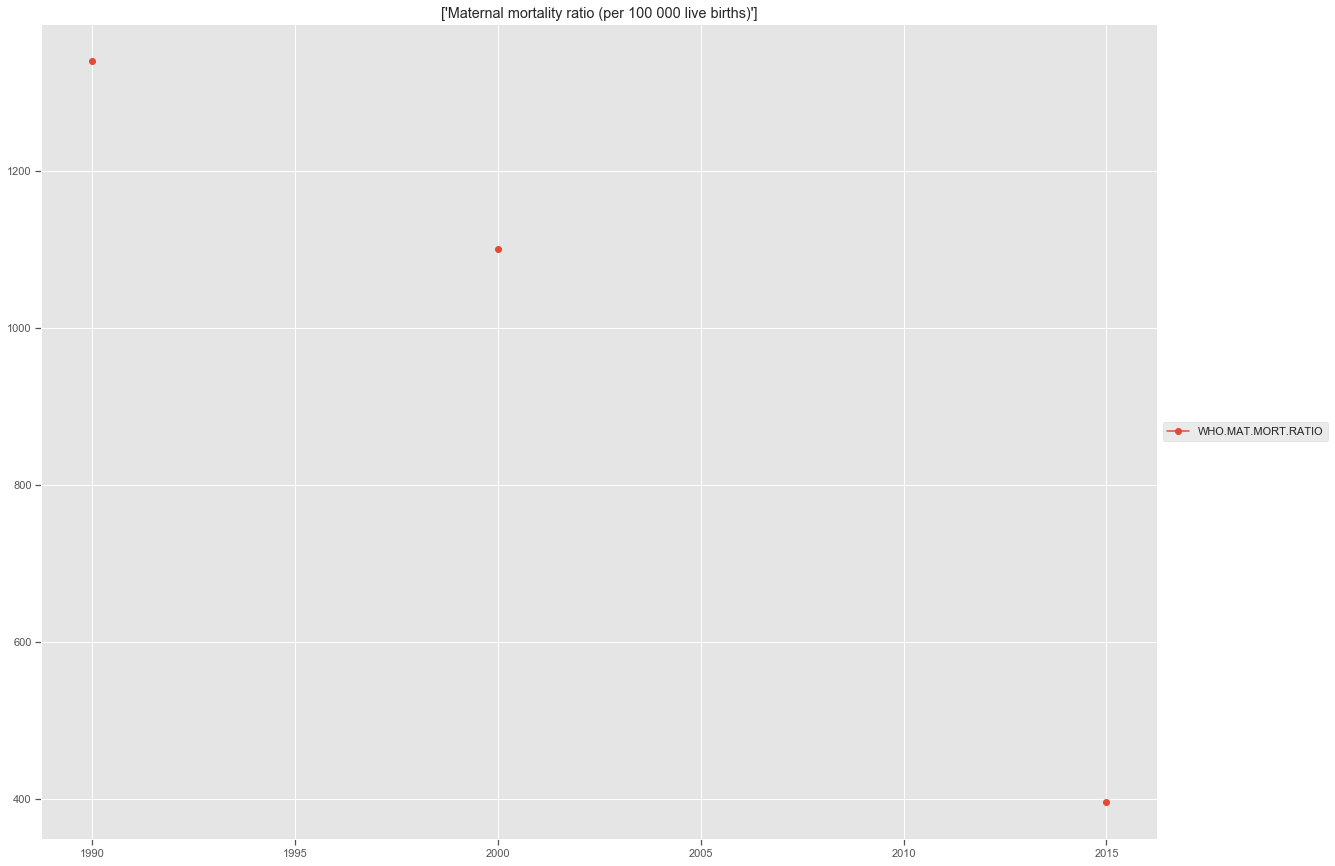

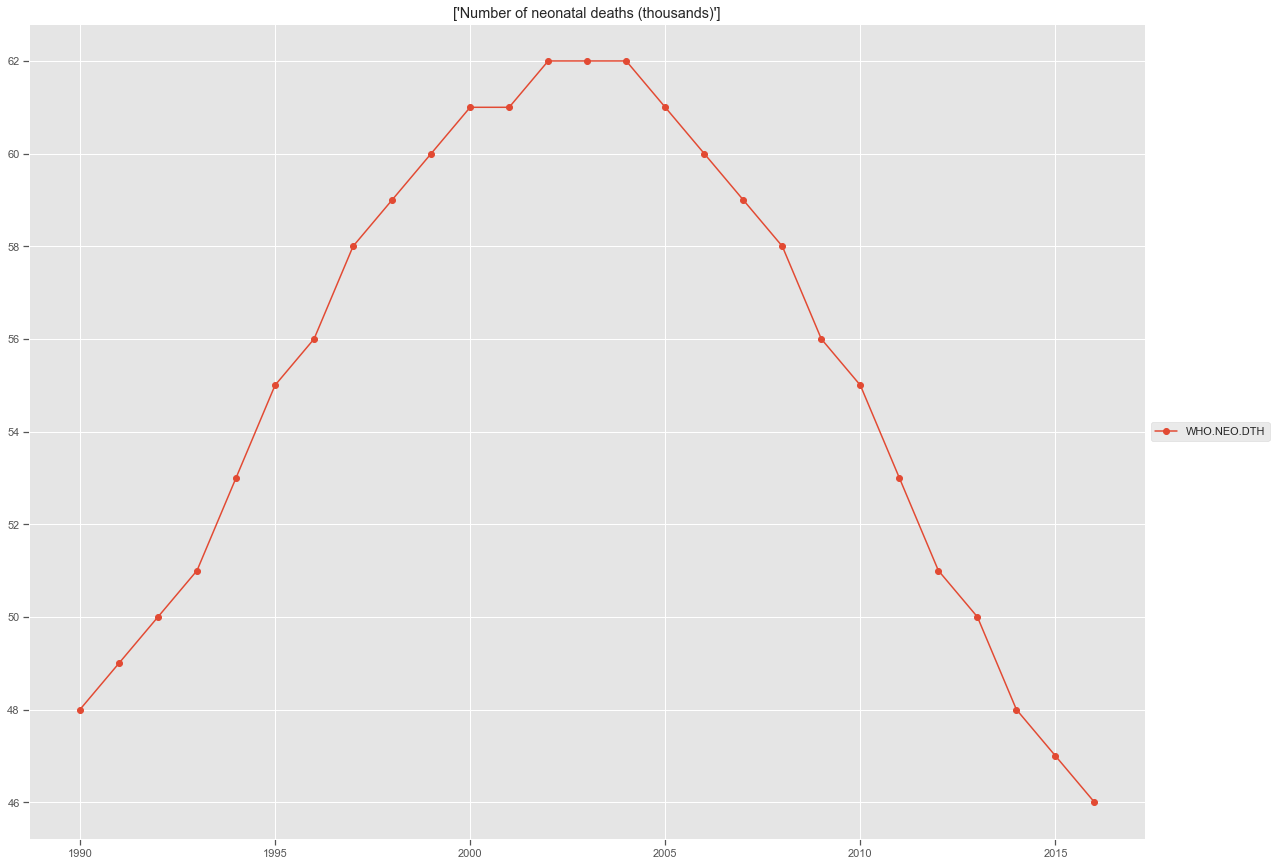

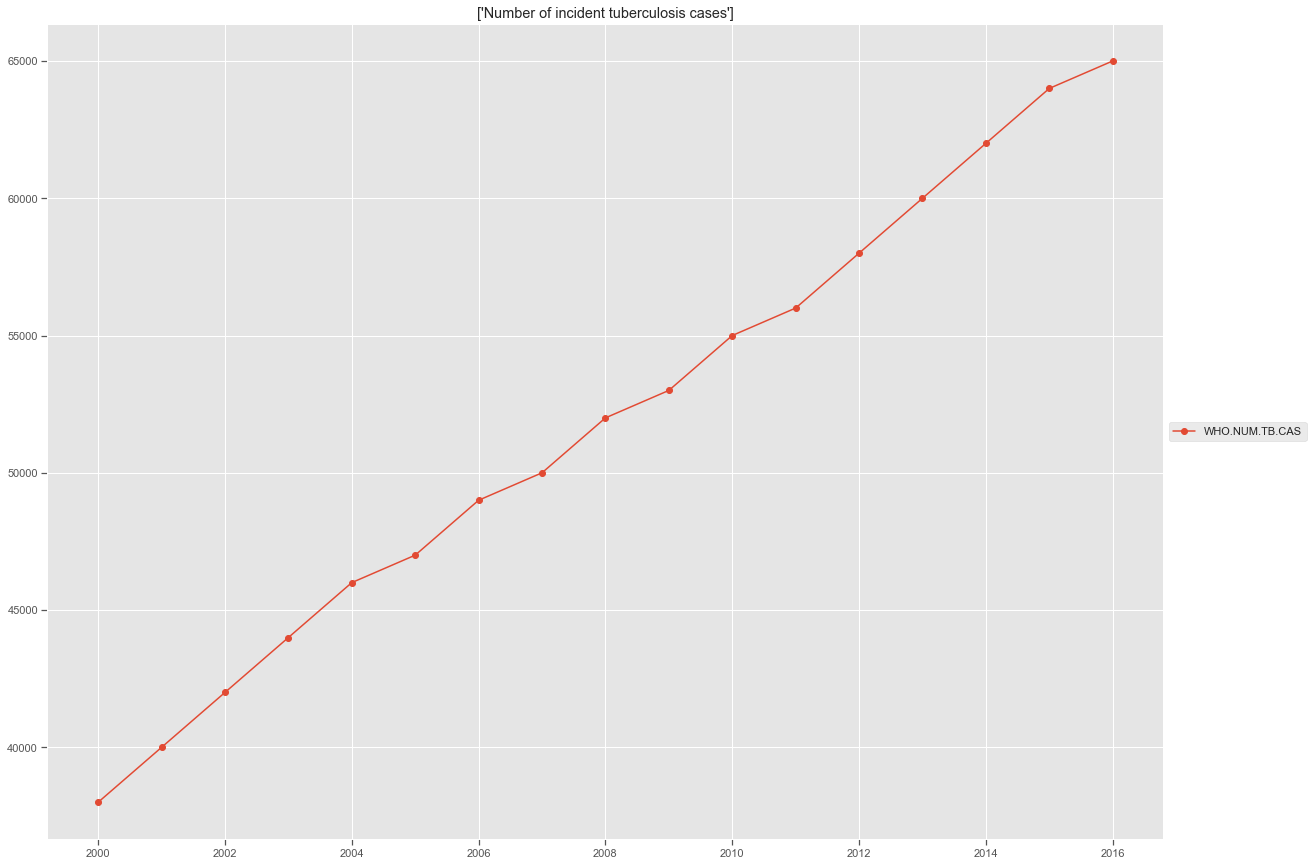

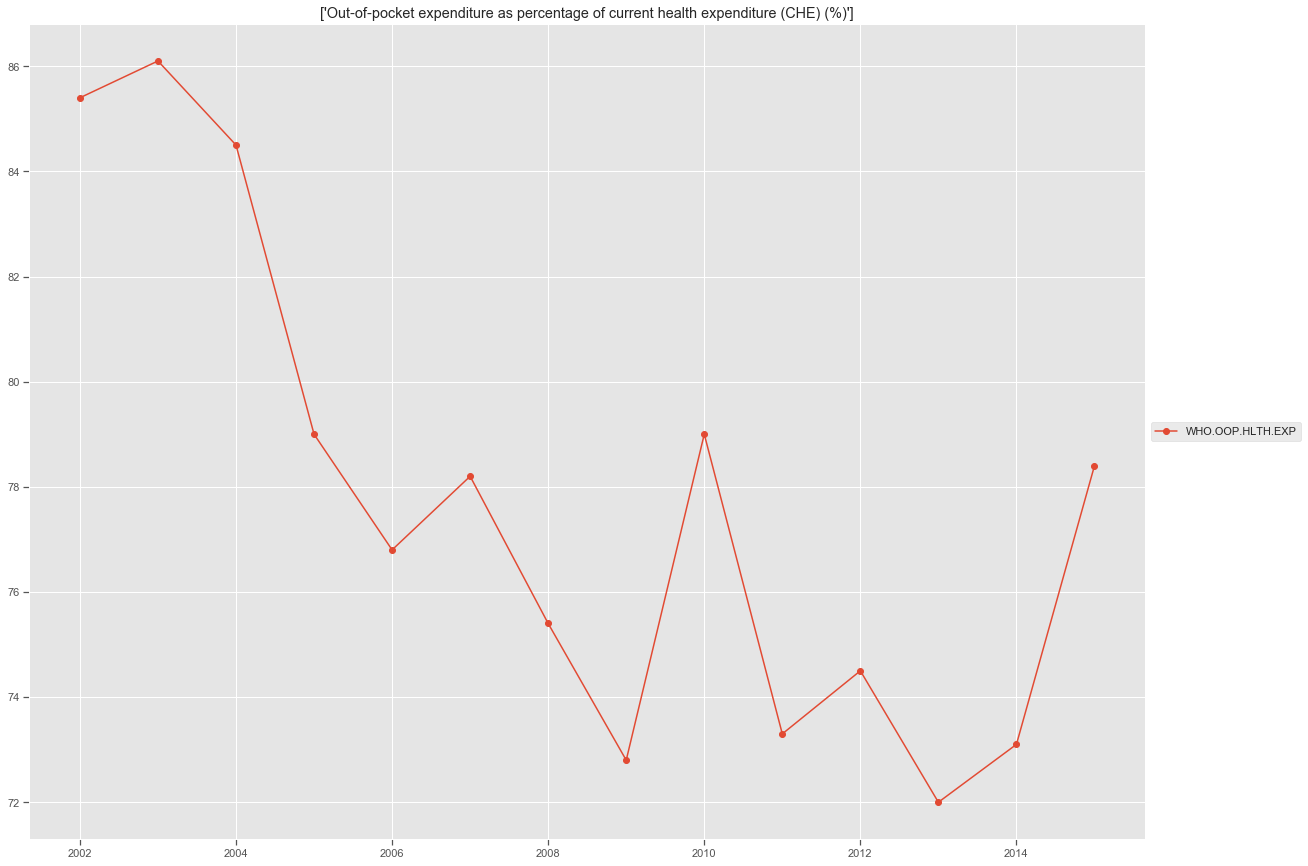

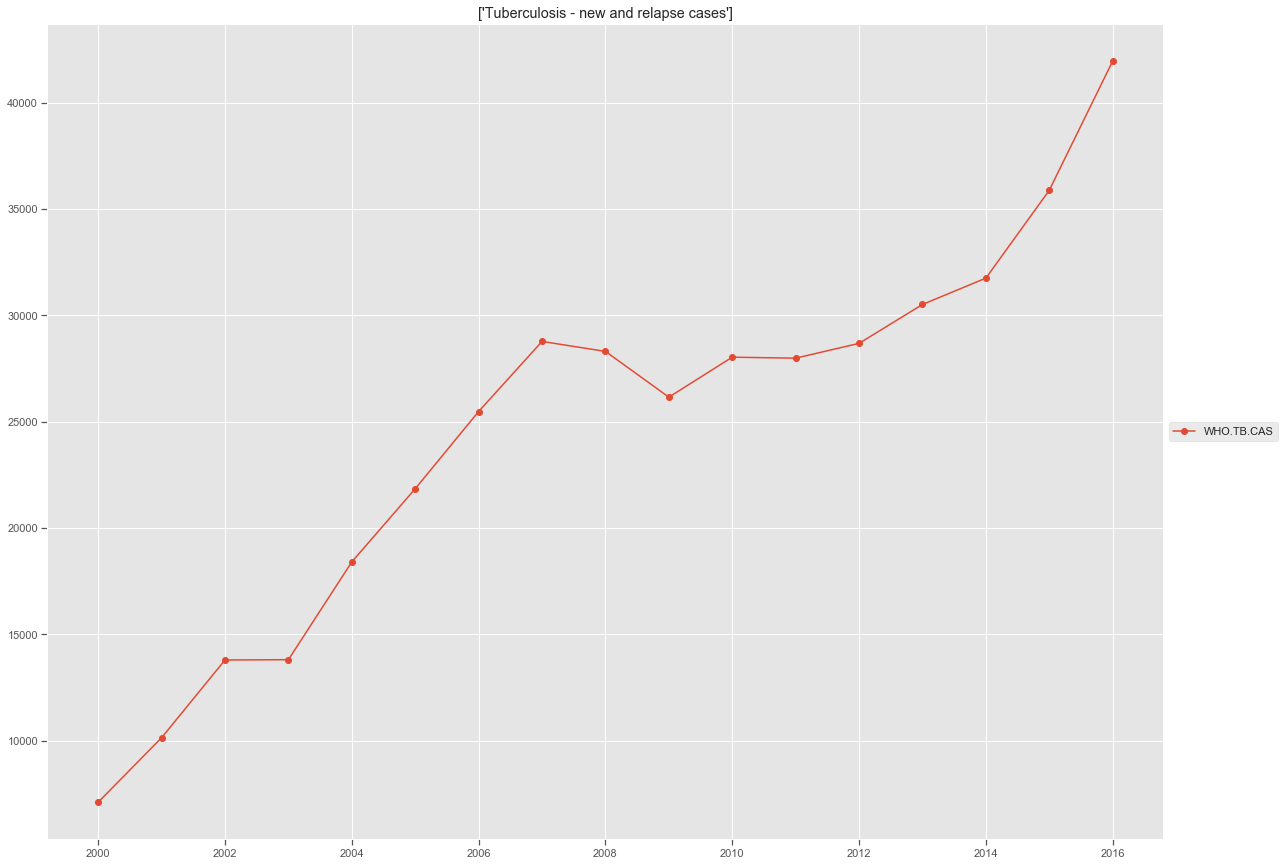

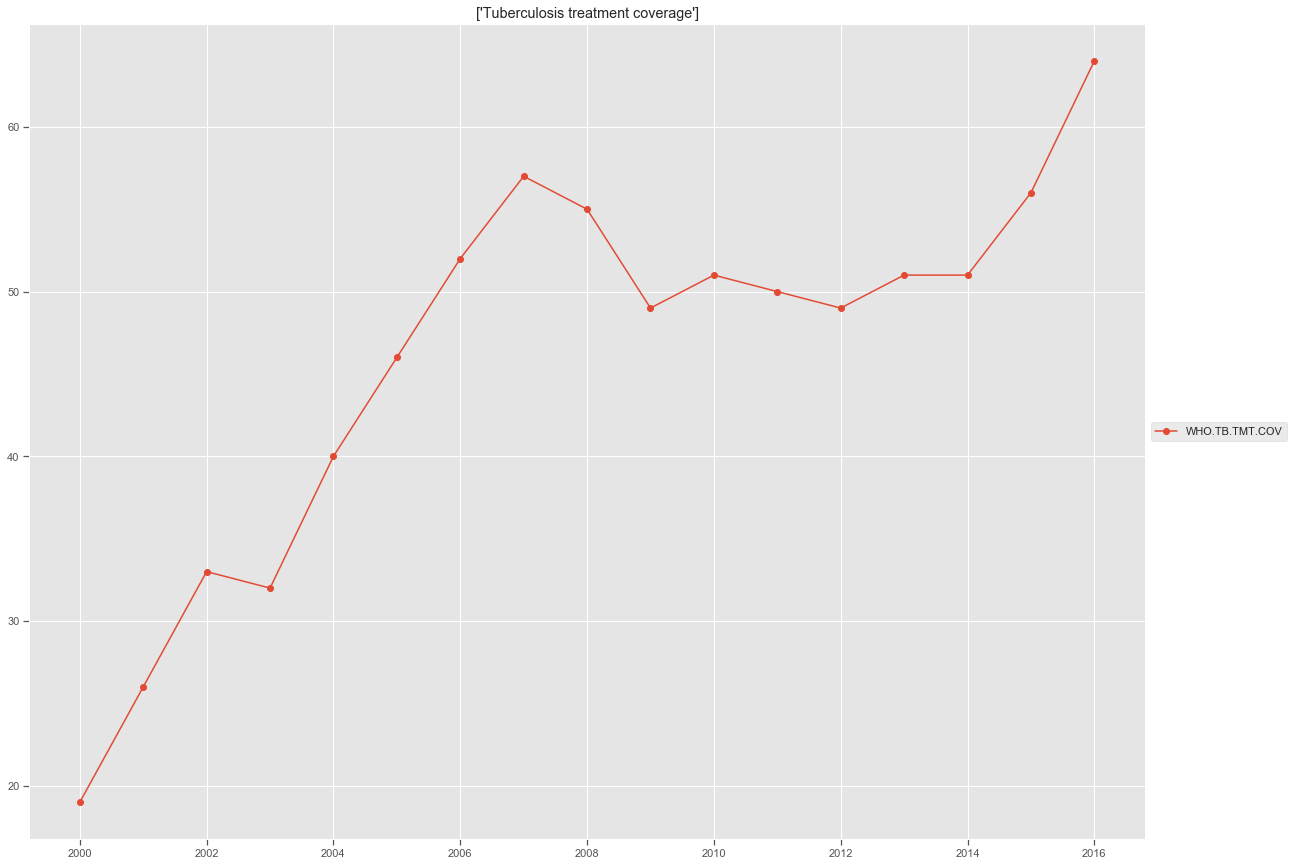

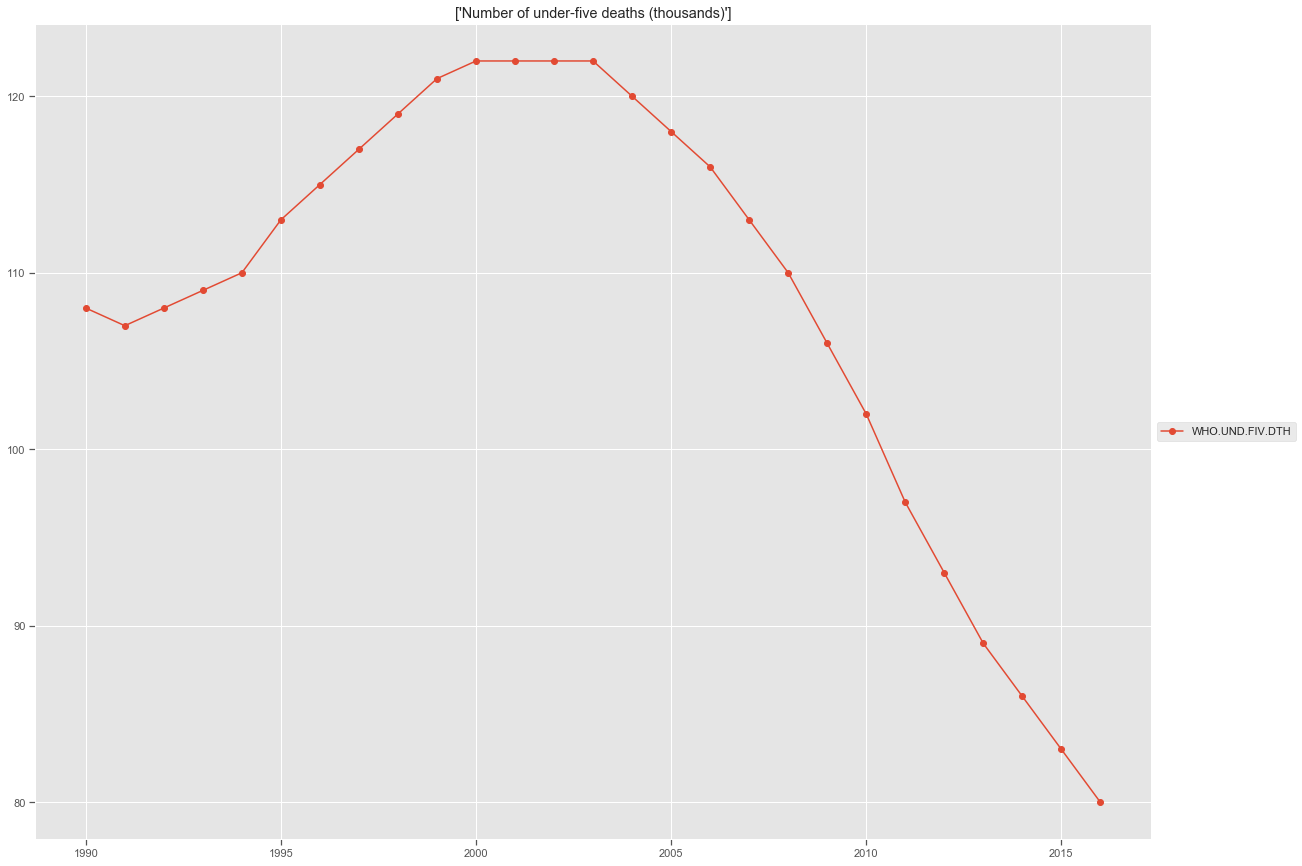

In [9]:
for i in indicators_raw:
    #data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant = explain(data, i)
    #print(mean, std)
    plt.plot(data.year,data[i].values,marker='o')
    #print(std, significant)
    for dot in significant:
        plt.plot(dot[0],dot[1], 'ro', color='b') 
    plt.title(df.loc[df["Indicator Code"]==i]["Indicator Name"].unique())
    plt.legend([i],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    

# Analysis as DataFrame 

In [10]:
result_df = pd.DataFrame(columns = ['Indicator Name', 'years', 'count', 'min', 'max', 'mean', 'std', 'nan, %','outliers'])
for i in indicators_raw:
    print(i)
    print(df.loc[df["Indicator Code"]==i]["Indicator Name"].unique())
    explain(data, i)
    print('\n')
    count, min, max, mean,std, nan,percent, outliers, year_from, year_to = explain(data, i)
    new_row = {'Indicator Name':i, 'years':str(year_from)+'-'+str(year_to), 'count':count, 'min':min, 'max':max, 'mean':mean, 'std':std, 'nan, %':percent,'outliers':outliers}
    result_df=result_df.append(new_row, ignore_index=True)

ACLED.COUNT
['ACLED total number of violent incidents annually.']




ValueError: too many values to unpack (expected 10)

In [ ]:
result_df.to_csv("Afghanistan.csv", index = None, header=True, columns=result_df.columns )

# Trend and Importance analysis 

In [ ]:
data['IDP'] = data['IDP'].apply(lambda x: (x - np.mean(data['IDP'])) / (np.max(data['IDP']) - np.min(data['IDP'])))
data['UNHCR.EDP'] = data['UNHCR.EDP'].apply(lambda x: (x - np.mean(data['UNHCR.EDP'])) / (np.max(data['UNHCR.EDP']) - np.min(data['UNHCR.EDP'])))

for i in indicators:
    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    plt.plot(data.year,data[i].values)
    plt.plot(data.year,data['UNHCR.EDP'].values)
    plt.plot(data.year,data['IDP'].values)
    plt.title(i)
    plt.legend([i, 'UNHCR.EDP', 'IDP'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [ ]:
#df1 = df.loc[(df['Country Name'] == 'Myanmar')]
df1 = df.loc[(df['Country Name'] == 'Afghanistan')]
# Now arrange data in long form
data = pd.pivot_table(df1, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)




In [ ]:
EDP_df = pd.DataFrame(columns = ['Indicator Name', 'n', 'r', 'CI95%', 'r2', 'adj_r2', 'p-val', 'BF10',  'power'])
IDP_df = pd.DataFrame(columns = ['Indicator Name', 'n', 'r', 'CI95%', 'r2', 'adj_r2', 'p-val', 'BF10',  'power'])

In [ ]:

for i in indicators:
    count = np.nan_to_num(data[i].count())
    if count>10:
        try:
            res = pg.corr(x=data[i].values, y=data['UNHCR.EDP'].values).reset_index()
            new_row = {'Indicator Name':i,  'n':res.n.values[0], 'r':res.r.values[0], 'CI95%':res['CI95%'].values[0],
                       'r2':res.r2.values[0], 'adj_r2':res.adj_r2.values[0], 'p-val':res['p-val'].values[0],
                       'BF10':res.BF10.values[0],  'power':res.power.values[0]}
            EDP_df=EDP_df.append(new_row, ignore_index=True)
            res = pg.corr(x=data[i].values, y=data['IDP'].values).reset_index()
            new_row = {'Indicator Name':i,  'n':res.n.values[0], 'r':res.r.values[0], 'CI95%':res['CI95%'].values[0],
                       'r2':res.r2.values[0], 'adj_r2':res.adj_r2.values[0], 'p-val':res['p-val'].values[0],
                       'BF10':res.BF10.values[0],  'power':res.power.values[0]}
            IDP_df=IDP_df.append(new_row, ignore_index=True)
        except:
            continue

In [ ]:
EDP_df = EDP_df.sort_values(by='r2', ascending=False)
EDP_df
ind1 = EDP_df["Indicator Name"].values[:10]
x=[]
for i in ind1:
    print(df.loc[df["Indicator Code"]==i]["Indicator Name"].unique())

    
    

In [ ]:
ind1

In [ ]:
for i in ind1:
    print(i)
    print(df.loc[df["Indicator Code"]==i]["Indicator Name"].unique())
    explain(data, i)
    print('\n')

In [ ]:
data

In [ ]:
ind1

In [ ]:
IDP_df = IDP_df.sort_values(by='r2', ascending=False)
IDP_df
ind1 = IDP_df["Indicator Name"].values[:10]
x=[]
for i in ind1:
    print(df.loc[df["Indicator Code"]==i]["Indicator Name"].unique())


In [ ]:
corrs = data.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.5, vmax=.5)
plt.title('Correlation matrix')

In [ ]:
top_EDP = EDP_df['Indicator Name'].values[:10]
top_IDP = IDP_df['Indicator Name'].values[:10]

In [ ]:
data['IDP'] = data['IDP'].apply(lambda x: (x - np.mean(data['IDP'])) / (np.max(data['IDP']) - np.min(data['IDP'])))
data['UNHCR.EDP'] = data['UNHCR.EDP'].apply(lambda x: (x - np.mean(data['UNHCR.EDP'])) / (np.max(data['UNHCR.EDP']) - np.min(data['UNHCR.EDP'])))

for i in top_EDP:
    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    plt.plot(data.year,data[i].values)
    plt.plot(data.year,data['UNHCR.EDP'].values)  
    plt.title(i)
    plt.legend([i, 'UNHCR.EDP'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

for i in top_IDP:
    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    plt.plot(data.year,data[i].values)
    plt.plot(data.year,data['IDP'].values)  
    plt.title(i)
    plt.legend([i, 'IDP'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
labels = IDP_df["Indicator Name"].values
values = IDP_df["r2"].values

# Plot
plt.pie(values, labels=labels, 
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [ ]:
labels = EDP_df["Indicator Name"].values
values = EDP_df["r2"].values

# Plot
plt.pie(values, labels=labels, 
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()